In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians, log, exp
# from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import os
# print(os.listdir("../input"))
# print(os.listdir("../input/rosbank-geo"))
# print(os.listdir("../input/find-distance"))
pd.options.display.max_columns = None

In [2]:
# ф-я ошибки
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [3]:
full_data = pd.read_csv('Rosbank_Happy_Data_Year/full_data.csv', index_col=0)
print (full_data.shape)
full_data.head()

(8765, 127)


,id_x,atm_group,address,address_rus,lat,long,target,isTrain,city_lat,city_long,geo_city,region,diff_from_centre,count,count_cities,count_regions,distance_1,indexes_1,distance_bear1,indexes_bear1,log_distance_1,distance_2,indexes_2,distance_bear2,indexes_bear2,log_distance_2,distance_3,indexes_3,distance_bear3,indexes_bear3,log_distance_3,distance_4,indexes_4,distance_bear4,indexes_bear4,log_distance_4,distance_5,indexes_5,distance_bear5,indexes_bear5,log_distance_5,mean,median,std,coords_pca,city,city_type,street,city_rank,city_type_rank,KMeans,MiniBatchKMeans,DBSCAN,Birch,MeanShift,dbcluster,propab_isolation,distance_1_min,distance_1_max,distance_1_mean,distance_1_median,distance_1_std,distance_1_skew,distance_2_min,distance_2_max,distance_2_mean,distance_2_median,distance_2_std,distance_2_skew,distance_3_min,distance_3_max,distance_3_mean,distance_3_median,distance_3_std,distance_3_skew,distance_4_min,distance_4_max,distance_4_mean,distance_4_median,distance_4_std,distance_4_skew,propab_isolation_min,propab_isolation_max,propab_isolation_mean,propab_isolation_median,propab_isolation_std,propab_isolation_skew,id_y,distance_1__absolute_sum_of_changes,distance_1__count_above_mean,distance_1__kurtosis,distance_1__length,distance_1__longest_strike_above_mean,distance_1__longest_strike_below_mean,distance_1__mean_abs_change,distance_1__mean_change,distance_1__mean_second_derivative_central,id_x.1,distance_2__absolute_sum_of_changes,distance_2__count_above_mean,distance_2__kurtosis,distance_2__length,distance_2__longest_strike_above_mean,distance_2__longest_strike_below_mean,distance_2__mean_abs_change,distance_2__mean_change,distance_2__mean_second_derivative_central,id_y.1,distance_3__absolute_sum_of_changes,distance_3__count_above_mean,distance_3__kurtosis,distance_3__length,distance_3__longest_strike_above_mean,distance_3__longest_strike_below_mean,distance_3__mean_abs_change,distance_3__mean_change,distance_3__mean_second_derivative_central,id,distance_4__absolute_sum_of_changes,distance_4__count_above_mean,distance_4__kurtosis,distance_4__length,distance_4__longest_strike_above_mean,distance_4__longest_strike_below_mean,distance_4__mean_abs_change,distance_4__mean_change,distance_4__mean_second_derivative_central
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,True,46.95407,142.73603,Yuzhno-Sakhalinsk,Sakhalin,84.555515,1.0,52.0,62.0,0.171318,8286.0,-31.996624,8071.0,0.158130,0.406053,5775.0,-31.995913,4182.0,0.340786,0.447444,3575.0,-31.990134,5607.0,0.369799,0.461430,2802.0,-31.982927,871.0,0.379416,0.558967,8335.0,-31.980920,7955.0,0.444024,-10.413943,0.340786,15.791868,79.447341,Южно-Сахалинск,Южно-Сахалинск,Южно-Сахалинск_улица А.О. Емельянова,7322.0,5272.0,13,31,0,77,37,0.0,0.357836,0.0,6.29425,0.559075,0.221691,1.038131,3.832853,0.0,6.835024,0.818977,0.447444,1.209491,3.380069,0.08853,16.229077,1.323493,0.638045,2.415692,4.705997,0.141586,31.300282,1.91201,0.727554,4.569964,5.331258,0.083178,0.607726,0.275365,0.304722,0.135469,0.474377,32.0,45.98677,12.0,17.923743,62.0,2.0,14.0,0.753881,-0.002808,-0.006965,32.0,60.297248,15.0,13.140742,62.0,2.0,13.0,0.988479,-0.006657,-0.010902,32.0,100.123898,17.0,26.956353,62.0,2.0,13.0,1.641375,-0.00351,-0.011297,32.0,158.3821,7.0,32.933815,62.0,2.0,21.0,2.596428,0.011343,-0.003517
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,True,46.95407,142.73603,Yuzhno-Sakhalinsk,Sakhalin,152.145602,1.0,52.0,62.0,0.243277,1647.0,-31.988475,8071.0,0.217751,0.649501,416.0,-31.987762,4182.0,0.500473,0.720783,7889.0,-31.981983,5607.0,0.542779,0.721148,6023.0,-31.974777,871.0,0.542992,0.903549,4770.0,-31.972774,7955.0,0.643720,-10.281320,0.500473,15.883565,79.462492,Южно-Сахалинск,Южно-Сахалинск,Южно-Сахалинск_Комсомольская улица,7322.0,5272.0,13,31,0,77,37,0.0,0.366491,0.0,6.29425,0.559075,0.221691,1.038131,3.832853,0.0,6.835024,0.818977,0.

In [4]:
full_data['Сцеп коорд_'] = full_data.apply(lambda row: str(row['lat'])+','+str(row['long']), axis=1)
full_data['id'] = full_data.apply(lambda row: row['id_x'], axis=1)
full_data.tail()

,id_x,atm_group,address,address_rus,lat,long,target,isTrain,city_lat,city_long,geo_city,region,diff_from_centre,count,count_cities,count_regions,distance_1,indexes_1,distance_bear1,indexes_bear1,log_distance_1,distance_2,indexes_2,distance_bear2,indexes_bear2,log_distance_2,distance_3,indexes_3,distance_bear3,indexes_bear3,log_distance_3,distance_4,indexes_4,distance_bear4,indexes_bear4,log_distance_4,distance_5,indexes_5,distance_bear5,indexes_bear5,log_distance_5,mean,median,std,coords_pca,city,city_type,street,city_rank,city_type_rank,KMeans,MiniBatchKMeans,DBSCAN,Birch,MeanShift,dbcluster,propab_isolation,distance_1_min,distance_1_max,distance_1_mean,distance_1_median,distance_1_std,distance_1_skew,distance_2_min,distance_2_max,distance_2_mean,distance_2_median,distance_2_std,distance_2_skew,distance_3_min,distance_3_max,distance_3_mean,distance_3_median,distance_3_std,distance_3_skew,distance_4_min,distance_4_max,distance_4_mean,distance_4_median,distance_4_std,distance_4_skew,propab_isolation_min,propab_isolation_max,propab_isolation_mean,propab_isolation_median,propab_isolation_std,propab_isolation_skew,id_y,distance_1__absolute_sum_of_changes,distance_1__count_above_mean,distance_1__kurtosis,distance_1__length,distance_1__longest_strike_above_mean,distance_1__longest_strike_below_mean,distance_1__mean_abs_change,distance_1__mean_change,distance_1__mean_second_derivative_central,id_x.1,distance_2__absolute_sum_of_changes,distance_2__count_above_mean,distance_2__kurtosis,distance_2__length,distance_2__longest_strike_above_mean,distance_2__longest_strike_below_mean,distance_2__mean_abs_change,distance_2__mean_change,distance_2__mean_second_derivative_central,id_y.1,distance_3__absolute_sum_of_changes,distance_3__count_above_mean,distance_3__kurtosis,distance_3__length,distance_3__longest_strike_above_mean,distance_3__longest_strike_below_mean,distance_3__mean_abs_change,distance_3__mean_change,distance_3__mean_second_derivative_central,id,distance_4__absolute_sum_of_changes,distance_4__count_above_mean,distance_4__kurtosis,distance_4__length,distance_4__longest_strike_above_mean,distance_4__longest_strike_below_mean,distance_4__mean_abs_change,distance_4__mean_change,distance_4__mean_second_derivative_central,Сцеп коорд_
2499,7805.0,5478.0,"D. 12, PROEZD ZAREVYI MOSKVA G","Заревый проезд, 12, Москва, Россия, 127282",55.886488,37.656829,0.0,False,55.88441,37.69055,Vatutino,Moscow,169.861353,1.0,16.0,636.0,0.394138,6204.0,-90.259190,4559.0,0.332276,0.394138,6115.0,-89.963028,5741.0,0.332276,0.394138,210.0,-89.894586,4182.0,0.332276,0.394138,6420.0,-89.886949,5607.0,0.332276,1.197650,3794.0,-89.836407,8071.0,0.787389,-29.663298,0.332276,44.139225,-25.890630,Москва,Москва,Москва_Заревый проезд,3282.5,2212.5,82,124,1,136,0,1.0,0.093958,0.0,943.717307,2.370989,0.105238,19.032152,36.133115,0.0,1503.707854,4.831496,0.517774,31.705972,32.017260,0.0,1504.318725,6.670407,0.803582,34.307925,26.034597,0.0,1505.177768,9.142787,1.047956,39.897563,18.201298,0.000000,1.000000,0.214913,0.150620,0.159347,1.221440,5478.0,15126.443964,322.0,1809.041700,3729.0,3.0,89.0,4.057523,-0.000261,0.000123,5478.0,29789.367960,351.0,1511.231508,3729.0,4.0,72.0,7.990710,-0.000074,0.000253,5478.0,38900.521482,415.0,1103.482759,3729.0,4.0,53.0,10.434689,-0.000074,0.000181,7805.0,50566.015457,441.0,612.858735,3729.0,6.0,50.0,13.563845,-0.000058,0.000189,"55.886488,37.656829"
2500,7395.0,5478.0,"D. 2B, UL. MIRA SOCHI G","улица Мира, 4, Адлерский район, Сочи, Краснода...",43.438310,39.912211,0.0,False,43.42896,39.92391,Adler,Krasnodarskiy,87.163003,1.0,6.0,210.0,0.363732,1718.0,-42.122709,4559.0,0.310225,1.198598,801.0,-41.483241,5607.0,0.787820,1.198598,803.0,-41.473115,5741.0,0.787820,1.260286,6478.0,-41.468165,4182.0,0.815491,1.326625,4590.0,-41.444590,871.0,0.844419,-13.273214,0.787820,20.734478,-23.182415,Адлерский район,RARE,Адлерский район_улица Мира,42.0,6926.5,16,122,15,81,104,14.0,0.219384,0.0,943.717307,2.370989,0.105238,19.032152,36.133115,0.0,1503

In [5]:
#основной файл со всеми фичами, тут и трейн, и тест
main_file = pd.read_excel('rosbank-geo/test and train ros.xlsx')
print (main_file.shape)
main_file.head()

(8765, 117)


,Drop,Test or Train,Unnamed: 2,id,atm_group,address,address_rus,lat,long,target,Сцеп коорд,Гео,Город,Субъект,ЗП субъект,Население субъекта,Процент от населения РФ,Плотность суюъекта,ФО,Охват VK,Охват MT,Охват MT 05,Покупки,Описание ГЕО,Планы на вечер,банкомат,Банк ВТБ,отделение,Сбербанк России,Росбанк,Россельхозбанк,Альфа-Банк,Газпромбанк,Магнит,Лента,Пятёрочка,М.Видео,Qiwi,Салон-магазин МТС,АК Барс банк,DNS,Билайн,МАРИЯ-РА,платежный терминал,Эльдорадо,Fix Price,Western Union,Спортмастер,Юнистрим,Бургер Кинг,Совкомбанк,Связной,Золотая Корона,Tele2,МегаФон,Аптека,Евросеть,Ашан,Дикси,Макдоналдс,KFC,Банк Открытие,О'КЕЙ,Детский мир,Много мебели,Будь Здоров,Магнит Косметик,пункт выдачи,Росгосстрах,SPAR,Райффайзенбанк,Промсвязьбанк,центр,Магазин,офис,банк,Торговый,Салон,Компания,Управление,области,почтовой,ТЦ,Аптека.1,Больница,красоты,Сервис,Студия,Городская,Нотариус,Вокзал,Агентство,Институт,поликлиника,Кафе,Клуб,Парк,Мастерская,Университет,Завод,Администрац,Суши,Школа,Фото,Бар,Парикмахерская,Клиника,Отель,ТРЦ,Мебель,Супермаркет,Гостиница,Аэропорт,гео_ц1,гео_ц2,гео_д1,гео_д2
0,be,Train,0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.01150,"46.940995,142.738319","Южно-Сахалинск, Сахалинская область, Россия",Южно-Сахалинск,Сахалинская область,70910,490181,0.33,5.63,ДВФО,5700,10500,2200,0,"Островной, Рост-Мед филиал, Банк Итуруп, банко...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,142,9409.0,7383
1,be,Test,0,8096.0,5478.0,"D. 97, UL. KIROVA NOVOKUZNETSK","улица Кирова, 97, Новокузнецк, Кемеровская обл...",53.757824,87.159780,NaN,"53.757824,87.15978","Новокузнецк, Кемеровская область, Россия, 654080",Новокузнецк,Кемеровская область,36179,2694877,1.83,28.15,СФО,11000,11300,4800,1,"Fix Price, Магазин СпецРоба, ОТП банк\n",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,87,7578.0,1597
2,be,Train,1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.02971,"46.937353,142.753348","Южно-Сахалинск, Сахалинская область, Россия",Южно-Сахалинск,Сахалинская область,70910,490181,0.33,5.63,ДВФО,5900,8100,4000,0,"Адвокат Гайкалов В. С., Qiwi, Сибек\n",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,142,9373.0,7533
3,be,Test,1,2570.0,3185.5,UL. SERGEJA MAKEEVA MOSKVA,улица Сергея Макеева,55.763128,37.551663,NaN,"55.763128,37.551663","Москва, Россия",Москва,Москва,89318,12506468,8.51,4883.43,ЦФО,11000,30300,7300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55,37,7631.0,5516
4,be,Test,2,2428.0,3185.5,"UL.NAHIMOVA, DOM 33 VILJUCHINSK","улица Нахимова, 33, жилой район Рыбачий, Вилюч...",52.918598,158.514038,NaN,"52.918598,158.514038","жилой район Рыбачий, Вилючинск, Камчатский кра...",Вилючинск,Камчатский край,76748,315557,0.21,0.68,ДВФО,920,200,200,1,"Магазин Николь, Нептун, Сбербанк России, банко...",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52,158,9185.0,5140


In [6]:
main_file['Сцеп коорд_'] = main_file.apply(lambda row: str(row['lat'])+','+str(row['long']), axis=1)
main_file.tail()

,Drop,Test or Train,Unnamed: 2,id,atm_group,address,address_rus,lat,long,target,Сцеп коорд,Гео,Город,Субъект,ЗП субъект,Население субъекта,Процент от населения РФ,Плотность суюъекта,ФО,Охват VK,Охват MT,Охват MT 05,Покупки,Описание ГЕО,Планы на вечер,банкомат,Банк ВТБ,отделение,Сбербанк России,Росбанк,Россельхозбанк,Альфа-Банк,Газпромбанк,Магнит,Лента,Пятёрочка,М.Видео,Qiwi,Салон-магазин МТС,АК Барс банк,DNS,Билайн,МАРИЯ-РА,платежный терминал,Эльдорадо,Fix Price,Western Union,Спортмастер,Юнистрим,Бургер Кинг,Совкомбанк,Связной,Золотая Корона,Tele2,МегаФон,Аптека,Евросеть,Ашан,Дикси,Макдоналдс,KFC,Банк Открытие,О'КЕЙ,Детский мир,Много мебели,Будь Здоров,Магнит Косметик,пункт выдачи,Росгосстрах,SPAR,Райффайзенбанк,Промсвязьбанк,центр,Магазин,офис,банк,Торговый,Салон,Компания,Управление,области,почтовой,ТЦ,Аптека.1,Больница,красоты,Сервис,Студия,Городская,Нотариус,Вокзал,Агентство,Институт,поликлиника,Кафе,Клуб,Парк,Мастерская,Университет,Завод,Администрац,Суши,Школа,Фото,Бар,Парикмахерская,Клиника,Отель,ТРЦ,Мебель,Супермаркет,Гостиница,Аэропорт,гео_ц1,гео_ц2,гео_д1,гео_д2,Сцеп коорд_
8760,be,Train,6256,4402.0,8083.0,"FEDORA POPOVA, 14 Yakutsk","улица Федора Попова, 14, Якутск, Республика Са...",62.045259,129.748896,0.207916,"62.045259,129.748896","Якутск, Республика Саха (Якутия), Россия, 677009",Якутск,Республика Саха (Якутия),63709,964330,0.66,0.31,ДВФО,9800,11400,11400,0,"Энергетикавиа АО О. Т., Всероссийский Электроп...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,129,452.0,7488,"62.045258999999994,129.748896"
8761,be,Train,6257,4421.0,8083.0,"STROITELEY, 43 Novokuznetsk","проспект Строителей, 43, Новокузнецк, Кемеровс...",53.769459,87.117251,0.062220,"53.769459,87.117251","Новокузнецк, Кемеровская область, Россия, 654005",Новокузнецк,Кемеровская область,36179,2694877,1.83,28.15,СФО,10000,14800,14800,1,"Южные электрические сети, производственное отд...",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,87,7694.0,1172,"53.769459,87.117251"
8762,be,Train,6258,4422.0,8083.0,"Rublevskoye sh, 62 Moskva","Рублёвское шоссе, 62, Москва, Россия, 121609",55.766212,37.380875,0.108743,"55.766212,37.380875","Москва, Россия, 121609",Москва,Москва,89318,12506468,8.51,4883.43,ЦФО,2700,3700,3700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55,37,7662.0,3808,"55.766212,37.380875"
8763,be,Train,6259,4426.0,8083.0,"EFANOVA, 22 Zyryanskoye","улица Ефанова, 22, село Зырянское, Зырянский р...",56.838223,86.640829,0.148938,"56.838223,86.640829","село Зырянское, Зырянский район, Томская облас...",село Зырянское,Томская область,40935,1078280,0.73,3.43,СФО,140,0,0,1,"Зырянская Районная больница, Росбанк, банкомат...",0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,86,8382.0,6408,"56.838223,86.64082900000001"
8764,be,Train,6260,4429.0,8083.0,"OMMUNISTICHESKAYA,10A Kizhinga","Коммунистическая улица, 10А, село Кижинга, Киж...",51.848725,109.905102,0.089919,"51.848725,109.905102","село Кижинга, Кижингинский район, Республика Б...",село Кижинга,Республика Бурятия,35490,984511,0.67,2.80,ДВФО,1000,100,100,1,"Торговый дом Мир, Россельхозбанк, банкомат\n",0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,109,8487.0,9051,"51.848725,109.905102"


In [7]:
# full_data_cols = ['id','Сцеп коорд_','distance_bear1','indexes_bear1','distance_bear2','indexes_bear2','distance_bear3','indexes_bear3','distance_bear4','indexes_bear4','distance_bear5','indexes_bear5','median','std','coords_pca','KMeans','MiniBatchKMeans','DBSCAN','Birch','MeanShift','dbcluster','propab_isolation']
full_data_cols = ['id','city_lat','city_long','diff_from_centre','count_cities','count_regions','distance_bear1','indexes_bear1','log_distance_1','distance_bear2','indexes_bear2','log_distance_2','distance_bear3','indexes_bear3','log_distance_3','distance_bear4','indexes_bear4','log_distance_4','distance_bear5','indexes_bear5','log_distance_5','median','std','coords_pca','city_rank','city_type_rank','KMeans','MiniBatchKMeans','DBSCAN','Birch','MeanShift','dbcluster','propab_isolation','distance_1_min','distance_1_max','distance_1_mean','distance_1_median','distance_1_std','distance_1_skew','distance_2_min','distance_2_max','distance_2_mean','distance_2_median','distance_2_std','distance_2_skew','distance_3_min','distance_3_max','distance_3_mean','distance_3_median','distance_3_std','distance_3_skew','distance_4_min','distance_4_max','distance_4_mean','distance_4_median','distance_4_std','distance_4_skew','propab_isolation_min','propab_isolation_max','propab_isolation_mean','propab_isolation_median','propab_isolation_std','propab_isolation_skew','distance_1__absolute_sum_of_changes','distance_1__count_above_mean','distance_1__kurtosis','distance_1__length','distance_1__longest_strike_above_mean','distance_1__longest_strike_below_mean','distance_1__mean_abs_change','distance_1__mean_change','distance_1__mean_second_derivative_central','distance_2__absolute_sum_of_changes','distance_2__count_above_mean','distance_2__kurtosis','distance_2__length','distance_2__longest_strike_above_mean','distance_2__longest_strike_below_mean','distance_2__mean_abs_change','distance_2__mean_change','distance_2__mean_second_derivative_central','distance_3__absolute_sum_of_changes','distance_3__count_above_mean','distance_3__kurtosis','distance_3__length','distance_3__longest_strike_above_mean','distance_3__longest_strike_below_mean','distance_3__mean_abs_change','distance_3__mean_change','distance_3__mean_second_derivative_central','distance_4__absolute_sum_of_changes','distance_4__count_above_mean','distance_4__kurtosis','distance_4__length','distance_4__longest_strike_above_mean','distance_4__longest_strike_below_mean','distance_4__mean_abs_change','distance_4__mean_change','distance_4__mean_second_derivative_central','Сцеп коорд_']
full_data2 = full_data[full_data_cols]
print (full_data2.shape)
full_data2.head()

(8765, 100)


,id,city_lat,city_long,diff_from_centre,count_cities,count_regions,distance_bear1,indexes_bear1,log_distance_1,distance_bear2,indexes_bear2,log_distance_2,distance_bear3,indexes_bear3,log_distance_3,distance_bear4,indexes_bear4,log_distance_4,distance_bear5,indexes_bear5,log_distance_5,median,std,coords_pca,city_rank,city_type_rank,KMeans,MiniBatchKMeans,DBSCAN,Birch,MeanShift,dbcluster,propab_isolation,distance_1_min,distance_1_max,distance_1_mean,distance_1_median,distance_1_std,distance_1_skew,distance_2_min,distance_2_max,distance_2_mean,distance_2_median,distance_2_std,distance_2_skew,distance_3_min,distance_3_max,distance_3_mean,distance_3_median,distance_3_std,distance_3_skew,distance_4_min,distance_4_max,distance_4_mean,distance_4_median,distance_4_std,distance_4_skew,propab_isolation_min,propab_isolation_max,propab_isolation_mean,propab_isolation_median,propab_isolation_std,propab_isolation_skew,distance_1__absolute_sum_of_changes,distance_1__count_above_mean,distance_1__kurtosis,distance_1__length,distance_1__longest_strike_above_mean,distance_1__longest_strike_below_mean,distance_1__mean_abs_change,distance_1__mean_change,distance_1__mean_second_derivative_central,distance_2__absolute_sum_of_changes,distance_2__count_above_mean,distance_2__kurtosis,distance_2__length,distance_2__longest_strike_above_mean,distance_2__longest_strike_below_mean,distance_2__mean_abs_change,distance_2__mean_change,distance_2__mean_second_derivative_central,distance_3__absolute_sum_of_changes,distance_3__count_above_mean,distance_3__kurtosis,distance_3__length,distance_3__longest_strike_above_mean,distance_3__longest_strike_below_mean,distance_3__mean_abs_change,distance_3__mean_change,distance_3__mean_second_derivative_central,distance_4__absolute_sum_of_changes,distance_4__count_above_mean,distance_4__kurtosis,distance_4__length,distance_4__longest_strike_above_mean,distance_4__longest_strike_below_mean,distance_4__mean_abs_change,distance_4__mean_change,distance_4__mean_second_derivative_central,Сцеп коорд_
0,8526.0,46.95407,142.73603,84.555515,52.0,62.0,-31.996624,8071.0,0.158130,-31.995913,4182.0,0.340786,-31.990134,5607.0,0.369799,-31.982927,871.0,0.379416,-31.980920,7955.0,0.444024,0.340786,15.791868,79.447341,7322.0,5272.0,13,31,0,77,37,0.0,0.357836,0.0,6.29425,0.559075,0.221691,1.038131,3.832853,0.0,6.835024,0.818977,0.447444,1.209491,3.380069,0.08853,16.229077,1.323493,0.638045,2.415692,4.705997,0.141586,31.300282,1.91201,0.727554,4.569964,5.331258,0.083178,0.607726,0.275365,0.304722,0.135469,0.474377,45.98677,12.0,17.923743,62.0,2.0,14.0,0.753881,-0.002808,-0.006965,60.297248,15.0,13.140742,62.0,2.0,13.0,0.988479,-0.006657,-0.010902,100.123898,17.0,26.956353,62.0,2.0,13.0,1.641375,-0.00351,-0.011297,158.3821,7.0,32.933815,62.0,2.0,21.0,2.596428,0.011343,-0.003517,"46.940995,142.738319"
1,8532.0,46.95407,142.73603,152.145602,52.0,62.0,-31.988475,8071.0,0.217751,-31.987762,4182.0,0.500473,-31.981983,5607.0,0.542779,-31.974777,871.0,0.542992,-31.972774,7955.0,0.643720,0.500473,15.883565,79.462492,7322.0,5272.0,13,31,0,77,37,0.0,0.366491,0.0,6.29425,0.559075,0.221691,1.038131,3.832853,0.0,6.835024,0.818977,0.447444,1.209491,3.380069,0.08853,16.229077,1.323493,0.638045,2.415692,4.705997,0.141586,31.300282,1.91201,0.727554,4.569964,5.331258,0.083178,0.607726,0.275365,0.304722,0.135469,0.474377,45.98677,12.0,17.923743,62.0,2.0,14.0,0.753881,-0.002808,-0.006965,60.297248,15.0,13.140742,62.0,2.0,13.0,0.988479,-0.006657,-0.010902,100.123898,17.0,26.956353,62.0,2.0,13.0,1.641375,-0.00351,-0.011297,158.3821,7.0,32.933815,62.0,2.0,21.0,2.596428,0.011343,-0.003517,"46.937353,142.753348"
2,8533.0,46.95407,142.73603,46.688184,52.0,62.0,-31.999341,8071.0,0.200236,-31.998627,4182.0,0.200236,-31.992846,5607.0,0.265781,-31.985640,871.0,0.292289,-31.983640,7955.0,0.402676,0.221691,15.754367,79.449460,5703.5,6926.5,13,31,0,77,37,0.0,0.337561,0.0,6.29425,0.559075,0.221691,1.038131,3.832853,0.0,6.835024,0.818977,0.447444,1.209491,3.380069,0.08853,16.2

In [8]:
main_file = pd.merge(main_file, full_data2, how='left', on='id')
print (main_file.shape)
main_file.tail()

(8765, 217)


,Drop,Test or Train,Unnamed: 2,id,atm_group,address,address_rus,lat,long,target,Сцеп коорд,Гео,Город,Субъект,ЗП субъект,Население субъекта,Процент от населения РФ,Плотность суюъекта,ФО,Охват VK,Охват MT,Охват MT 05,Покупки,Описание ГЕО,Планы на вечер,банкомат,Банк ВТБ,отделение,Сбербанк России,Росбанк,Россельхозбанк,Альфа-Банк,Газпромбанк,Магнит,Лента,Пятёрочка,М.Видео,Qiwi,Салон-магазин МТС,АК Барс банк,DNS,Билайн,МАРИЯ-РА,платежный терминал,Эльдорадо,Fix Price,Western Union,Спортмастер,Юнистрим,Бургер Кинг,Совкомбанк,Связной,Золотая Корона,Tele2,МегаФон,Аптека,Евросеть,Ашан,Дикси,Макдоналдс,KFC,Банк Открытие,О'КЕЙ,Детский мир,Много мебели,Будь Здоров,Магнит Косметик,пункт выдачи,Росгосстрах,SPAR,Райффайзенбанк,Промсвязьбанк,центр,Магазин,офис,банк,Торговый,Салон,Компания,Управление,области,почтовой,ТЦ,Аптека.1,Больница,красоты,Сервис,Студия,Городская,Нотариус,Вокзал,Агентство,Институт,поликлиника,Кафе,Клуб,Парк,Мастерская,Университет,Завод,Администрац,Суши,Школа,Фото,Бар,Парикмахерская,Клиника,Отель,ТРЦ,Мебель,Супермаркет,Гостиница,Аэропорт,гео_ц1,гео_ц2,гео_д1,гео_д2,Сцеп коорд__x,city_lat,city_long,diff_from_centre,count_cities,count_regions,distance_bear1,indexes_bear1,log_distance_1,distance_bear2,indexes_bear2,log_distance_2,distance_bear3,indexes_bear3,log_distance_3,distance_bear4,indexes_bear4,log_distance_4,distance_bear5,indexes_bear5,log_distance_5,median,std,coords_pca,city_rank,city_type_rank,KMeans,MiniBatchKMeans,DBSCAN,Birch,MeanShift,dbcluster,propab_isolation,distance_1_min,distance_1_max,distance_1_mean,distance_1_median,distance_1_std,distance_1_skew,distance_2_min,distance_2_max,distance_2_mean,distance_2_median,distance_2_std,distance_2_skew,distance_3_min,distance_3_max,distance_3_mean,distance_3_median,distance_3_std,distance_3_skew,distance_4_min,distance_4_max,distance_4_mean,distance_4_median,distance_4_std,distance_4_skew,propab_isolation_min,propab_isolation_max,propab_isolation_mean,propab_isolation_median,propab_isolation_std,propab_isolation_skew,distance_1__absolute_sum_of_changes,distance_1__count_above_mean,distance_1__kurtosis,distance_1__length,distance_1__longest_strike_above_mean,distance_1__longest_strike_below_mean,distance_1__mean_abs_change,distance_1__mean_change,distance_1__mean_second_derivative_central,distance_2__absolute_sum_of_changes,distance_2__count_above_mean,distance_2__kurtosis,distance_2__length,distance_2__longest_strike_above_mean,distance_2__longest_strike_below_mean,distance_2__mean_abs_change,distance_2__mean_change,distance_2__mean_second_derivative_central,distance_3__absolute_sum_of_changes,distance_3__count_above_mean,distance_3__kurtosis,distance_3__length,distance_3__longest_strike_above_mean,distance_3__longest_strike_below_mean,distance_3__mean_abs_change,distance_3__mean_change,distance_3__mean_second_derivative_central,distance_4__absolute_sum_of_changes,distance_4__count_above_mean,distance_4__kurtosis,distance_4__length,distance_4__longest_strike_above_mean,distance_4__longest_strike_below_mean,distance_4__mean_abs_change,distance_4__mean_change,distance_4__mean_second_derivative_central,Сцеп коорд__y
8760,be,Train,6256,4402.0,8083.0,"FEDORA POPOVA, 14 Yakutsk","улица Федора Попова, 14, Якутск, Республика Са...",62.045259,129.748896,0.207916,"62.045259,129.748896","Якутск, Республика Саха (Якутия), Россия, 677009",Якутск,Республика Саха (Якутия),63709,964330,0.66,0.31,ДВФО,9800,11400,11400,0,"Энергетикавиа АО О. Т., Всероссийский Электроп...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,129,452.0,7488,"62.045258999999994,129.748896",62.03389,129.73306,101.351030,106.0,146.0,-44.727910,8071.0,0.139335,-44.725535,4182.0,0.145711,-44.718244,5607.0,0.145711,-44.710854,4391.0,0.190372,-44.710723,7955.0,0.338360,0.145711,21.919894,65.915294,7406.0,5351.0,10,16,4,139,14,4.0,0.299435,0.0,259.622452,1.739974,0.131981,11.546593,

In [9]:
train = main_file[main_file['Test or Train']=='Train']
test = main_file[main_file['Test or Train']=='Test']
cities = pd.read_csv('rosbank-geo/cities.csv', index_col=0) # файл с гитхаба, где есть немного статы по российским городам
test_ind = pd.read_csv('rosbank-geo/test.csv', index_col=0) # этот фрейм создаю только для того, чтобы брать индексы для сабмита

In [10]:
distance_MT = pd.read_csv('find-distance/distances_MT.csv', index_col=0) # тут записано сколько разных объектов находится в заданном радиусе
distance_MT.head()

,Сцеп коорд,Аптеки_50м,Аптеки_100м,Аптеки_250м,Аптеки_500м,Аэропорты_50м,Аэропорты_100м,Аэропорты_250м,Аэропорты_500м,Банки_50м,Банки_100м,Банки_250м,Банки_500м,Бары_50м,Бары_100м,Бары_250м,Бары_500м,Больницы_50м,Больницы_100м,Больницы_250м,Больницы_500м,Детские сады_50м,Детские сады_100м,Детские сады_250м,Детские сады_500м,ФНС_50м,ФНС_100м,ФНС_250м,ФНС_500м,Кафе_50м,Кафе_100м,Кафе_250м,Кафе_500м,Кинотеатры_50м,Кинотеатры_100м,Кинотеатры_250м,Кинотеатры_500м,Коворкинги_50м,Коворкинги_100м,Коворкинги_250м,Коворкинги_500м,Колледжи_50м,Колледжи_100м,Колледжи_250м,Колледжи_500м,Пабы_50м,Пабы_100м,Пабы_250м,Пабы_500м,Рестораны_50м,Рестораны_100м,Рестораны_250м,Рестораны_500м,Родильные дома_50м,Родильные дома_100м,Родильные дома_250м,Родильные дома_500м,Рынки_50м,Рынки_100м,Рынки_250м,Рынки_500м,Театры_50м,Театры_100м,Театры_250м,Театры_500м,Metro C&C_50м,Metro C&C_100м,Metro C&C_250м,Metro C&C_500м,Spar_50м,Spar_100м,Spar_250м,Spar_500м,Карусель_50м,Карусель_100м,Карусель_250м,Карусель_500м,Комус_50м,Комус_100м,Комус_250м,Комус_500м,Лента_50м,Лента_100м,Лента_250м,Лента_500м,Магнит Косметик_50м,Магнит Косметик_100м,Магнит Косметик_250м,Магнит Косметик_500м,Окей_50м,Окей_100м,Окей_250м,Окей_500м,Перекресток_50м,Перекресток_100м,Перекресток_250м,Перекресток_500м,Рубль Бум_50м,Рубль Бум_100м,Рубль Бум_250м,Рубль Бум_500м,Ярче_50м,Ярче_100м,Ярче_250м,Ярче_500м,ТЦ_50м,ТЦ_100м,ТЦ_250м,ТЦ_500м,Университеты_50м,Университеты_100м,Университеты_250м,Университеты_500м,Фитнес-центры_50м,Фитнес-центры_100м,Фитнес-центры_250м,Фитнес-центры_500м,Школы_50м,Школы_100м,Школы_250м,Школы_500м
0,"46.940995,142.738319",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,4,0,0,0,0,0,0,0,0,0,0,1,1
1,"53.757824,87.15978",0,0,1,2,0,0,0,0,0,0,1,3,0,0,0,0,0,0,1,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
2,"46.937353,142.753348",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,4,0,0,0,0,0,0,0,0,0,0,0,1
3,"55.763128,37.551663",0,0,0,2,0,0,0,0,0,0,0,4,0,0,0,1,0,1,1,1,0,0,0,1,0,0,0,1,1,1,2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,1,1,1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,"52.918598,158.514038",0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,2,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,3


In [11]:
# тут я пытался дропать из трейна строки с верхними и нижними значениями target , но это только ухудшало локальный скор.
# train = train[train["Drop"] == 'be']
# train = train[500:len(train)-1]
print (len(train))
# train = train.drop(train[train.target >= 0.217167981886015].index)  #test size 0.01
# train.target.describe()
# 0.04325890941351625  <= -0.133333245098047
# 0.04171982979345305  <= -0.143075627519054
# 0.03442704567691503 ничего не дропаем
# 0.052695839112115624 <= -0.143824967149008
# 0.04001711820708623 <= -0.144432300046998
# 0.04728565615375519 <= -0.145001231474754
# 0.03999010197495459 >= 0.206912776800357
# 0.03911348242744554 >= 0.213149179503465
# 0.03264060687362574 >= 0.217167981886015
# 0.040385637798340986 >= 0.218018814016094
# 0.05037285925010933 >= 0.218608316699716

6261


In [12]:
# Распределение target в тейне разное, значений примерно от -0.04 до 0.07 больше всего, попробовал дропнуть каждую вторую строку из этого диапазона, но точность локальная не улучшилась
# drop_ids = [10.0, 100.0, 1003.0, 101.0, 1010.0, 1020.0, 1021.0, 1023.0, 1024.0, 1034.0, 1037.0, 1038.0, 1042.0, 1049.0, 1052.0, 1060.0, 1061.0, 1063.0, 107.0, 1072.0, 1074.0, 1078.0, 1079.0, 1081.0, 1083.0, 1090.0, 1093.0, 110.0, 1100.0, 1105.0, 1106.0, 1114.0, 1121.0, 1122.0, 1123.0, 1125.0, 1130.0, 1132.0, 1135.0, 1138.0, 114.0, 1140.0, 1149.0, 1151.0, 1154.0, 1161.0, 1162.0, 1165.0, 1166.0, 1169.0, 117.0, 1172.0, 1177.0, 1180.0, 1181.0, 1186.0, 1189.0, 1190.0, 1195.0, 1199.0, 12.0, 1202.0, 1206.0, 1207.0, 121.0, 1216.0, 1217.0, 1219.0, 1220.0, 1227.0, 1231.0, 1234.0, 1236.0, 124.0, 1241.0, 1242.0, 1245.0, 1246.0, 125.0, 1251.0, 1253.0, 1256.0, 1261.0, 1263.0, 1267.0, 1268.0, 127.0, 1271.0, 1272.0, 1275.0, 1278.0, 1279.0, 1281.0, 1285.0, 1292.0, 1295.0, 1296.0, 1298.0, 13.0, 1303.0, 1304.0, 1306.0, 131.0, 1310.0, 1311.0, 1314.0, 132.0, 1320.0, 1321.0, 1323.0, 1329.0, 1338.0, 1339.0, 134.0, 1342.0, 1346.0, 1347.0, 1349.0, 1354.0, 1358.0, 1365.0, 1366.0, 1369.0, 1371.0, 1378.0, 1381.0, 1382.0, 1383.0, 1391.0, 1394.0, 1395.0, 1397.0, 1401.0, 1406.0, 1407.0, 1411.0, 1419.0, 1420.0, 1424.0, 1429.0, 1434.0, 144.0, 1442.0, 1455.0, 1464.0, 1468.0, 147.0, 1470.0, 1471.0, 1472.0, 1477.0, 148.0, 1481.0, 1483.0, 1484.0, 1485.0, 1490.0, 1497.0, 1499.0, 15.0, 1503.0, 1505.0, 1507.0, 1511.0, 1515.0, 1516.0, 1521.0, 1523.0, 1524.0, 1535.0, 1538.0, 1544.0, 1545.0, 1546.0, 1548.0, 1552.0, 1556.0, 1558.0, 1562.0, 1568.0, 1570.0, 1572.0, 1577.0, 1579.0, 1584.0, 1585.0, 1586.0, 159.0, 1593.0, 1594.0, 1596.0, 1599.0, 16.0, 1603.0, 1606.0, 1608.0, 1609.0, 1611.0, 1613.0, 1616.0, 1621.0, 1623.0, 1625.0, 1630.0, 1631.0, 1635.0, 1640.0, 1646.0, 1649.0, 1653.0, 1655.0, 1656.0, 1659.0, 1662.0, 1667.0, 1674.0, 1678.0, 168.0, 1680.0, 1686.0, 169.0, 1695.0, 1697.0, 1704.0, 171.0, 1711.0, 1714.0, 1716.0, 172.0, 1723.0, 1724.0, 1734.0, 1736.0, 1740.0, 1742.0, 1747.0, 175.0, 1752.0, 1755.0, 1757.0, 1759.0, 176.0, 1763.0, 1766.0, 1770.0, 1774.0, 1777.0, 1780.0, 1781.0, 1788.0, 1790.0, 1792.0, 180.0, 1807.0, 1808.0, 1810.0, 1811.0, 1821.0, 1822.0, 1823.0, 1824.0, 1826.0, 1830.0, 1832.0, 1834.0, 1835.0, 1839.0, 185.0, 1851.0, 1857.0, 1858.0, 1859.0, 1862.0, 1864.0, 1870.0, 1873.0, 1874.0, 1877.0, 1879.0, 1883.0, 1885.0, 189.0, 1901.0, 192.0, 1927.0, 1935.0, 1937.0, 1938.0, 1944.0, 1946.0, 1947.0, 195.0, 1955.0, 196.0, 1961.0, 1965.0, 1971.0, 1974.0, 1976.0, 1977.0, 1978.0, 1980.0, 1981.0, 1986.0, 1988.0, 1989.0, 1990.0, 1998.0, 1999.0, 2004.0, 2007.0, 2011.0, 2014.0, 2017.0, 2018.0, 2019.0, 202.0, 2023.0, 2025.0, 203.0, 2033.0, 2035.0, 204.0, 2042.0, 2045.0, 2052.0, 2053.0, 2055.0, 2059.0, 2060.0, 2064.0, 2067.0, 207.0, 2074.0, 2075.0, 2082.0, 2088.0, 2096.0, 2102.0, 2103.0, 2104.0, 2105.0, 2107.0, 2115.0, 2116.0, 2119.0, 212.0, 2125.0, 2130.0, 2131.0, 2139.0, 214.0, 2142.0, 2144.0, 2149.0, 2156.0, 2160.0, 2163.0, 2166.0, 2167.0, 2169.0, 217.0, 2172.0, 218.0, 2180.0, 2182.0, 2183.0, 2185.0, 2191.0, 2192.0, 2196.0, 220.0, 2200.0, 2205.0, 221.0, 2211.0, 2213.0, 2215.0, 2216.0, 2219.0, 2222.0, 2223.0, 2233.0, 2234.0, 2239.0, 2242.0, 2244.0, 2246.0, 2248.0, 2251.0, 2254.0, 2256.0, 2264.0, 2267.0, 2269.0, 2271.0, 2273.0, 2274.0, 2285.0, 2288.0, 229.0, 2290.0, 2291.0, 2298.0, 23.0, 2303.0, 2305.0, 2309.0, 231.0, 2313.0, 2315.0, 2316.0, 2322.0, 2325.0, 2329.0, 2331.0, 2333.0, 2338.0, 234.0, 2346.0, 2348.0, 2352.0, 2353.0, 236.0, 2363.0, 2364.0, 2368.0, 2372.0, 2374.0, 2384.0, 2385.0, 2388.0, 2390.0, 2396.0, 2399.0, 240.0, 2400.0, 2401.0, 2404.0, 2405.0, 2411.0, 2413.0, 2417.0, 242.0, 2420.0, 2425.0, 2427.0, 2430.0, 2437.0, 2438.0, 2448.0, 2454.0, 2457.0, 2463.0, 2466.0, 2468.0, 247.0, 2470.0, 2475.0, 2484.0, 2485.0, 2486.0, 249.0, 2492.0, 2494.0, 2497.0, 2498.0, 2503.0, 2507.0, 2510.0, 2512.0, 2515.0, 2516.0, 2521.0, 2523.0, 2526.0, 2531.0, 2532.0, 2533.0, 2534.0, 2537.0, 2539.0, 2541.0, 2543.0, 2548.0, 255.0, 2552.0, 2557.0, 2558.0, 2561.0, 2565.0, 2568.0, 2577.0, 2578.0, 2579.0, 2583.0, 2584.0, 2589.0, 2591.0, 2594.0, 2596.0, 2597.0, 2602.0, 2603.0, 2607.0, 2608.0, 261.0, 2614.0, 2617.0, 2618.0, 2620.0, 2625.0, 2628.0, 2629.0, 2632.0, 2638.0, 2641.0, 2642.0, 2643.0, 2652.0, 2653.0, 2657.0, 2658.0, 2659.0, 2667.0, 267.0, 2671.0, 2673.0, 2674.0, 2683.0, 2685.0, 2686.0, 2692.0, 2694.0, 2697.0, 2698.0, 2706.0, 2708.0, 2709.0, 2716.0, 2717.0, 2718.0, 2720.0, 2724.0, 2726.0, 2728.0, 2731.0, 2732.0, 2735.0, 2738.0, 2743.0, 2747.0, 2748.0, 2751.0, 2755.0, 276.0, 2766.0, 2768.0, 2769.0, 2770.0, 2771.0, 2783.0, 2784.0, 2786.0, 279.0, 2798.0, 2805.0, 2806.0, 2807.0, 2810.0, 2816.0, 2817.0, 2820.0, 2821.0, 2823.0, 2824.0, 2826.0, 2828.0, 2834.0, 2837.0, 2839.0, 284.0, 2844.0, 2848.0, 285.0, 2859.0, 286.0, 2864.0, 2866.0, 2869.0, 287.0, 2873.0, 2880.0, 2881.0, 2887.0, 2888.0, 289.0, 2896.0, 2897.0, 2899.0, 29.0, 290.0, 2902.0, 2903.0, 2904.0, 2905.0, 2909.0, 2915.0, 2917.0, 2920.0, 2923.0, 2924.0, 2926.0, 2929.0, 2933.0, 2934.0, 2935.0, 2938.0, 2940.0, 2941.0, 2942.0, 2949.0, 2954.0, 2958.0, 296.0, 2961.0, 2963.0, 2964.0, 2967.0, 2969.0, 2973.0, 2976.0, 298.0, 30.0, 300.0, 303.0, 305.0, 309.0, 316.0, 3165.0, 317.0, 318.0, 323.0, 325.0, 331.0, 335.0, 3353.0, 339.0, 3392.0, 3398.0, 34.0, 343.0, 350.0, 351.0, 354.0, 356.0, 3686.0, 369.0, 371.0, 372.0, 376.0, 3762.0, 377.0, 379.0, 3816.0, 383.0, 386.0, 387.0, 393.0, 3977.0, 398.0, 4001.0, 401.0, 402.0, 418.0, 421.0, 4213.0, 424.0, 426.0, 427.0, 4327.0, 436.0, 4396.0, 440.0, 443.0, 4435.0, 444.0, 4441.0, 4444.0, 4449.0, 4454.0, 446.0, 4462.0, 4466.0, 4468.0, 4469.0, 4472.0, 4474.0, 4479.0, 4489.0, 4492.0, 4494.0, 4497.0, 4500.0, 4501.0, 4503.0, 4506.0, 4509.0, 451.0, 4510.0, 4514.0, 4519.0, 4524.0, 4526.0, 4529.0, 4535.0, 454.0, 4540.0, 4547.0, 4552.0, 4554.0, 4557.0, 4558.0, 4566.0, 4567.0, 4570.0, 4571.0, 4574.0, 4579.0, 458.0, 4580.0, 4585.0, 4588.0, 4589.0, 4592.0, 4595.0, 4599.0, 4600.0, 4602.0, 4605.0, 4608.0, 4609.0, 4613.0, 4618.0, 4619.0, 462.0, 4623.0, 4627.0, 463.0, 4633.0, 4637.0, 4639.0, 4646.0, 4647.0, 4649.0, 465.0, 4653.0, 4660.0, 4665.0, 4670.0, 4672.0, 4674.0, 468.0, 4680.0, 4688.0, 469.0, 4692.0, 4693.0, 4702.0, 4705.0, 4708.0, 4713.0, 4716.0, 4721.0, 4731.0, 4732.0, 4735.0, 4736.0, 474.0, 4740.0, 4741.0, 4742.0, 4748.0, 4750.0, 4752.0, 4753.0, 4758.0, 476.0, 4762.0, 4768.0, 477.0, 4770.0, 4777.0, 4781.0, 4784.0, 4786.0, 4788.0, 4790.0, 4791.0, 4795.0, 4796.0, 4804.0, 4810.0, 4815.0, 4818.0, 4819.0, 4824.0, 4825.0, 4827.0, 4836.0, 4837.0, 4838.0, 4840.0, 4844.0, 4846.0, 4849.0, 4851.0, 4854.0, 4861.0, 4863.0, 4865.0, 4867.0, 4871.0, 4877.0, 4879.0, 488.0, 4883.0, 4885.0, 4886.0, 4889.0, 4890.0, 4894.0, 4895.0, 4897.0, 4900.0, 4904.0, 4906.0, 4909.0, 491.0, 4914.0, 4915.0, 4917.0, 4921.0, 4922.0, 4924.0, 4928.0, 4933.0, 4937.0, 4939.0, 494.0, 4940.0, 4945.0, 4949.0, 495.0, 4950.0, 4951.0, 4953.0, 4957.0, 4964.0, 4965.0, 4969.0, 4973.0, 4975.0, 4978.0, 4979.0, 4980.0, 4983.0, 4989.0, 4991.0, 4994.0, 4995.0, 5003.0, 5007.0, 5008.0, 501.0, 5011.0, 5012.0, 5017.0, 502.0, 5021.0, 5022.0, 5024.0, 5025.0, 5031.0, 5032.0, 5042.0, 5043.0, 5046.0, 5050.0, 5053.0, 5055.0, 5057.0, 5061.0, 5066.0, 5074.0, 5077.0, 5080.0, 5083.0, 5090.0, 5091.0, 5105.0, 5107.0, 5109.0, 5112.0, 5115.0, 5116.0, 5117.0, 5119.0, 5124.0, 5126.0, 5133.0, 5137.0, 5138.0, 5146.0, 5150.0, 5154.0, 5158.0, 5160.0, 5166.0, 5168.0, 517.0, 5170.0, 5173.0, 5175.0, 5176.0, 5178.0, 5182.0, 5189.0, 519.0, 5191.0, 5192.0, 5194.0, 5197.0, 5204.0, 5205.0, 5208.0, 5210.0, 5211.0, 5212.0, 5214.0, 5221.0, 5226.0, 5227.0, 5230.0, 5231.0, 5236.0, 524.0, 5241.0, 5245.0, 5250.0, 5253.0, 5255.0, 5257.0, 5262.0, 5264.0, 5270.0, 5271.0, 5277.0, 5282.0, 5284.0, 5286.0, 5289.0, 529.0, 5293.0, 5295.0, 5298.0, 53.0, 5302.0, 5305.0, 5312.0, 5317.0, 5319.0, 5322.0, 5324.0, 5328.0, 5330.0, 5334.0, 5337.0, 5338.0, 534.0, 5341.0, 5348.0, 5353.0, 5355.0, 5359.0, 5362.0, 5363.0, 5365.0, 5367.0, 537.0, 5373.0, 5376.0, 538.0, 5381.0, 5385.0, 5391.0, 5395.0, 5397.0, 5406.0, 5408.0, 5409.0, 5412.0, 5418.0, 5419.0, 5420.0, 5424.0, 5426.0, 5430.0, 5432.0, 5436.0, 5437.0, 5443.0, 5447.0,
#            5450.0, 5452.0, 5454.0, 5456.0, 5458.0, 546.0, 5460.0, 5467.0, 5469.0, 547.0, 5472.0, 5482.0, 5485.0, 5489.0, 5491.0, 5498.0, 5499.0, 55.0, 5503.0, 5505.0, 5508.0, 5509.0, 5510.0, 5518.0, 5520.0, 5524.0, 5526.0, 5534.0, 5536.0, 5539.0, 5541.0, 5542.0, 5548.0, 5549.0, 555.0, 5553.0, 5556.0, 5561.0, 5562.0, 5563.0, 5566.0, 5568.0, 5572.0, 5575.0, 5577.0, 5581.0, 5583.0, 5584.0, 5588.0, 5589.0, 5595.0, 5597.0, 560.0, 5606.0, 5607.0, 5609.0, 5611.0, 5615.0, 562.0, 5620.0, 5621.0, 5623.0, 5628.0, 5633.0, 5635.0, 5638.0, 564.0, 5643.0, 5645.0, 5649.0, 565.0, 5651.0, 5653.0, 5655.0, 5657.0, 5659.0, 5665.0, 5667.0, 5669.0, 5671.0, 5673.0, 5675.0, 5676.0, 5679.0, 5680.0, 5681.0, 5684.0, 5689.0, 5698.0, 5703.0, 5708.0, 5709.0, 5710.0, 5711.0, 5713.0, 5718.0, 5720.0, 5729.0, 5731.0, 5732.0, 5734.0, 5735.0, 5739.0, 5744.0, 5746.0, 5750.0, 5767.0, 5769.0, 5770.0, 5783.0, 5785.0, 5787.0, 5789.0, 579.0, 5792.0, 5800.0, 5801.0, 5802.0, 5810.0, 5817.0, 5818.0, 5821.0, 5822.0, 5824.0, 5827.0, 583.0, 5833.0, 5839.0, 5842.0, 5844.0, 5846.0, 5850.0, 5852.0, 5861.0, 5862.0, 5865.0, 5867.0, 5869.0, 587.0, 5871.0, 5876.0, 5878.0, 5881.0, 5883.0, 5886.0, 5888.0, 5891.0, 5896.0, 5898.0, 59.0, 590.0, 5900.0, 5902.0, 5908.0, 5909.0, 591.0, 5911.0, 5913.0, 5918.0, 5923.0, 5926.0, 5927.0, 5932.0, 5933.0, 5936.0, 5938.0, 594.0, 5940.0, 5941.0, 5943.0, 5945.0, 5947.0, 5953.0, 5955.0, 5957.0, 5961.0, 5965.0, 5969.0, 5975.0, 5982.0, 5984.0, 5985.0, 599.0, 5992.0, 5993.0, 5999.0, 6.0, 6002.0, 6005.0, 6007.0, 6009.0, 6011.0, 6016.0, 602.0, 6020.0, 6022.0, 6023.0, 6026.0, 6030.0, 6031.0, 6032.0, 6033.0, 6036.0, 6040.0, 6042.0, 6045.0, 6048.0, 6049.0, 6060.0, 6062.0, 6063.0, 6065.0, 6069.0, 6071.0, 6076.0, 6081.0, 6084.0, 6085.0, 6092.0, 6093.0, 6095.0, 6101.0, 6103.0, 6106.0, 6109.0, 6110.0, 6113.0, 6117.0, 6118.0, 6120.0, 6122.0, 6125.0, 6130.0, 6135.0, 6139.0, 6143.0, 6147.0, 6157.0, 6163.0, 6167.0, 6168.0, 6172.0, 6174.0, 6176.0, 6185.0, 6191.0, 62.0, 6201.0, 6203.0, 6205.0, 6207.0, 6209.0, 6212.0, 6214.0, 6220.0, 6224.0, 6227.0, 6229.0, 6232.0, 6234.0, 6236.0, 6240.0, 6243.0, 6245.0, 6248.0, 6250.0, 6253.0, 6255.0, 6257.0, 6259.0, 6261.0, 6263.0, 6267.0, 6275.0, 6277.0, 6279.0, 6281.0, 6283.0, 6286.0, 6288.0, 6297.0, 6301.0, 6308.0, 6311.0, 6313.0, 6316.0, 6317.0, 6318.0, 6320.0, 6325.0, 6328.0, 6329.0, 6332.0, 6334.0, 6335.0, 6337.0, 6346.0, 6348.0, 6349.0, 6351.0, 6359.0, 6363.0, 6364.0, 6367.0, 6368.0, 6370.0, 6371.0, 6376.0, 6378.0, 6382.0, 6384.0, 6386.0, 6388.0, 6394.0, 6396.0, 6398.0, 6404.0, 6405.0, 6408.0, 6410.0, 6411.0, 6412.0, 6417.0, 6419.0, 642.0, 6422.0, 6437.0, 644.0, 6445.0, 6446.0, 6448.0, 6449.0, 6450.0, 6451.0, 6458.0, 6460.0, 6464.0, 6465.0, 6468.0, 6470.0, 6472.0, 6474.0, 6483.0, 6486.0, 6488.0, 6490.0, 6505.0, 6507.0, 6509.0, 6511.0, 6512.0, 6516.0, 6517.0, 6519.0, 6525.0, 6527.0, 6529.0, 6531.0, 6535.0, 6537.0, 6539.0, 6544.0, 6546.0, 6553.0, 6554.0, 6556.0, 6558.0, 6560.0, 6566.0, 6568.0, 6570.0, 6571.0, 6573.0, 6577.0, 6580.0, 6585.0, 6587.0, 6593.0, 6595.0, 6597.0, 6598.0, 6600.0, 6603.0, 6606.0, 6613.0, 6616.0, 6619.0, 6621.0, 6626.0, 6627.0, 6628.0, 6631.0, 6633.0, 6641.0, 6643.0, 6646.0, 6647.0, 6653.0, 6656.0, 6660.0, 6665.0, 6667.0, 6672.0, 6673.0, 6674.0, 6676.0, 6682.0, 6687.0, 6688.0, 6690.0, 6692.0, 6696.0, 6698.0, 67.0, 670.0, 6701.0, 6705.0, 6710.0, 6711.0, 6713.0, 6719.0, 6721.0, 6723.0, 6724.0, 6727.0, 6729.0, 6731.0, 6732.0, 6734.0, 6736.0, 6739.0, 6741.0, 6743.0, 6745.0, 6747.0, 6748.0, 6753.0, 6755.0, 6756.0, 6761.0, 6762.0, 6764.0, 6765.0, 6768.0, 6770.0, 6775.0, 6778.0, 6784.0, 6787.0, 6791.0, 6792.0, 6794.0, 6796.0, 6803.0, 6804.0, 6809.0, 6813.0, 6815.0, 6817.0, 682.0, 6820.0, 6823.0, 6830.0, 6831.0, 6832.0, 6842.0, 6845.0, 6848.0, 6850.0, 6851.0, 6854.0, 6856.0, 6859.0, 6860.0, 6868.0, 6870.0, 6872.0, 6873.0, 6875.0, 6878.0, 6881.0, 6883.0, 6885.0, 6889.0, 6892.0, 6894.0, 6895.0, 6897.0, 69.0, 6901.0, 6908.0, 6909.0, 6914.0, 6915.0, 6917.0, 6918.0, 692.0, 6920.0, 6923.0, 6929.0, 6930.0, 6932.0, 6939.0, 6944.0, 6946.0, 6952.0, 6954.0, 6961.0, 6962.0, 6964.0, 6966.0, 6968.0, 6969.0, 6974.0, 6976.0, 6980.0, 6982.0, 6983.0, 6985.0, 6988.0, 6989.0, 6996.0, 700.0, 7000.0, 7001.0, 7002.0, 7012.0, 7013.0, 7014.0, 7017.0, 7018.0, 7021.0, 7028.0, 7030.0, 7035.0, 7039.0, 7043.0, 7044.0, 7045.0, 7047.0, 7054.0, 7057.0, 7059.0, 7060.0, 7069.0, 7073.0, 7077.0, 7078.0, 7082.0, 7085.0, 7086.0, 7095.0, 7097.0, 7101.0, 7105.0, 7107.0, 7109.0, 7112.0, 7114.0, 7116.0, 7117.0, 7124.0, 7126.0, 7127.0, 7129.0, 7132.0, 7135.0, 7137.0, 7144.0, 7145.0, 7149.0, 715.0, 7150.0, 7152.0, 7155.0, 7156.0, 7163.0, 7164.0, 7165.0, 7173.0, 7174.0, 7178.0, 7179.0, 7186.0, 7188.0, 7193.0, 7194.0, 7195.0, 72.0, 7201.0, 7202.0, 7203.0, 7207.0, 7208.0, 7218.0, 722.0, 7222.0, 7226.0, 7228.0, 7233.0, 7237.0, 7238.0, 724.0, 7240.0, 7244.0, 7247.0, 7249.0, 7254.0, 7255.0, 7256.0, 7261.0, 7262.0, 7263.0, 7269.0, 7273.0, 7277.0, 7280.0, 7289.0, 7291.0, 7296.0, 73.0, 7301.0, 7304.0, 7308.0, 7315.0, 7316.0, 7324.0, 7326.0, 7329.0, 7334.0, 7337.0, 7343.0, 7344.0, 7349.0, 735.0, 7353.0, 7355.0, 7358.0, 7364.0, 7365.0, 7370.0, 7373.0, 7378.0, 7383.0, 7385.0, 7386.0, 7394.0, 7397.0, 7399.0, 740.0, 7403.0, 7408.0, 741.0, 7410.0, 7419.0, 7423.0, 7427.0, 7431.0, 7435.0, 744.0, 7444.0, 7445.0, 7447.0, 745.0, 7451.0, 7456.0, 7460.0, 7462.0, 7465.0, 7466.0, 7470.0, 7474.0, 7476.0, 7477.0, 7484.0, 7487.0, 7488.0, 7492.0, 7493.0, 7494.0, 750.0, 7505.0, 7506.0, 7509.0, 7513.0, 752.0, 7520.0, 7525.0, 7527.0, 7531.0, 7535.0, 7536.0, 7543.0, 7547.0, 755.0, 7551.0, 7554.0, 7557.0, 7561.0, 7565.0, 7566.0, 757.0, 7572.0, 7575.0, 7577.0, 758.0, 7580.0, 7582.0, 7588.0, 7591.0, 7594.0, 7597.0, 7600.0, 7601.0, 7602.0, 7603.0, 7606.0, 7607.0, 7610.0, 7614.0, 7618.0, 7620.0, 7626.0, 7627.0, 7631.0, 7634.0, 7643.0, 7644.0, 7645.0, 7652.0, 7653.0, 7657.0, 7658.0, 7660.0, 7662.0, 7665.0, 767.0, 7671.0, 7675.0, 7676.0, 7678.0, 7681.0, 7686.0, 7692.0, 7696.0, 7697.0, 77.0, 7701.0, 7703.0, 771.0, 7712.0, 7714.0, 7717.0, 7721.0, 7722.0, 7724.0, 7732.0, 7733.0, 7734.0, 7739.0, 774.0, 7740.0, 7741.0, 7749.0, 775.0, 7755.0, 7756.0, 7757.0, 776.0, 7762.0, 7763.0, 7766.0, 7773.0, 7779.0, 778.0, 7781.0, 7785.0, 7787.0, 7788.0, 779.0, 7792.0, 7795.0, 7798.0, 78.0, 7803.0, 7807.0, 7810.0, 7813.0, 7818.0, 7822.0, 7826.0, 7828.0, 7831.0, 7837.0, 784.0, 7842.0, 7846.0, 7848.0, 7854.0, 7856.0, 7859.0, 7861.0, 7864.0, 7869.0, 7871.0, 7873.0, 7877.0, 7878.0, 7883.0, 7888.0, 7892.0, 7896.0, 7898.0, 7900.0, 7904.0, 7907.0, 7910.0, 7913.0, 7916.0, 7918.0, 7922.0, 7924.0, 7927.0, 7930.0, 7932.0, 7934.0, 7937.0, 7940.0, 7942.0, 7945.0, 7948.0, 7952.0, 7955.0, 7956.0, 7958.0, 796.0, 7960.0, 7961.0, 7970.0, 7973.0, 7974.0, 7975.0, 7977.0, 798.0, 7980.0, 7986.0, 7987.0, 7993.0, 7996.0, 7997.0, 8001.0, 8003.0, 8005.0, 8009.0, 801.0, 8011.0, 8013.0, 8015.0, 8018.0, 8022.0, 8024.0, 8029.0, 8032.0, 8039.0, 8040.0, 8041.0, 8043.0, 8047.0, 8049.0, 8053.0, 8055.0, 8057.0, 8062.5, 8064.0, 8065.0, 8067.0, 8071.0, 8072.0, 8075.0, 8077.0, 8078.0, 8080.0, 8083.0, 8087.0, 8089.0, 8093.0, 8094.0, 8100.0, 8102.0, 8108.0, 8110.0, 8112.0, 8115.0, 8116.0, 812.0, 8120.0, 8123.0, 8128.0, 8129.0, 8130.0, 8132.0, 8136.0, 8138.0, 8139.0, 8144.0, 8145.0, 8150.0, 8152.0, 8154.0, 8155.0, 8161.0, 8164.0, 8165.0, 8168.0, 8170.0, 8172.0, 8185.0, 8187.0, 8188.0, 8190.0, 8191.0, 8193.0, 8196.0, 8197.0, 8204.0, 8206.0, 821.0, 8210.0, 8212.0, 8213.0, 8215.0, 822.0, 8222.0, 8225.0, 8227.0, 8231.0, 8232.0, 8234.0, 8236.0, 8239.0, 824.0, 8241.0, 8243.0, 8245.0, 8248.0, 8250.0, 8251.0, 826.0, 8260.0, 8262.0, 8266.0, 8269.0, 8271.0, 8272.0, 8275.0, 8279.0, 8280.0, 8288.0, 8290.0, 8291.0, 8295.0, 8296.0, 8298.0, 830.0, 8300.0, 8302.0, 8303.0, 8308.0, 8309.0, 8313.0, 8316.0, 8323.0, 833.0, 8330.0, 8332.0, 8336.0, 8338.0, 834.0, 8340.0, 8344.0, 8346.0, 8348.0, 8349.0, 8353.0, 8356.0, 8357.0, 8360.0, 8365.0, 8366.0, 837.0, 8371.0, 8374.0, 8376.0, 8377.0, 8382.0, 8383.0, 8388.0, 8392.0, 8395.0, 8396.0, 84.0, 8400.0, 8403.0, 8406.0, 8408.0, 8410.0,
#             8411.0, 8413.0, 8420.0, 8422.0, 8425.0, 8427.0, 8434.0, 8437.0, 8439.0, 844.0, 8449.0, 8451.0, 8452.0, 8455.0, 8458.0, 8459.0, 8467.0, 8468.0, 8470.0, 8472.0, 8474.0, 8475.0, 8478.0, 8486.0, 8489.0, 8491.0, 8493.0, 8498.0, 8500.0, 8506.0, 851.0, 8511.0, 8517.0, 8526.0, 8528.0, 8533.0, 8534.0, 8537.0, 8541.0, 8543.0, 8545.0, 8551.0, 8552.0, 8553.0, 8555.0, 8559.0, 8560.0, 8567.0, 8569.0, 857.0, 8573.0, 8575.0, 8577.0, 8578.0, 8579.0, 858.0, 8588.0, 859.0, 8594.0, 8596.0, 8599.0, 86.0, 8600.0, 8603.0, 8609.0, 861.0, 8614.0, 8624.0, 8625.0, 8631.0, 8634.0, 8635.0, 8637.0, 8639.0, 864.0, 8657.0, 8658.0, 8660.0, 8665.0, 8668.0, 8669.0, 8670.0, 8673.0, 8674.0, 8675.0, 8678.0, 868.0, 8688.0, 8690.0, 8691.0, 8693.0, 8699.0, 8702.0, 8704.0, 8705.0, 8707.0, 871.0, 8714.0, 8717.0, 8724.0, 8730.0, 8731.0, 8738.0, 8739.0, 874.0, 8742.0, 8743.0, 8745.0, 8746.0, 8755.0, 8759.0, 8761.0, 8762.0, 8767.0, 8771.0, 8772.0, 8773.0, 8778.0, 8779.0, 8782.0, 8784.0, 8788.0, 8790.0, 8792.0, 8799.0, 8801.0, 8803.0, 8806.0, 8807.0, 8809.0, 886.0, 887.0, 890.0, 895.0, 899.0, 902.0, 909.0, 919.0, 924.0, 944.0, 946.0, 948.0, 953.0, 955.0, 964.0, 969.0, 97.0, 974.0, 975.0, 98.0, 981.0, 984.0]
     
drop_ids_54 = [1278.0,7517.0,3055.0,7773.0,2103.0,5884.0,7934.0,354.0,7657.0,1053.0,7762.0,275.0,2921.0,6769.0,3381.0,1923.0,660.0,8641.0,1049.0,617.0,5130.0,28.0,5159.0,7053.0,7018.0,8189.0,5601.0,924.0,5406.0,8799.0,6739.0,3508.0,723.0,8754.0,963.0,5538.0,6280.0,5787.0,7105.0,2790.0,4935.0,7742.0,8434.0,1774.0,4940.0,372.0,5850.0,2094.0,3164.0,2868.0,7082.0,5261.0,996.0,196.0]
for elem in drop_ids_54:
    train = train.drop(train[train.id == elem].index)
# drop_ids_250 = [1278.0,7517.0,3055.0,7773.0,2103.0,5884.0,7934.0,354.0,7657.0,1053.0,7762.0,275.0,2921.0,6769.0,3381.0,1923.0,660.0,8641.0,1049.0,617.0,5130.0,28.0,5159.0,7053.0,7018.0,8189.0,5601.0,924.0,5406.0,8799.0,6739.0,3508.0,723.0,8754.0,963.0,5538.0,6280.0,5787.0,7105.0,2790.0,4935.0,7742.0,8434.0,1774.0,4940.0,372.0,5850.0,2094.0,3164.0,2868.0,7082.0,5261.0,996.0,196.0,7333.0,2808.0,8674.0,1128.0,3208.0,4715.0,5683.0,5635.0,1807.0,7697.0,4630.0,8328.0,5834.0,7782.0,7454.0,365.0,3851.0,4435.0,8673.0,82.0,3326.0,8517.0,3448.0,4941.0,3980.0,5629.0,6935.0,107.0,6246.0,5684.0,3097.0,6922.0,2145.0,6404.0,1753.0,2165.0,5868.0,3589.0,2082.0,7584.0,7832.0,2272.0,1237.0,5844.0,5237.0,4136.0,4749.0,3751.0,4272.0,5728.0,2932.0,2702.0,4187.0,1489.0,4724.0,5575.0,6784.0,2274.0,7559.0,7598.0,4843.0,7258.0,4893.0,3423.0,3557.0,565.0,4716.0,7712.0,6229.0,62.0,1607.0,496.0,588.0,6816.0,8639.0,4787.0,1521.0,4096.0,339.0,289.0,4936.0,8366.0,3536.0,5565.0,8103.0,6284.0,1025.0,3382.0,2548.0,8302.0,4747.0,3494.0,1565.0,6704.0,4602.0,1077.0,7942.0,2213.0,5883.0,3458.0,3866.0,3332.0,915.0,3551.0,4605.0,7803.0,1389.0,8355.0,2864.0,2628.0,4316.0,2594.0,5351.0,8213.0,7573.0,3155.0,1216.0,7487.0,8212.0,4180.0,2555.0,2748.0,851.0,3439.0,7771.0,1183.0,7218.0,611.0,3824.0,2456.0,5670.0,3341.0,7979.0,5743.0,534.0,844.0,5902.0,7592.0,4849.0,4873.0,2613.0,3166.0,4675.0,2755.0,479.0,1401.0,1015.0,8273.0,8144.0,3201.0,5463.0,8538.0,8260.0,2153.0,2126.0,1561.0,8330.0,386.0,7089.0,4452.0,3908.0,7896.0,7929.0,2621.0,6783.0,6029.0,389.0,4038.0,4216.0,6742.0,451.0,8249.0,1528.0,780.0,4501.0,1281.0,8717.0,7944.0,322.0,6873.0,6110.0,3215.0,3134.0,6115.0,7677.0,3340.0,6091.0,2048.0,1399.0,3033.0,5366.0,2227.0,6487.0,1368.0,4292.0,4248.0]
# for elem in drop_ids:
#     train = train.drop(train[train.id == elem].index)

In [13]:
# for elem in train.target.unique():
#     print (elem)
len(train), len(train.target.unique())

(6207, 5730)

In [14]:
# добавляем доп инфу по городам
cities=cities[['Город','Широта', 'Долгота','Население','Признак центра района или региона']]
df2 = pd.DataFrame([['Москва',55.75222,37.61556,7000000,0]],columns=cities.columns)
cities=cities.append(df2, ignore_index=True)

In [15]:
train['isTrain'] = True
test['isTrain'] = False
X = train.append(test, sort=False)
# X = train.append(test)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
# X.describe().T

In [17]:
# X.describe(include='object').T

In [18]:
# кол-во банкоматов по одному адресу
counts = X.groupby('Сцеп коорд')['id'].count().reset_index().rename(columns={'id':'count'})
counts.head()

,Сцеп коорд,count
0,"42.05708,48.30023",1
1,"42.077207,48.288552",1
2,"42.648594,130.80509",1
3,"42.648627,131.080657",1
4,"42.713429,130.778572",1


In [19]:
X = pd.merge(X, counts, how='left', on='Сцеп коорд')
X.tail()

,Drop,Test or Train,Unnamed: 2,id,atm_group,address,address_rus,lat,long,target,Сцеп коорд,Гео,Город,Субъект,ЗП субъект,Население субъекта,Процент от населения РФ,Плотность суюъекта,ФО,Охват VK,Охват MT,Охват MT 05,Покупки,Описание ГЕО,Планы на вечер,банкомат,Банк ВТБ,отделение,Сбербанк России,Росбанк,Россельхозбанк,Альфа-Банк,Газпромбанк,Магнит,Лента,Пятёрочка,М.Видео,Qiwi,Салон-магазин МТС,АК Барс банк,DNS,Билайн,МАРИЯ-РА,платежный терминал,Эльдорадо,Fix Price,Western Union,Спортмастер,Юнистрим,Бургер Кинг,Совкомбанк,Связной,Золотая Корона,Tele2,МегаФон,Аптека,Евросеть,Ашан,Дикси,Макдоналдс,KFC,Банк Открытие,О'КЕЙ,Детский мир,Много мебели,Будь Здоров,Магнит Косметик,пункт выдачи,Росгосстрах,SPAR,Райффайзенбанк,Промсвязьбанк,центр,Магазин,офис,банк,Торговый,Салон,Компания,Управление,области,почтовой,ТЦ,Аптека.1,Больница,красоты,Сервис,Студия,Городская,Нотариус,Вокзал,Агентство,Институт,поликлиника,Кафе,Клуб,Парк,Мастерская,Университет,Завод,Администрац,Суши,Школа,Фото,Бар,Парикмахерская,Клиника,Отель,ТРЦ,Мебель,Супермаркет,Гостиница,Аэропорт,гео_ц1,гео_ц2,гео_д1,гео_д2,Сцеп коорд__x,city_lat,city_long,diff_from_centre,count_cities,count_regions,distance_bear1,indexes_bear1,log_distance_1,distance_bear2,indexes_bear2,log_distance_2,distance_bear3,indexes_bear3,log_distance_3,distance_bear4,indexes_bear4,log_distance_4,distance_bear5,indexes_bear5,log_distance_5,median,std,coords_pca,city_rank,city_type_rank,KMeans,MiniBatchKMeans,DBSCAN,Birch,MeanShift,dbcluster,propab_isolation,distance_1_min,distance_1_max,distance_1_mean,distance_1_median,distance_1_std,distance_1_skew,distance_2_min,distance_2_max,distance_2_mean,distance_2_median,distance_2_std,distance_2_skew,distance_3_min,distance_3_max,distance_3_mean,distance_3_median,distance_3_std,distance_3_skew,distance_4_min,distance_4_max,distance_4_mean,distance_4_median,distance_4_std,distance_4_skew,propab_isolation_min,propab_isolation_max,propab_isolation_mean,propab_isolation_median,propab_isolation_std,propab_isolation_skew,distance_1__absolute_sum_of_changes,distance_1__count_above_mean,distance_1__kurtosis,distance_1__length,distance_1__longest_strike_above_mean,distance_1__longest_strike_below_mean,distance_1__mean_abs_change,distance_1__mean_change,distance_1__mean_second_derivative_central,distance_2__absolute_sum_of_changes,distance_2__count_above_mean,distance_2__kurtosis,distance_2__length,distance_2__longest_strike_above_mean,distance_2__longest_strike_below_mean,distance_2__mean_abs_change,distance_2__mean_change,distance_2__mean_second_derivative_central,distance_3__absolute_sum_of_changes,distance_3__count_above_mean,distance_3__kurtosis,distance_3__length,distance_3__longest_strike_above_mean,distance_3__longest_strike_below_mean,distance_3__mean_abs_change,distance_3__mean_change,distance_3__mean_second_derivative_central,distance_4__absolute_sum_of_changes,distance_4__count_above_mean,distance_4__kurtosis,distance_4__length,distance_4__longest_strike_above_mean,distance_4__longest_strike_below_mean,distance_4__mean_abs_change,distance_4__mean_change,distance_4__mean_second_derivative_central,Сцеп коорд__y,isTrain,count
8706,be,Test,2499,7805.0,5478.0,"D. 12, PROEZD ZAREVYI MOSKVA G","Заревый проезд, 12, Москва, Россия, 127282",55.886488,37.656820,NaN,"55.886488,37.65682","Москва, Россия, 127282",Москва,Москва,89318,12506468,8.51,4883.43,ЦФО,29000,28100,8900,0,"Дом книги Медведково, Восточный экспресс, Соля...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55,37,8864.0,6568,"55.886488,37.65682",55.88441,37.69055,169.861353,16.0,636.0,-90.259190,4559.0,0.332276,-89.963028,5741.0,0.332276,-89.894586,4182.0,0.332276,-89.886949,5607.0,0.332276,-89.836407,8071.0,0.787389,0.332276,44.139225,-25.890630,3282.5,2212.5,82,124,1,136,0,1.0,0.093958,0.0,943.717307,2.370989,0.105238,19.032152,36.133115,0.0,1503.707854,4.831496,0.517774,31.70

In [20]:
X = pd.merge(X, distance_MT, how='left', on='Сцеп коорд')
X.head()

,Drop,Test or Train,Unnamed: 2,id,atm_group,address,address_rus,lat,long,target,Сцеп коорд,Гео,Город,Субъект,ЗП субъект,Население субъекта,Процент от населения РФ,Плотность суюъекта,ФО,Охват VK,Охват MT,Охват MT 05,Покупки,Описание ГЕО,Планы на вечер,банкомат,Банк ВТБ,отделение,Сбербанк России,Росбанк,Россельхозбанк,Альфа-Банк,Газпромбанк,Магнит,Лента,Пятёрочка,М.Видео,Qiwi,Салон-магазин МТС,АК Барс банк,DNS,Билайн,МАРИЯ-РА,платежный терминал,Эльдорадо,Fix Price,Western Union,Спортмастер,Юнистрим,Бургер Кинг,Совкомбанк,Связной,Золотая Корона,Tele2,МегаФон,Аптека,Евросеть,Ашан,Дикси,Макдоналдс,KFC,Банк Открытие,О'КЕЙ,Детский мир,Много мебели,Будь Здоров,Магнит Косметик,пункт выдачи,Росгосстрах,SPAR,Райффайзенбанк,Промсвязьбанк,центр,Магазин,офис,банк,Торговый,Салон,Компания,Управление,области,почтовой,ТЦ,Аптека.1,Больница,красоты,Сервис,Студия,Городская,Нотариус,Вокзал,Агентство,Институт,поликлиника,Кафе,Клуб,Парк,Мастерская,Университет,Завод,Администрац,Суши,Школа,Фото,Бар,Парикмахерская,Клиника,Отель,ТРЦ,Мебель,Супермаркет,Гостиница,Аэропорт,гео_ц1,гео_ц2,гео_д1,гео_д2,Сцеп коорд__x,city_lat,city_long,diff_from_centre,count_cities,count_regions,distance_bear1,indexes_bear1,log_distance_1,distance_bear2,indexes_bear2,log_distance_2,distance_bear3,indexes_bear3,log_distance_3,distance_bear4,indexes_bear4,log_distance_4,distance_bear5,indexes_bear5,log_distance_5,median,std,coords_pca,city_rank,city_type_rank,KMeans,MiniBatchKMeans,DBSCAN,Birch,MeanShift,dbcluster,propab_isolation,distance_1_min,distance_1_max,distance_1_mean,distance_1_median,distance_1_std,distance_1_skew,distance_2_min,distance_2_max,distance_2_mean,distance_2_median,distance_2_std,distance_2_skew,distance_3_min,distance_3_max,distance_3_mean,distance_3_median,distance_3_std,distance_3_skew,distance_4_min,distance_4_max,distance_4_mean,distance_4_median,distance_4_std,distance_4_skew,propab_isolation_min,propab_isolation_max,propab_isolation_mean,propab_isolation_median,propab_isolation_std,propab_isolation_skew,distance_1__absolute_sum_of_changes,distance_1__count_above_mean,distance_1__kurtosis,distance_1__length,distance_1__longest_strike_above_mean,distance_1__longest_strike_below_mean,distance_1__mean_abs_change,distance_1__mean_change,distance_1__mean_second_derivative_central,distance_2__absolute_sum_of_changes,distance_2__count_above_mean,distance_2__kurtosis,distance_2__length,distance_2__longest_strike_above_mean,distance_2__longest_strike_below_mean,distance_2__mean_abs_change,distance_2__mean_change,distance_2__mean_second_derivative_central,distance_3__absolute_sum_of_changes,distance_3__count_above_mean,distance_3__kurtosis,distance_3__length,distance_3__longest_strike_above_mean,distance_3__longest_strike_below_mean,distance_3__mean_abs_change,distance_3__mean_change,distance_3__mean_second_derivative_central,distance_4__absolute_sum_of_changes,distance_4__count_above_mean,distance_4__kurtosis,distance_4__length,distance_4__longest_strike_above_mean,distance_4__longest_strike_below_mean,distance_4__mean_abs_change,distance_4__mean_change,distance_4__mean_second_derivative_central,Сцеп коорд__y,isTrain,count,Аптеки_50м,Аптеки_100м,Аптеки_250м,Аптеки_500м,Аэропорты_50м,Аэропорты_100м,Аэропорты_250м,Аэропорты_500м,Банки_50м,Банки_100м,Банки_250м,Банки_500м,Бары_50м,Бары_100м,Бары_250м,Бары_500м,Больницы_50м,Больницы_100м,Больницы_250м,Больницы_500м,Детские сады_50м,Детские сады_100м,Детские сады_250м,Детские сады_500м,ФНС_50м,ФНС_100м,ФНС_250м,ФНС_500м,Кафе_50м,Кафе_100м,Кафе_250м,Кафе_500м,Кинотеатры_50м,Кинотеатры_100м,Кинотеатры_250м,Кинотеатры_500м,Коворкинги_50м,Коворкинги_100м,Коворкинги_250м,Коворкинги_500м,Колледжи_50м,Колледжи_100м,Колледжи_250м,Колледжи_500м,Пабы_50м,Пабы_100м,Пабы_250м,Пабы_500м,Рестораны_50м,Рестораны_100м,Рестораны_250м,Рестораны_500м,Родильные дома_50м,Родильные дома_100м,Родильные дома_250м,Родильные дома_500м,Рынки_50м,Рынки_100м,Рынки_250м,Рынки_500м,Театры_50м,Театры_100м,Театры_250м,Театры_500м,Metro C&C_50м,Met

In [21]:
# расстояния до ближайших банкоматов
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return (R * c) #lat_a*long_a*lat_b*long_b # cos(c)  # (R * c)

In [22]:
# на этом куске держится бейзлайн
knc = KNeighborsClassifier(metric=distance)

dots = X[['lat','long']].dropna()
np.ones(dots.shape[0])

knc.fit(X=dots , y=np.ones(dots.shape[0]))

distances, indexes = knc.kneighbors(X=dots,n_neighbors=6,)

for i in range(1,6):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]

dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)
dots.head()


,lat,long,distance_1,indexes_1,distance_2,indexes_2,distance_3,indexes_3,distance_4,indexes_4,distance_5,indexes_5,mean
0,46.940995,142.738319,0.171318,8649,0.406053,6019,0.447444,3720,0.461430,2903,0.558967,8701,0.409042
1,46.937353,142.753348,0.243277,1699,0.649501,428,0.720783,8234,0.721148,6274,0.903549,4964,0.647652
2,46.959413,142.741113,0.063770,2991,0.221691,2491,0.221691,4190,0.304450,3665,0.339491,1700,0.230218
3,55.805827,37.515146,0.121670,5174,0.121670,5172,0.121670,5173,0.121670,5171,0.136764,6436,0.124689
4,69.343541,88.211228,0.199516,4757,0.367687,3557,0.394887,3529,0.610316,2280,0.878445,1052,0.490170


In [23]:
X = pd.concat([X,dots], axis=1)
X.head()

,Drop,Test or Train,Unnamed: 2,id,atm_group,address,address_rus,lat,long,target,Сцеп коорд,Гео,Город,Субъект,ЗП субъект,Население субъекта,Процент от населения РФ,Плотность суюъекта,ФО,Охват VK,Охват MT,Охват MT 05,Покупки,Описание ГЕО,Планы на вечер,банкомат,Банк ВТБ,отделение,Сбербанк России,Росбанк,Россельхозбанк,Альфа-Банк,Газпромбанк,Магнит,Лента,Пятёрочка,М.Видео,Qiwi,Салон-магазин МТС,АК Барс банк,DNS,Билайн,МАРИЯ-РА,платежный терминал,Эльдорадо,Fix Price,Western Union,Спортмастер,Юнистрим,Бургер Кинг,Совкомбанк,Связной,Золотая Корона,Tele2,МегаФон,Аптека,Евросеть,Ашан,Дикси,Макдоналдс,KFC,Банк Открытие,О'КЕЙ,Детский мир,Много мебели,Будь Здоров,Магнит Косметик,пункт выдачи,Росгосстрах,SPAR,Райффайзенбанк,Промсвязьбанк,центр,Магазин,офис,банк,Торговый,Салон,Компания,Управление,области,почтовой,ТЦ,Аптека.1,Больница,красоты,Сервис,Студия,Городская,Нотариус,Вокзал,Агентство,Институт,поликлиника,Кафе,Клуб,Парк,Мастерская,Университет,Завод,Администрац,Суши,Школа,Фото,Бар,Парикмахерская,Клиника,Отель,ТРЦ,Мебель,Супермаркет,Гостиница,Аэропорт,гео_ц1,гео_ц2,гео_д1,гео_д2,Сцеп коорд__x,city_lat,city_long,diff_from_centre,count_cities,count_regions,distance_bear1,indexes_bear1,log_distance_1,distance_bear2,indexes_bear2,log_distance_2,distance_bear3,indexes_bear3,log_distance_3,distance_bear4,indexes_bear4,log_distance_4,distance_bear5,indexes_bear5,log_distance_5,median,std,coords_pca,city_rank,city_type_rank,KMeans,MiniBatchKMeans,DBSCAN,Birch,MeanShift,dbcluster,propab_isolation,distance_1_min,distance_1_max,distance_1_mean,distance_1_median,distance_1_std,distance_1_skew,distance_2_min,distance_2_max,distance_2_mean,distance_2_median,distance_2_std,distance_2_skew,distance_3_min,distance_3_max,distance_3_mean,distance_3_median,distance_3_std,distance_3_skew,distance_4_min,distance_4_max,distance_4_mean,distance_4_median,distance_4_std,distance_4_skew,propab_isolation_min,propab_isolation_max,propab_isolation_mean,propab_isolation_median,propab_isolation_std,propab_isolation_skew,distance_1__absolute_sum_of_changes,distance_1__count_above_mean,distance_1__kurtosis,distance_1__length,distance_1__longest_strike_above_mean,distance_1__longest_strike_below_mean,distance_1__mean_abs_change,distance_1__mean_change,distance_1__mean_second_derivative_central,distance_2__absolute_sum_of_changes,distance_2__count_above_mean,distance_2__kurtosis,distance_2__length,distance_2__longest_strike_above_mean,distance_2__longest_strike_below_mean,distance_2__mean_abs_change,distance_2__mean_change,distance_2__mean_second_derivative_central,distance_3__absolute_sum_of_changes,distance_3__count_above_mean,distance_3__kurtosis,distance_3__length,distance_3__longest_strike_above_mean,distance_3__longest_strike_below_mean,distance_3__mean_abs_change,distance_3__mean_change,distance_3__mean_second_derivative_central,distance_4__absolute_sum_of_changes,distance_4__count_above_mean,distance_4__kurtosis,distance_4__length,distance_4__longest_strike_above_mean,distance_4__longest_strike_below_mean,distance_4__mean_abs_change,distance_4__mean_change,distance_4__mean_second_derivative_central,Сцеп коорд__y,isTrain,count,Аптеки_50м,Аптеки_100м,Аптеки_250м,Аптеки_500м,Аэропорты_50м,Аэропорты_100м,Аэропорты_250м,Аэропорты_500м,Банки_50м,Банки_100м,Банки_250м,Банки_500м,Бары_50м,Бары_100м,Бары_250м,Бары_500м,Больницы_50м,Больницы_100м,Больницы_250м,Больницы_500м,Детские сады_50м,Детские сады_100м,Детские сады_250м,Детские сады_500м,ФНС_50м,ФНС_100м,ФНС_250м,ФНС_500м,Кафе_50м,Кафе_100м,Кафе_250м,Кафе_500м,Кинотеатры_50м,Кинотеатры_100м,Кинотеатры_250м,Кинотеатры_500м,Коворкинги_50м,Коворкинги_100м,Коворкинги_250м,Коворкинги_500м,Колледжи_50м,Колледжи_100м,Колледжи_250м,Колледжи_500м,Пабы_50м,Пабы_100м,Пабы_250м,Пабы_500м,Рестораны_50м,Рестораны_100м,Рестораны_250м,Рестораны_500м,Родильные дома_50м,Родильные дома_100м,Родильные дома_250м,Родильные дома_500м,Рынки_50м,Рынки_100м,Рынки_250м,Рынки_500м,Театры_50м,Театры_100м,Театры_250м,Театры_500м,Metro C&C_50м,Met

In [24]:
# X[['distance_1','distance_2','distance_3','distance_4','distance_5']].describe()
def label_race (row, elem):
    if row[elem] == 0.000000 :
        return 0
    if row[elem] <= 0.102919 :
        return 1
    if row[elem] <= 0.305610 :
        return 2
    if row[elem] <= 0.470926 :
        return 3
    if row[elem] <= 0.616520 :
        return 4
    if row[elem] <= 0.734783 :
        return 5
    if row[elem] <= 0.949807 :
        return 6
    if row[elem] <= 1.144820 :
        return 7
    if row[elem] <= 1.594903 :
        return 8
    if row[elem] <= 2.093744 :
        return 9
    if row[elem] <= 2.538525 :
        return 10
    if row[elem] > 2.538525 :
        return 11
for elem in ['distance_1','distance_2','distance_3','distance_4','distance_5']:
    
    X[elem + '_cat'] = X.apply (lambda row: label_race (row, elem),axis=1)
X.tail()

,Drop,Test or Train,Unnamed: 2,id,atm_group,address,address_rus,lat,long,target,Сцеп коорд,Гео,Город,Субъект,ЗП субъект,Население субъекта,Процент от населения РФ,Плотность суюъекта,ФО,Охват VK,Охват MT,Охват MT 05,Покупки,Описание ГЕО,Планы на вечер,банкомат,Банк ВТБ,отделение,Сбербанк России,Росбанк,Россельхозбанк,Альфа-Банк,Газпромбанк,Магнит,Лента,Пятёрочка,М.Видео,Qiwi,Салон-магазин МТС,АК Барс банк,DNS,Билайн,МАРИЯ-РА,платежный терминал,Эльдорадо,Fix Price,Western Union,Спортмастер,Юнистрим,Бургер Кинг,Совкомбанк,Связной,Золотая Корона,Tele2,МегаФон,Аптека,Евросеть,Ашан,Дикси,Макдоналдс,KFC,Банк Открытие,О'КЕЙ,Детский мир,Много мебели,Будь Здоров,Магнит Косметик,пункт выдачи,Росгосстрах,SPAR,Райффайзенбанк,Промсвязьбанк,центр,Магазин,офис,банк,Торговый,Салон,Компания,Управление,области,почтовой,ТЦ,Аптека.1,Больница,красоты,Сервис,Студия,Городская,Нотариус,Вокзал,Агентство,Институт,поликлиника,Кафе,Клуб,Парк,Мастерская,Университет,Завод,Администрац,Суши,Школа,Фото,Бар,Парикмахерская,Клиника,Отель,ТРЦ,Мебель,Супермаркет,Гостиница,Аэропорт,гео_ц1,гео_ц2,гео_д1,гео_д2,Сцеп коорд__x,city_lat,city_long,diff_from_centre,count_cities,count_regions,distance_bear1,indexes_bear1,log_distance_1,distance_bear2,indexes_bear2,log_distance_2,distance_bear3,indexes_bear3,log_distance_3,distance_bear4,indexes_bear4,log_distance_4,distance_bear5,indexes_bear5,log_distance_5,median,std,coords_pca,city_rank,city_type_rank,KMeans,MiniBatchKMeans,DBSCAN,Birch,MeanShift,dbcluster,propab_isolation,distance_1_min,distance_1_max,distance_1_mean,distance_1_median,distance_1_std,distance_1_skew,distance_2_min,distance_2_max,distance_2_mean,distance_2_median,distance_2_std,distance_2_skew,distance_3_min,distance_3_max,distance_3_mean,distance_3_median,distance_3_std,distance_3_skew,distance_4_min,distance_4_max,distance_4_mean,distance_4_median,distance_4_std,distance_4_skew,propab_isolation_min,propab_isolation_max,propab_isolation_mean,propab_isolation_median,propab_isolation_std,propab_isolation_skew,distance_1__absolute_sum_of_changes,distance_1__count_above_mean,distance_1__kurtosis,distance_1__length,distance_1__longest_strike_above_mean,distance_1__longest_strike_below_mean,distance_1__mean_abs_change,distance_1__mean_change,distance_1__mean_second_derivative_central,distance_2__absolute_sum_of_changes,distance_2__count_above_mean,distance_2__kurtosis,distance_2__length,distance_2__longest_strike_above_mean,distance_2__longest_strike_below_mean,distance_2__mean_abs_change,distance_2__mean_change,distance_2__mean_second_derivative_central,distance_3__absolute_sum_of_changes,distance_3__count_above_mean,distance_3__kurtosis,distance_3__length,distance_3__longest_strike_above_mean,distance_3__longest_strike_below_mean,distance_3__mean_abs_change,distance_3__mean_change,distance_3__mean_second_derivative_central,distance_4__absolute_sum_of_changes,distance_4__count_above_mean,distance_4__kurtosis,distance_4__length,distance_4__longest_strike_above_mean,distance_4__longest_strike_below_mean,distance_4__mean_abs_change,distance_4__mean_change,distance_4__mean_second_derivative_central,Сцеп коорд__y,isTrain,count,Аптеки_50м,Аптеки_100м,Аптеки_250м,Аптеки_500м,Аэропорты_50м,Аэропорты_100м,Аэропорты_250м,Аэропорты_500м,Банки_50м,Банки_100м,Банки_250м,Банки_500м,Бары_50м,Бары_100м,Бары_250м,Бары_500м,Больницы_50м,Больницы_100м,Больницы_250м,Больницы_500м,Детские сады_50м,Детские сады_100м,Детские сады_250м,Детские сады_500м,ФНС_50м,ФНС_100м,ФНС_250м,ФНС_500м,Кафе_50м,Кафе_100м,Кафе_250м,Кафе_500м,Кинотеатры_50м,Кинотеатры_100м,Кинотеатры_250м,Кинотеатры_500м,Коворкинги_50м,Коворкинги_100м,Коворкинги_250м,Коворкинги_500м,Колледжи_50м,Колледжи_100м,Колледжи_250м,Колледжи_500м,Пабы_50м,Пабы_100м,Пабы_250м,Пабы_500м,Рестораны_50м,Рестораны_100м,Рестораны_250м,Рестораны_500м,Родильные дома_50м,Родильные дома_100м,Родильные дома_250м,Родильные дома_500м,Рынки_50м,Рынки_100м,Рынки_250м,Рынки_500м,Театры_50м,Театры_100м,Театры_250м,Театры_500м,Metro C&C_50м,Met

In [25]:
# город размещения
X['city'] = X['Город']
X['city'].head()

0    Южно-Сахалинск
1    Южно-Сахалинск
2    Южно-Сахалинск
3            Москва
4          Норильск
Name: city, dtype: object

In [26]:
# X['city']=X['city'].replace('Новосиьирск', 'Новосибирск')  
# X['city'].head()

In [27]:
counts_b = X.groupby('city')['id'].count().reset_index().rename(columns={'id':'count_b'})
counts_b.head()

,city,count_b
0,Абакан,29
1,Азов,6
2,Ак-Довурак,2
3,Аксай,5
4,Алдан,3


In [28]:
X = pd.merge(X, counts_b, how='left', on='city')

In [29]:
rare_cities = X.city.value_counts()[(X.city.value_counts() < 20) ==True].index  # пробовал разные условия, но с 20 лучше всего
rare_cities

Index(['Химки', 'Альметьевск', 'Красногорск', 'Магнитогорск', 'Новороссийск',
       'Орёл', 'Одинцово', 'Биробиджан', 'Домодедово', 'Северодвинск',
       ...
       'село Красный Яр', 'Рабочий Посёлок Ванино',
       'посёлок городского типа Посьет', 'село Саваслейка', 'Ступино',
       'поселок городского типа Алексеевское', 'станица Нововеличковская',
       'Богучар', 'Лаишево', 'село Ермаковское'],
      dtype='object', length=900)

In [30]:
cities.columns=['city','Широта', 'Долгота','Население','Признак центра района или региона']
cities=cities.drop_duplicates(subset='city', keep='last')
cities.city.describe()

X = X.merge(cities, how='left', on='city', sort=False)

In [31]:
X.city = X.city.apply(lambda x: 'RARE' if x in rare_cities else x)
X.tail()

,Drop,Test or Train,Unnamed: 2,id,atm_group,address,address_rus,lat,long,target,Сцеп коорд,Гео,Город,Субъект,ЗП субъект,Население субъекта,Процент от населения РФ,Плотность суюъекта,ФО,Охват VK,Охват MT,Охват MT 05,Покупки,Описание ГЕО,Планы на вечер,банкомат,Банк ВТБ,отделение,Сбербанк России,Росбанк,Россельхозбанк,Альфа-Банк,Газпромбанк,Магнит,Лента,Пятёрочка,М.Видео,Qiwi,Салон-магазин МТС,АК Барс банк,DNS,Билайн,МАРИЯ-РА,платежный терминал,Эльдорадо,Fix Price,Western Union,Спортмастер,Юнистрим,Бургер Кинг,Совкомбанк,Связной,Золотая Корона,Tele2,МегаФон,Аптека,Евросеть,Ашан,Дикси,Макдоналдс,KFC,Банк Открытие,О'КЕЙ,Детский мир,Много мебели,Будь Здоров,Магнит Косметик,пункт выдачи,Росгосстрах,SPAR,Райффайзенбанк,Промсвязьбанк,центр,Магазин,офис,банк,Торговый,Салон,Компания,Управление,области,почтовой,ТЦ,Аптека.1,Больница,красоты,Сервис,Студия,Городская,Нотариус,Вокзал,Агентство,Институт,поликлиника,Кафе,Клуб,Парк,Мастерская,Университет,Завод,Администрац,Суши,Школа,Фото,Бар,Парикмахерская,Клиника,Отель,ТРЦ,Мебель,Супермаркет,Гостиница,Аэропорт,гео_ц1,гео_ц2,гео_д1,гео_д2,Сцеп коорд__x,city_lat,city_long,diff_from_centre,count_cities,count_regions,distance_bear1,indexes_bear1,log_distance_1,distance_bear2,indexes_bear2,log_distance_2,distance_bear3,indexes_bear3,log_distance_3,distance_bear4,indexes_bear4,log_distance_4,distance_bear5,indexes_bear5,log_distance_5,median,std,coords_pca,city_rank,city_type_rank,KMeans,MiniBatchKMeans,DBSCAN,Birch,MeanShift,dbcluster,propab_isolation,distance_1_min,distance_1_max,distance_1_mean,distance_1_median,distance_1_std,distance_1_skew,distance_2_min,distance_2_max,distance_2_mean,distance_2_median,distance_2_std,distance_2_skew,distance_3_min,distance_3_max,distance_3_mean,distance_3_median,distance_3_std,distance_3_skew,distance_4_min,distance_4_max,distance_4_mean,distance_4_median,distance_4_std,distance_4_skew,propab_isolation_min,propab_isolation_max,propab_isolation_mean,propab_isolation_median,propab_isolation_std,propab_isolation_skew,distance_1__absolute_sum_of_changes,distance_1__count_above_mean,distance_1__kurtosis,distance_1__length,distance_1__longest_strike_above_mean,distance_1__longest_strike_below_mean,distance_1__mean_abs_change,distance_1__mean_change,distance_1__mean_second_derivative_central,distance_2__absolute_sum_of_changes,distance_2__count_above_mean,distance_2__kurtosis,distance_2__length,distance_2__longest_strike_above_mean,distance_2__longest_strike_below_mean,distance_2__mean_abs_change,distance_2__mean_change,distance_2__mean_second_derivative_central,distance_3__absolute_sum_of_changes,distance_3__count_above_mean,distance_3__kurtosis,distance_3__length,distance_3__longest_strike_above_mean,distance_3__longest_strike_below_mean,distance_3__mean_abs_change,distance_3__mean_change,distance_3__mean_second_derivative_central,distance_4__absolute_sum_of_changes,distance_4__count_above_mean,distance_4__kurtosis,distance_4__length,distance_4__longest_strike_above_mean,distance_4__longest_strike_below_mean,distance_4__mean_abs_change,distance_4__mean_change,distance_4__mean_second_derivative_central,Сцеп коорд__y,isTrain,count,Аптеки_50м,Аптеки_100м,Аптеки_250м,Аптеки_500м,Аэропорты_50м,Аэропорты_100м,Аэропорты_250м,Аэропорты_500м,Банки_50м,Банки_100м,Банки_250м,Банки_500м,Бары_50м,Бары_100м,Бары_250м,Бары_500м,Больницы_50м,Больницы_100м,Больницы_250м,Больницы_500м,Детские сады_50м,Детские сады_100м,Детские сады_250м,Детские сады_500м,ФНС_50м,ФНС_100м,ФНС_250м,ФНС_500м,Кафе_50м,Кафе_100м,Кафе_250м,Кафе_500м,Кинотеатры_50м,Кинотеатры_100м,Кинотеатры_250м,Кинотеатры_500м,Коворкинги_50м,Коворкинги_100м,Коворкинги_250м,Коворкинги_500м,Колледжи_50м,Колледжи_100м,Колледжи_250м,Колледжи_500м,Пабы_50м,Пабы_100м,Пабы_250м,Пабы_500м,Рестораны_50м,Рестораны_100м,Рестораны_250м,Рестораны_500м,Родильные дома_50м,Родильные дома_100м,Родильные дома_250м,Родильные дома_500м,Рынки_50м,Рынки_100м,Рынки_250м,Рынки_500м,Театры_50м,Театры_100м,Театры_250м,Театры_500м,Metro C&C_50м,Met

In [32]:
X.city= X.city.rank().fillna(-1)
X.city.head()

0    8499.0
1    8499.0
2    8499.0
3    5019.5
4    6057.5
Name: city, dtype: float64

In [33]:
X['ФО']= X['ФО'].rank().fillna(-1)
X['ФО'].head()

0     583.5
1     583.5
2     583.5
3    6935.0
4    4333.0
Name: ФО, dtype: float64

In [34]:
X['Субъект']= X['Субъект'].rank().fillna(-1)
X['Субъект'].head()

0    7103.0
1    7103.0
2    7103.0
3    3010.5
4    2125.5
Name: Субъект, dtype: float64

In [35]:
def label_race (row):
    if row['atm_group'] == 8083. :
        return 0.155934
    if row['atm_group'] == 5478. :
        return -0.033513
    if row['atm_group'] == 3185.5 :
        return -0.045862
    if row['atm_group'] == 1942. :
        return 0.008354
    if row['atm_group'] == 1022. :
        return -0.094054
    if row['atm_group'] == 496.5 :
        return -0.053102
    if row['atm_group'] == 32. :
        return -0.053102
print(X['atm_group'].unique())
X['owner'] = X.apply (lambda row: label_race (row),axis=1)
X.tail()

[  32.   496.5 1022.  1942.  3185.5 5478.  8083. ]


,Drop,Test or Train,Unnamed: 2,id,atm_group,address,address_rus,lat,long,target,Сцеп коорд,Гео,Город,Субъект,ЗП субъект,Население субъекта,Процент от населения РФ,Плотность суюъекта,ФО,Охват VK,Охват MT,Охват MT 05,Покупки,Описание ГЕО,Планы на вечер,банкомат,Банк ВТБ,отделение,Сбербанк России,Росбанк,Россельхозбанк,Альфа-Банк,Газпромбанк,Магнит,Лента,Пятёрочка,М.Видео,Qiwi,Салон-магазин МТС,АК Барс банк,DNS,Билайн,МАРИЯ-РА,платежный терминал,Эльдорадо,Fix Price,Western Union,Спортмастер,Юнистрим,Бургер Кинг,Совкомбанк,Связной,Золотая Корона,Tele2,МегаФон,Аптека,Евросеть,Ашан,Дикси,Макдоналдс,KFC,Банк Открытие,О'КЕЙ,Детский мир,Много мебели,Будь Здоров,Магнит Косметик,пункт выдачи,Росгосстрах,SPAR,Райффайзенбанк,Промсвязьбанк,центр,Магазин,офис,банк,Торговый,Салон,Компания,Управление,области,почтовой,ТЦ,Аптека.1,Больница,красоты,Сервис,Студия,Городская,Нотариус,Вокзал,Агентство,Институт,поликлиника,Кафе,Клуб,Парк,Мастерская,Университет,Завод,Администрац,Суши,Школа,Фото,Бар,Парикмахерская,Клиника,Отель,ТРЦ,Мебель,Супермаркет,Гостиница,Аэропорт,гео_ц1,гео_ц2,гео_д1,гео_д2,Сцеп коорд__x,city_lat,city_long,diff_from_centre,count_cities,count_regions,distance_bear1,indexes_bear1,log_distance_1,distance_bear2,indexes_bear2,log_distance_2,distance_bear3,indexes_bear3,log_distance_3,distance_bear4,indexes_bear4,log_distance_4,distance_bear5,indexes_bear5,log_distance_5,median,std,coords_pca,city_rank,city_type_rank,KMeans,MiniBatchKMeans,DBSCAN,Birch,MeanShift,dbcluster,propab_isolation,distance_1_min,distance_1_max,distance_1_mean,distance_1_median,distance_1_std,distance_1_skew,distance_2_min,distance_2_max,distance_2_mean,distance_2_median,distance_2_std,distance_2_skew,distance_3_min,distance_3_max,distance_3_mean,distance_3_median,distance_3_std,distance_3_skew,distance_4_min,distance_4_max,distance_4_mean,distance_4_median,distance_4_std,distance_4_skew,propab_isolation_min,propab_isolation_max,propab_isolation_mean,propab_isolation_median,propab_isolation_std,propab_isolation_skew,distance_1__absolute_sum_of_changes,distance_1__count_above_mean,distance_1__kurtosis,distance_1__length,distance_1__longest_strike_above_mean,distance_1__longest_strike_below_mean,distance_1__mean_abs_change,distance_1__mean_change,distance_1__mean_second_derivative_central,distance_2__absolute_sum_of_changes,distance_2__count_above_mean,distance_2__kurtosis,distance_2__length,distance_2__longest_strike_above_mean,distance_2__longest_strike_below_mean,distance_2__mean_abs_change,distance_2__mean_change,distance_2__mean_second_derivative_central,distance_3__absolute_sum_of_changes,distance_3__count_above_mean,distance_3__kurtosis,distance_3__length,distance_3__longest_strike_above_mean,distance_3__longest_strike_below_mean,distance_3__mean_abs_change,distance_3__mean_change,distance_3__mean_second_derivative_central,distance_4__absolute_sum_of_changes,distance_4__count_above_mean,distance_4__kurtosis,distance_4__length,distance_4__longest_strike_above_mean,distance_4__longest_strike_below_mean,distance_4__mean_abs_change,distance_4__mean_change,distance_4__mean_second_derivative_central,Сцеп коорд__y,isTrain,count,Аптеки_50м,Аптеки_100м,Аптеки_250м,Аптеки_500м,Аэропорты_50м,Аэропорты_100м,Аэропорты_250м,Аэропорты_500м,Банки_50м,Банки_100м,Банки_250м,Банки_500м,Бары_50м,Бары_100м,Бары_250м,Бары_500м,Больницы_50м,Больницы_100м,Больницы_250м,Больницы_500м,Детские сады_50м,Детские сады_100м,Детские сады_250м,Детские сады_500м,ФНС_50м,ФНС_100м,ФНС_250м,ФНС_500м,Кафе_50м,Кафе_100м,Кафе_250м,Кафе_500м,Кинотеатры_50м,Кинотеатры_100м,Кинотеатры_250м,Кинотеатры_500м,Коворкинги_50м,Коворкинги_100м,Коворкинги_250м,Коворкинги_500м,Колледжи_50м,Колледжи_100м,Колледжи_250м,Колледжи_500м,Пабы_50м,Пабы_100м,Пабы_250м,Пабы_500м,Рестораны_50м,Рестораны_100м,Рестораны_250м,Рестораны_500м,Родильные дома_50м,Родильные дома_100м,Родильные дома_250м,Родильные дома_500м,Рынки_50м,Рынки_100м,Рынки_250м,Рынки_500м,Театры_50м,Театры_100м,Театры_250м,Театры_500м,Metro C&C_50м,Met

In [36]:
def label_race (row):
    if row['Охват VK'] == 100 :
        return 0
    if row['Охват VK'] <= 500 :
        return 1
    if row['Охват VK'] <= 1000 :
        return 2
    if row['Охват VK'] <= 2500 :
        return 3
    if row['Охват VK'] <= 5000 :
        return 4
    if row['Охват VK'] <= 8000 :
        return 5
    if row['Охват VK'] <= 15000 :
        return 6
    if row['Охват VK'] <= 30000 :
        return 7
    if row['Охват VK'] <= 45000 :
        return 8
    if row['Охват VK'] <= 60000 :
        return 9
    if row['Охват VK'] <= 85000 :
        return 10
    if row['Охват VK'] <= 100000 :
        return 11
    if row['Охват VK'] > 100000 :
        return 12
# print(X['Охват VK'].unique())
X['Охват VK cat'] = X.apply (lambda row: label_race (row),axis=1)
X.tail()
# X['Охват VK'].describe()

,Drop,Test or Train,Unnamed: 2,id,atm_group,address,address_rus,lat,long,target,Сцеп коорд,Гео,Город,Субъект,ЗП субъект,Население субъекта,Процент от населения РФ,Плотность суюъекта,ФО,Охват VK,Охват MT,Охват MT 05,Покупки,Описание ГЕО,Планы на вечер,банкомат,Банк ВТБ,отделение,Сбербанк России,Росбанк,Россельхозбанк,Альфа-Банк,Газпромбанк,Магнит,Лента,Пятёрочка,М.Видео,Qiwi,Салон-магазин МТС,АК Барс банк,DNS,Билайн,МАРИЯ-РА,платежный терминал,Эльдорадо,Fix Price,Western Union,Спортмастер,Юнистрим,Бургер Кинг,Совкомбанк,Связной,Золотая Корона,Tele2,МегаФон,Аптека,Евросеть,Ашан,Дикси,Макдоналдс,KFC,Банк Открытие,О'КЕЙ,Детский мир,Много мебели,Будь Здоров,Магнит Косметик,пункт выдачи,Росгосстрах,SPAR,Райффайзенбанк,Промсвязьбанк,центр,Магазин,офис,банк,Торговый,Салон,Компания,Управление,области,почтовой,ТЦ,Аптека.1,Больница,красоты,Сервис,Студия,Городская,Нотариус,Вокзал,Агентство,Институт,поликлиника,Кафе,Клуб,Парк,Мастерская,Университет,Завод,Администрац,Суши,Школа,Фото,Бар,Парикмахерская,Клиника,Отель,ТРЦ,Мебель,Супермаркет,Гостиница,Аэропорт,гео_ц1,гео_ц2,гео_д1,гео_д2,Сцеп коорд__x,city_lat,city_long,diff_from_centre,count_cities,count_regions,distance_bear1,indexes_bear1,log_distance_1,distance_bear2,indexes_bear2,log_distance_2,distance_bear3,indexes_bear3,log_distance_3,distance_bear4,indexes_bear4,log_distance_4,distance_bear5,indexes_bear5,log_distance_5,median,std,coords_pca,city_rank,city_type_rank,KMeans,MiniBatchKMeans,DBSCAN,Birch,MeanShift,dbcluster,propab_isolation,distance_1_min,distance_1_max,distance_1_mean,distance_1_median,distance_1_std,distance_1_skew,distance_2_min,distance_2_max,distance_2_mean,distance_2_median,distance_2_std,distance_2_skew,distance_3_min,distance_3_max,distance_3_mean,distance_3_median,distance_3_std,distance_3_skew,distance_4_min,distance_4_max,distance_4_mean,distance_4_median,distance_4_std,distance_4_skew,propab_isolation_min,propab_isolation_max,propab_isolation_mean,propab_isolation_median,propab_isolation_std,propab_isolation_skew,distance_1__absolute_sum_of_changes,distance_1__count_above_mean,distance_1__kurtosis,distance_1__length,distance_1__longest_strike_above_mean,distance_1__longest_strike_below_mean,distance_1__mean_abs_change,distance_1__mean_change,distance_1__mean_second_derivative_central,distance_2__absolute_sum_of_changes,distance_2__count_above_mean,distance_2__kurtosis,distance_2__length,distance_2__longest_strike_above_mean,distance_2__longest_strike_below_mean,distance_2__mean_abs_change,distance_2__mean_change,distance_2__mean_second_derivative_central,distance_3__absolute_sum_of_changes,distance_3__count_above_mean,distance_3__kurtosis,distance_3__length,distance_3__longest_strike_above_mean,distance_3__longest_strike_below_mean,distance_3__mean_abs_change,distance_3__mean_change,distance_3__mean_second_derivative_central,distance_4__absolute_sum_of_changes,distance_4__count_above_mean,distance_4__kurtosis,distance_4__length,distance_4__longest_strike_above_mean,distance_4__longest_strike_below_mean,distance_4__mean_abs_change,distance_4__mean_change,distance_4__mean_second_derivative_central,Сцеп коорд__y,isTrain,count,Аптеки_50м,Аптеки_100м,Аптеки_250м,Аптеки_500м,Аэропорты_50м,Аэропорты_100м,Аэропорты_250м,Аэропорты_500м,Банки_50м,Банки_100м,Банки_250м,Банки_500м,Бары_50м,Бары_100м,Бары_250м,Бары_500м,Больницы_50м,Больницы_100м,Больницы_250м,Больницы_500м,Детские сады_50м,Детские сады_100м,Детские сады_250м,Детские сады_500м,ФНС_50м,ФНС_100м,ФНС_250м,ФНС_500м,Кафе_50м,Кафе_100м,Кафе_250м,Кафе_500м,Кинотеатры_50м,Кинотеатры_100м,Кинотеатры_250м,Кинотеатры_500м,Коворкинги_50м,Коворкинги_100м,Коворкинги_250м,Коворкинги_500м,Колледжи_50м,Колледжи_100м,Колледжи_250м,Колледжи_500м,Пабы_50м,Пабы_100м,Пабы_250м,Пабы_500м,Рестораны_50м,Рестораны_100м,Рестораны_250м,Рестораны_500м,Родильные дома_50м,Родильные дома_100м,Родильные дома_250м,Родильные дома_500м,Рынки_50м,Рынки_100м,Рынки_250м,Рынки_500м,Театры_50м,Театры_100м,Театры_250м,Театры_500м,Metro C&C_50м,Met

In [37]:
X['Население'] = pd.to_numeric(X['Население'])
X['Население'].dtype

dtype('float64')

In [38]:
# X['банкомат']=X['банкомат'].replace('Здоров', 1)  
# X['банкомат'].unique()


In [39]:
# # снова что-то с knn делаю, но без улучшений
# dots2 = X[['Широта','Долгота']].dropna()
# knc.fit(X=dots2 , y=np.ones(dots2.shape[0]))
# distances2, indexes2 = knc.kneighbors(X=dots2,n_neighbors=6,)
# for i in range(1,6):
#     dots2['distance2_%s'%i] = distances2[:,i]
#     dots2['indexes2_%s'%i] = indexes2[:,i]
# dots2.head()

# dots2['mean2'] = dots2.iloc[:,dots2.columns.str.contains('distance2')].mean(axis=1)
# dots2.head()

# X = pd.concat([X,dots2], axis=1)
# X.head()

In [40]:
# делал новые фичи, но только первые две улучшили точность
X['f1'] = X.apply(lambda row: row['Охват MT']/row['count_b'], axis=1)
X['f2'] = X.apply(lambda row: row['Охват VK']-(row['count_b']/(row['mean']+0.01)), axis=1)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
ss = StandardScaler()
mms = MinMaxScaler()
rs = RobustScaler()

X['f3'] = ss.fit_transform(X[['Охват VK']])
X['f4'] = mms.fit_transform(X[['Охват VK']])
X['f5'] = rs.fit_transform(X[['Охват VK']])

X['f6'] = X.apply(lambda row: 1 if (row['count'] == 1 and row['atm_group'] == 8083.0) else 0, axis=1)
X['f7'] = X.apply(lambda row: 1.5 if (row['count'] != 1 and row['atm_group'] == 8083.0) else 0, axis=1)

X['f9'] = np.log(X['count'])
# X['f3'] = X.apply(lambda row: row['owner']*row['f1'], axis=1)
# X['f3'] = X.apply(lambda row: row['Охват MT 05']-(row['count_b']/(row['mean']+0.01)), axis=1)
# X['f3'] = X.apply(lambda row: (row['Аптеки_250м']+row['Аэропорты_250м']+row['Банки_250м']+row['Бары_250м']+row['Больницы_250м']+row['Детские сады_250м']+row['ФНС_250м']+row['Кафе_250м']+row['Кинотеатры_250м']+row['Коворкинги_250м']+row['Колледжи_250м']+row['Пабы_250м']+row['Рестораны_250м']+row['Родильные дома_250м']+row['Рынки_250м']+row['Театры_250м']+row['Metro C&C_250м']+row['Spar_250м']+row['Карусель_250м']+row['Комус_250м']+row['Лента_250м']+row['Магнит Косметик_250м']+row['Окей_250м']+row['Перекресток_250м']+row['Рубль Бум_250м']+row['Ярче_250м']+row['ТЦ_250м']+row['Университеты_250м']+row['Фитнес-центры_250м']+row['Школы_250м']+row['mean']+row['count_b']), axis=1)
# X['f3'] = X.apply(lambda row: (1/(row['f2']-(row['f1']+0.001))), axis=1)
els = ['distance_1', 'indexes_1', 'indexes_2', 'indexes_3', 'indexes_4', 'indexes_5', 'f1', 'гео_д1', 'гео_д2', 'distance_2', 'Охват MT 05', 'distance_3', 'distance_4', 'Охват VK', 'Охват MT', 'distance_5']
for elem in els:
    X[elem+'_log__'] = np.log(X[elem])
X.replace([np.inf, -np.inf],0,inplace = True)

# els2 = ['indexes_1_log__', 'indexes_2_log__', 'indexes_3_log__', 'indexes_4_log__', 'indexes_5_log__', 'f1_log__', 'гео_д1_log__', 'гео_д2_log__', 'Охват MT 05_log__', 'Охват VK_log__', 'Охват MT_log__', 'distance_1_log__', 'distance_2_log__', 'distance_3_log__', 'distance_4_log__', 'distance_5_log__']
for elem in els:
    X[elem+'_drob_'] = X.apply(lambda row: int(str(row[elem+'_log__']).split('.')[1][0:4]), axis=1)
X

C:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


,Drop,Test or Train,Unnamed: 2,id,atm_group,address,address_rus,lat,long,target,Сцеп коорд,Гео,Город,Субъект,ЗП субъект,Население субъекта,Процент от населения РФ,Плотность суюъекта,ФО,Охват VK,Охват MT,Охват MT 05,Покупки,Описание ГЕО,Планы на вечер,банкомат,Банк ВТБ,отделение,Сбербанк России,Росбанк,Россельхозбанк,Альфа-Банк,Газпромбанк,Магнит,Лента,Пятёрочка,М.Видео,Qiwi,Салон-магазин МТС,АК Барс банк,DNS,Билайн,МАРИЯ-РА,платежный терминал,Эльдорадо,Fix Price,Western Union,Спортмастер,Юнистрим,Бургер Кинг,Совкомбанк,Связной,Золотая Корона,Tele2,МегаФон,Аптека,Евросеть,Ашан,Дикси,Макдоналдс,KFC,Банк Открытие,О'КЕЙ,Детский мир,Много мебели,Будь Здоров,Магнит Косметик,пункт выдачи,Росгосстрах,SPAR,Райффайзенбанк,Промсвязьбанк,центр,Магазин,офис,банк,Торговый,Салон,Компания,Управление,области,почтовой,ТЦ,Аптека.1,Больница,красоты,Сервис,Студия,Городская,Нотариус,Вокзал,Агентство,Институт,поликлиника,Кафе,Клуб,Парк,Мастерская,Университет,Завод,Администрац,Суши,Школа,Фото,Бар,Парикмахерская,Клиника,Отель,ТРЦ,Мебель,Супермаркет,Гостиница,Аэропорт,гео_ц1,гео_ц2,гео_д1,гео_д2,Сцеп коорд__x,city_lat,city_long,diff_from_centre,count_cities,count_regions,distance_bear1,indexes_bear1,log_distance_1,distance_bear2,indexes_bear2,log_distance_2,distance_bear3,indexes_bear3,log_distance_3,distance_bear4,indexes_bear4,log_distance_4,distance_bear5,indexes_bear5,log_distance_5,median,std,coords_pca,city_rank,city_type_rank,KMeans,MiniBatchKMeans,DBSCAN,Birch,MeanShift,dbcluster,propab_isolation,distance_1_min,distance_1_max,distance_1_mean,distance_1_median,distance_1_std,distance_1_skew,distance_2_min,distance_2_max,distance_2_mean,distance_2_median,distance_2_std,distance_2_skew,distance_3_min,distance_3_max,distance_3_mean,distance_3_median,distance_3_std,distance_3_skew,distance_4_min,distance_4_max,distance_4_mean,distance_4_median,distance_4_std,distance_4_skew,propab_isolation_min,propab_isolation_max,propab_isolation_mean,propab_isolation_median,propab_isolation_std,propab_isolation_skew,distance_1__absolute_sum_of_changes,distance_1__count_above_mean,distance_1__kurtosis,distance_1__length,distance_1__longest_strike_above_mean,distance_1__longest_strike_below_mean,distance_1__mean_abs_change,distance_1__mean_change,distance_1__mean_second_derivative_central,distance_2__absolute_sum_of_changes,distance_2__count_above_mean,distance_2__kurtosis,distance_2__length,distance_2__longest_strike_above_mean,distance_2__longest_strike_below_mean,distance_2__mean_abs_change,distance_2__mean_change,distance_2__mean_second_derivative_central,distance_3__absolute_sum_of_changes,distance_3__count_above_mean,distance_3__kurtosis,distance_3__length,distance_3__longest_strike_above_mean,distance_3__longest_strike_below_mean,distance_3__mean_abs_change,distance_3__mean_change,distance_3__mean_second_derivative_central,distance_4__absolute_sum_of_changes,distance_4__count_above_mean,distance_4__kurtosis,distance_4__length,distance_4__longest_strike_above_mean,distance_4__longest_strike_below_mean,distance_4__mean_abs_change,distance_4__mean_change,distance_4__mean_second_derivative_central,Сцеп коорд__y,isTrain,count,Аптеки_50м,Аптеки_100м,Аптеки_250м,Аптеки_500м,Аэропорты_50м,Аэропорты_100м,Аэропорты_250м,Аэропорты_500м,Банки_50м,Банки_100м,Банки_250м,Банки_500м,Бары_50м,Бары_100м,Бары_250м,Бары_500м,Больницы_50м,Больницы_100м,Больницы_250м,Больницы_500м,Детские сады_50м,Детские сады_100м,Детские сады_250м,Детские сады_500м,ФНС_50м,ФНС_100м,ФНС_250м,ФНС_500м,Кафе_50м,Кафе_100м,Кафе_250м,Кафе_500м,Кинотеатры_50м,Кинотеатры_100м,Кинотеатры_250м,Кинотеатры_500м,Коворкинги_50м,Коворкинги_100м,Коворкинги_250м,Коворкинги_500м,Колледжи_50м,Колледжи_100м,Колледжи_250м,Колледжи_500м,Пабы_50м,Пабы_100м,Пабы_250м,Пабы_500м,Рестораны_50м,Рестораны_100м,Рестораны_250м,Рестораны_500м,Родильные дома_50м,Родильные дома_100м,Родильные дома_250м,Родильные дома_500м,Рынки_50м,Рынки_100м,Рынки_250м,Рынки_500м,Театры_50м,Театры_100м,Театры_250м,Театры_500м,Metro C&C_50м,Met

In [41]:
X_ = X[X.isTrain][['atm_group','lat', 'long', 'distance_1',
                    'distance_2',  'distance_3',  'distance_4', 'distance_5',
                    'indexes_5', 'mean', 'city','Широта', 'Долгота','Население',
                    'indexes_2','indexes_4','ЗП субъект','Охват MT','Признак центра района или региона',
                  'Процент от населения РФ','Плотность суюъекта','Охват VK','Покупки','Планы на вечер','ФО','Субъект','Население субъекта',
                 'банкомат', 'Банк ВТБ', 'отделение', 'Сбербанк России', 'Росбанк', 'Россельхозбанк', 'Альфа-Банк', 'Газпромбанк', 'Магнит', 'Лента', 'Пятёрочка', 'М.Видео', 'Qiwi', 'Салон-магазин МТС', 'АК Барс банк', 'DNS', 'Билайн', 'МАРИЯ-РА', 'платежный терминал', 'Эльдорадо', 'Fix Price', 'Western Union', 'Спортмастер', 'Юнистрим', 'Бургер Кинг', 'Совкомбанк', 'Связной', 'Золотая Корона', 'Tele2', 'МегаФон', 'Аптека', 'Евросеть', 'Ашан', 'Дикси', 'Макдоналдс', 'KFC', 'Банк Открытие', "О'КЕЙ", 'Детский мир', 'Много мебели', 'Будь Здоров', 'Магнит Косметик', 'пункт выдачи', 'Росгосстрах', 'SPAR', 'Райффайзенбанк', 'Промсвязьбанк', 'центр', 'Магазин', 'офис', 'банк', 'Торговый', 'Салон', 'Компания', 'Управление', 'области', 'почтовой', 'ТЦ', 'Аптека', 'Больница', 'красоты', 'Сервис', 'Студия', 'Городская', 'Нотариус', 'Вокзал', 'Агентство', 'Институт', 'поликлиника', 'Кафе', 'Клуб', 'Парк', 'Мастерская', 'Университет', 'Завод', 'Администрац', 'Суши', 'Школа', 'Фото', 'Бар', 'Парикмахерская', 'Клиника', 'Отель', 'ТРЦ', 'Мебель', 'Супермаркет', 'Гостиница', 'Аэропорт',
                        'Охват MT 05',
                       'Аптеки_50м','Аэропорты_50м','Банки_50м','Бары_50м','Больницы_50м','Детские сады_50м','ФНС_50м','Кафе_50м','Кинотеатры_50м','Коворкинги_50м',
                        'Колледжи_50м','Пабы_50м','Рестораны_50м','Родильные дома_50м','Рынки_50м','Театры_50м','Metro C&C_50м','Spar_50м','Карусель_50м','Комус_50м',
                        'Лента_50м','Магнит Косметик_50м','Окей_50м','Перекресток_50м','Рубль Бум_50м','Ярче_50м','ТЦ_50м','Университеты_50м','Фитнес-центры_50м',
                        'Школы_50м',
                       'Аптеки_100м','Аэропорты_100м','Банки_100м','Бары_100м','Больницы_100м','Детские сады_100м','ФНС_100м','Кафе_100м','Кинотеатры_100м','Коворкинги_100м',
                        'Колледжи_100м','Пабы_100м','Рестораны_100м','Родильные дома_100м','Рынки_100м','Театры_100м','Metro C&C_100м','Spar_100м','Карусель_100м','Комус_100м',
                        'Лента_100м','Магнит Косметик_100м','Окей_100м','Перекресток_100м','Рубль Бум_100м','Ярче_100м','ТЦ_100м','Университеты_100м','Фитнес-центры_100м',
                        'Школы_100м',
                        'Аптеки_250м','Аэропорты_250м','Банки_250м','Бары_250м','Больницы_250м','Детские сады_250м','ФНС_250м','Кафе_250м','Кинотеатры_250м','Коворкинги_250м',
                        'Колледжи_250м','Пабы_250м','Рестораны_250м','Родильные дома_250м','Рынки_250м','Театры_250м','Metro C&C_250м','Spar_250м','Карусель_250м','Комус_250м',
                        'Лента_250м','Магнит Косметик_250м','Окей_250м','Перекресток_250м','Рубль Бум_250м','Ярче_250м','ТЦ_250м','Университеты_250м','Фитнес-центры_250м',
                        'Школы_250м',
                  'f1', 'f2',
                   'city_lat','city_long','diff_from_centre','count_cities','count_regions','distance_bear1','indexes_bear1','log_distance_1','distance_bear2','indexes_bear2','log_distance_2','distance_bear3','indexes_bear3','log_distance_3','distance_bear4','indexes_bear4','log_distance_4','distance_bear5','indexes_bear5','log_distance_5','median','std','coords_pca','city_rank','city_type_rank','KMeans','MiniBatchKMeans','DBSCAN','Birch','MeanShift','dbcluster','propab_isolation','distance_1_min','distance_1_max','distance_1_mean','distance_1_median','distance_1_std','distance_1_skew','distance_2_min','distance_2_max','distance_2_mean','distance_2_median','distance_2_std','distance_2_skew','distance_3_min','distance_3_max','distance_3_mean','distance_3_median','distance_3_std','distance_3_skew','distance_4_min','distance_4_max','distance_4_mean','distance_4_median','distance_4_std','distance_4_skew','propab_isolation_min','propab_isolation_max','propab_isolation_mean','propab_isolation_median','propab_isolation_std','propab_isolation_skew','distance_1__absolute_sum_of_changes','distance_1__count_above_mean','distance_1__kurtosis','distance_1__length','distance_1__longest_strike_above_mean','distance_1__longest_strike_below_mean','distance_1__mean_abs_change','distance_1__mean_change','distance_1__mean_second_derivative_central','distance_2__absolute_sum_of_changes','distance_2__count_above_mean','distance_2__kurtosis','distance_2__length','distance_2__longest_strike_above_mean','distance_2__longest_strike_below_mean','distance_2__mean_abs_change','distance_2__mean_change','distance_2__mean_second_derivative_central','distance_3__absolute_sum_of_changes','distance_3__count_above_mean','distance_3__kurtosis','distance_3__length','distance_3__longest_strike_above_mean','distance_3__longest_strike_below_mean','distance_3__mean_abs_change','distance_3__mean_change','distance_3__mean_second_derivative_central','distance_4__absolute_sum_of_changes','distance_4__count_above_mean','distance_4__kurtosis','distance_4__length','distance_4__longest_strike_above_mean','distance_4__longest_strike_below_mean','distance_4__mean_abs_change','distance_4__mean_change','distance_4__mean_second_derivative_central']]  
#                   'distance_bear1','indexes_bear1','distance_bear2','indexes_bear2','distance_bear3','indexes_bear3','distance_bear4','indexes_bear4','distance_bear5','indexes_bear5','median','std','coords_pca','KMeans','MiniBatchKMeans','DBSCAN','Birch','MeanShift','dbcluster','propab_isolation']] #,
#                   'гео_ц1', 'гео_ц2', 'гео_д1', 'гео_д2', 'Признак центра района или региона', 'count', 'indexes_1', 'indexes_3',  'count_b',  'owner',  'Охват VK cat', 'f3',  'f4',  'f5',  'f6',  'f7',
#                 'indexes_1_log__', 'indexes_2_log__', 'indexes_3_log__', 'indexes_4_log__', 'indexes_5_log__', 'f1_log__', 'гео_д1_log__', 'гео_д2_log__', 'Охват MT 05_log__', 'Охват VK_log__', 'Охват MT_log__', 'distance_1_log__', 'distance_2_log__', 'distance_3_log__', 'distance_4_log__', 'distance_5_log__',
#                   'indexes_1_drob_', 'indexes_2_drob_', 'indexes_3_drob_', 'indexes_4_drob_', 'indexes_5_drob_', 'f1_drob_', 'гео_д1_drob_', 'гео_д2_drob_', 'Охват MT 05_drob_', 'Охват VK_drob_', 'Охват MT_drob_', 'distance_1_drob_', 'distance_2_drob_', 'distance_3_drob_', 'distance_4_drob_', 'distance_5_drob_',
#                   'distance_1_cat','distance_2_cat','distance_3_cat','distance_4_cat','distance_5_cat']] #'гео_ц1', 'гео_ц2', 'гео_д1', 'гео_д2', 'Охват MT 05'

# X_ = X[X.isTrain][['atm_group', 'lat', 'lat', 'long', 'long', 'distance_1', 'distance_2', 'distance_3', 'distance_4', 'distance_5', 'indexes_5', 'mean', 'city', 'Широта', 'Долгота', 'Население', 'indexes_2', 'indexes_4', 'ЗП субъект', 'Охват MT', 'Признак центра района или региона', 'Процент от населения РФ', 'Плотность суюъекта', 'Охват VK', 'Покупки', 'Планы на вечер', 'ФО', 'Субъект', 'Население субъекта', 'банкомат', 'Банк ВТБ', 'отделение', 'Сбербанк России', 'Росбанк', 'Россельхозбанк', 'Альфа-Банк', 'Газпромбанк', 'Магнит', 'Лента', 'Пятёрочка', 'М.Видео', 'Qiwi', 'Салон-магазин МТС', 'DNS', 'Билайн', 'платежный терминал', 'Эльдорадо', 'Fix Price', 'Western Union', 'Связной', 'Золотая Корона', 'МегаФон', 'Аптека', 'Евросеть', 'Ашан', 'Райффайзенбанк', 'центр', 'Магазин', 'офис', 'банк', 'Торговый', 'Салон', 'Компания', 'Управление', 'области', 'почтовой', 'ТЦ', 'Больница', 'Сервис', 'Студия', 'Нотариус', 'Вокзал', 'Агентство', 'Институт', 'Кафе', 'Парк', 'Мастерская', 'Университет', 'Завод', 'Суши', 'Школа', 'Фото', 'Бар', 'Парикмахерская', 'Клиника', 'Отель', 'Супермаркет', 'Гостиница', 'Охват MT 05', 'Аптеки_50м', 'Банки_50м', 'Бары_50м', 'Больницы_50м', 'Кафе_50м', 'Кинотеатры_50м', 'Коворкинги_50м', 'Рестораны_50м', 'Metro C&C_50м', 'Spar_50м', 'Карусель_50м', 'Лента_50м', 'Магнит Косметик_50м', 'Перекресток_50м', 'ТЦ_50м', 'Университеты_50м', 'Аптеки_100м', 'Банки_100м', 'Бары_100м', 'Больницы_100м', 'Детские сады_100м', 'ФНС_100м', 'Кафе_100м', 'Кинотеатры_100м', 'Колледжи_100м', 'Пабы_100м', 'Рестораны_100м', 'Рынки_100м', 'Карусель_100м', 'Магнит Косметик_100м', 'Окей_100м', 'Перекресток_100м', 'ТЦ_100м', 'Университеты_100м', 'Фитнес-центры_100м', 'Школы_100м', 'Аптеки_250м', 'Банки_250м', 'Бары_250м', 'Больницы_250м', 'Детские сады_250м', 'ФНС_250м', 'Кафе_250м', 'Кинотеатры_250м', 'Коворкинги_250м', 'Колледжи_250м', 'Пабы_250м', 'Рестораны_250м', 'Рынки_250м', 'Театры_250м', 'Spar_250м', 'Магнит Косметик_250м', 'Перекресток_250м', 'Рубль Бум_250м', 'Ярче_250м', 'ТЦ_250м', 'Университеты_250м', 'Фитнес-центры_250м', 'Школы_250м', 'f1', 'f2']]

Y_ = X.loc[X.isTrain, 'target']
X_ = X_.fillna(-1)
Y_ = Y_.fillna(-1)

In [42]:
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.15, random_state=1) #Лучше всего на 0.01 а проверяю на 0.15
# самый лучший результат на лидерборде достигается при разделении с тест сайз 0.01, если учить на всех данных, то оценка хуже
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.01, random_state=1)
# X_train, Y_train = X_, Y_
# X_valid, Y_valid = X_, Y_

In [43]:
gbm = lgb.LGBMRegressor(objective = 'regression',  # gbm никак далее не использую, но смотрю на важность фич
                            max_depth = 9,#было  3
                            colsample_bytre = 0.8,
                            subsample = 0.8,
                            learning_rate = 0.1,
                            n_estimators = 300, random_state = 1)

gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=5)

[1]	valid_0's rmse: 0.0872632
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.0802127
[3]	valid_0's rmse: 0.0740822
[4]	valid_0's rmse: 0.0685341
[5]	valid_0's rmse: 0.063941
[6]	valid_0's rmse: 0.0597668
[7]	valid_0's rmse: 0.0561072
[8]	valid_0's rmse: 0.0529265
[9]	valid_0's rmse: 0.0502354
[10]	valid_0's rmse: 0.0479686
[11]	valid_0's rmse: 0.0458799
[12]	valid_0's rmse: 0.0442077
[13]	valid_0's rmse: 0.0426774
[14]	valid_0's rmse: 0.0412645
[15]	valid_0's rmse: 0.0402584
[16]	valid_0's rmse: 0.039372
[17]	valid_0's rmse: 0.0384398
[18]	valid_0's rmse: 0.0377519
[19]	valid_0's rmse: 0.037176
[20]	valid_0's rmse: 0.0365008
[21]	valid_0's rmse: 0.0361604
[22]	valid_0's rmse: 0.0358883
[23]	valid_0's rmse: 0.0357488
[24]	valid_0's rmse: 0.0354529
[25]	valid_0's rmse: 0.0350546
[26]	valid_0's rmse: 0.0348555
[27]	valid_0's rmse: 0.0345991
[28]	valid_0's rmse: 0.0342471
[29]	valid_0's rmse: 0.0341922
[30]	valid_0's rmse: 0.0340994
[31]	valid_0's rmse: 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, learning_rate=0.1, max_depth=9,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=300, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

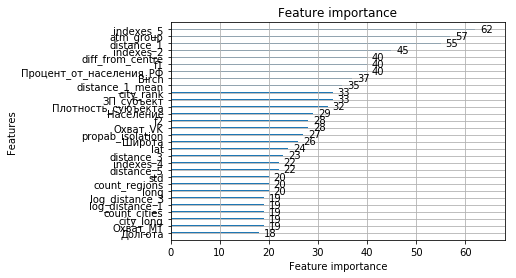

In [44]:
%matplotlib inline
lgb.plot_importance(gbm, max_num_features=30)

In [45]:
rmse(Y_valid, gbm.predict(X_valid))

0.03285172661311399

In [46]:
rmse(Y_valid, np.zeros(Y_valid.shape[0]))

0.09529975899864526

In [47]:
X_test = X[~X.isTrain][['atm_group','lat', 'long', 'distance_1',
                    'distance_2',  'distance_3',  'distance_4', 'distance_5',
                    'indexes_5', 'mean', 'city','Широта', 'Долгота','Население',
                    'indexes_2','indexes_4','ЗП субъект','Охват MT','Признак центра района или региона',
                  'Процент от населения РФ','Плотность суюъекта','Охват VK','Покупки','Планы на вечер','ФО','Субъект','Население субъекта',
                 'банкомат', 'Банк ВТБ', 'отделение', 'Сбербанк России', 'Росбанк', 'Россельхозбанк', 'Альфа-Банк', 'Газпромбанк', 'Магнит', 'Лента', 'Пятёрочка', 'М.Видео', 'Qiwi', 'Салон-магазин МТС', 'АК Барс банк', 'DNS', 'Билайн', 'МАРИЯ-РА', 'платежный терминал', 'Эльдорадо', 'Fix Price', 'Western Union', 'Спортмастер', 'Юнистрим', 'Бургер Кинг', 'Совкомбанк', 'Связной', 'Золотая Корона', 'Tele2', 'МегаФон', 'Аптека', 'Евросеть', 'Ашан', 'Дикси', 'Макдоналдс', 'KFC', 'Банк Открытие', "О'КЕЙ", 'Детский мир', 'Много мебели', 'Будь Здоров', 'Магнит Косметик', 'пункт выдачи', 'Росгосстрах', 'SPAR', 'Райффайзенбанк', 'Промсвязьбанк', 'центр', 'Магазин', 'офис', 'банк', 'Торговый', 'Салон', 'Компания', 'Управление', 'области', 'почтовой', 'ТЦ', 'Аптека', 'Больница', 'красоты', 'Сервис', 'Студия', 'Городская', 'Нотариус', 'Вокзал', 'Агентство', 'Институт', 'поликлиника', 'Кафе', 'Клуб', 'Парк', 'Мастерская', 'Университет', 'Завод', 'Администрац', 'Суши', 'Школа', 'Фото', 'Бар', 'Парикмахерская', 'Клиника', 'Отель', 'ТРЦ', 'Мебель', 'Супермаркет', 'Гостиница', 'Аэропорт',
                        'Охват MT 05',
                       'Аптеки_50м','Аэропорты_50м','Банки_50м','Бары_50м','Больницы_50м','Детские сады_50м','ФНС_50м','Кафе_50м','Кинотеатры_50м','Коворкинги_50м',
                        'Колледжи_50м','Пабы_50м','Рестораны_50м','Родильные дома_50м','Рынки_50м','Театры_50м','Metro C&C_50м','Spar_50м','Карусель_50м','Комус_50м',
                        'Лента_50м','Магнит Косметик_50м','Окей_50м','Перекресток_50м','Рубль Бум_50м','Ярче_50м','ТЦ_50м','Университеты_50м','Фитнес-центры_50м',
                        'Школы_50м',
                       'Аптеки_100м','Аэропорты_100м','Банки_100м','Бары_100м','Больницы_100м','Детские сады_100м','ФНС_100м','Кафе_100м','Кинотеатры_100м','Коворкинги_100м',
                        'Колледжи_100м','Пабы_100м','Рестораны_100м','Родильные дома_100м','Рынки_100м','Театры_100м','Metro C&C_100м','Spar_100м','Карусель_100м','Комус_100м',
                        'Лента_100м','Магнит Косметик_100м','Окей_100м','Перекресток_100м','Рубль Бум_100м','Ярче_100м','ТЦ_100м','Университеты_100м','Фитнес-центры_100м',
                        'Школы_100м',
                        'Аптеки_250м','Аэропорты_250м','Банки_250м','Бары_250м','Больницы_250м','Детские сады_250м','ФНС_250м','Кафе_250м','Кинотеатры_250м','Коворкинги_250м',
                        'Колледжи_250м','Пабы_250м','Рестораны_250м','Родильные дома_250м','Рынки_250м','Театры_250м','Metro C&C_250м','Spar_250м','Карусель_250м','Комус_250м',
                        'Лента_250м','Магнит Косметик_250м','Окей_250м','Перекресток_250м','Рубль Бум_250м','Ярче_250м','ТЦ_250м','Университеты_250м','Фитнес-центры_250м',
                        'Школы_250м',
                  'f1', 'f2',
                   'city_lat','city_long','diff_from_centre','count_cities','count_regions','distance_bear1','indexes_bear1','log_distance_1','distance_bear2','indexes_bear2','log_distance_2','distance_bear3','indexes_bear3','log_distance_3','distance_bear4','indexes_bear4','log_distance_4','distance_bear5','indexes_bear5','log_distance_5','median','std','coords_pca','city_rank','city_type_rank','KMeans','MiniBatchKMeans','DBSCAN','Birch','MeanShift','dbcluster','propab_isolation','distance_1_min','distance_1_max','distance_1_mean','distance_1_median','distance_1_std','distance_1_skew','distance_2_min','distance_2_max','distance_2_mean','distance_2_median','distance_2_std','distance_2_skew','distance_3_min','distance_3_max','distance_3_mean','distance_3_median','distance_3_std','distance_3_skew','distance_4_min','distance_4_max','distance_4_mean','distance_4_median','distance_4_std','distance_4_skew','propab_isolation_min','propab_isolation_max','propab_isolation_mean','propab_isolation_median','propab_isolation_std','propab_isolation_skew','distance_1__absolute_sum_of_changes','distance_1__count_above_mean','distance_1__kurtosis','distance_1__length','distance_1__longest_strike_above_mean','distance_1__longest_strike_below_mean','distance_1__mean_abs_change','distance_1__mean_change','distance_1__mean_second_derivative_central','distance_2__absolute_sum_of_changes','distance_2__count_above_mean','distance_2__kurtosis','distance_2__length','distance_2__longest_strike_above_mean','distance_2__longest_strike_below_mean','distance_2__mean_abs_change','distance_2__mean_change','distance_2__mean_second_derivative_central','distance_3__absolute_sum_of_changes','distance_3__count_above_mean','distance_3__kurtosis','distance_3__length','distance_3__longest_strike_above_mean','distance_3__longest_strike_below_mean','distance_3__mean_abs_change','distance_3__mean_change','distance_3__mean_second_derivative_central','distance_4__absolute_sum_of_changes','distance_4__count_above_mean','distance_4__kurtosis','distance_4__length','distance_4__longest_strike_above_mean','distance_4__longest_strike_below_mean','distance_4__mean_abs_change','distance_4__mean_change','distance_4__mean_second_derivative_central']]  
#                   'distance_bear1','indexes_bear1','distance_bear2','indexes_bear2','distance_bear3','indexes_bear3','distance_bear4','indexes_bear4','distance_bear5','indexes_bear5','median','std','coords_pca','KMeans','MiniBatchKMeans','DBSCAN','Birch','MeanShift','dbcluster','propab_isolation']] #,
#                   'гео_ц1', 'гео_ц2', 'гео_д1', 'гео_д2', 'Признак центра района или региона', 'count', 'indexes_1', 'indexes_3',  'count_b',  'owner',  'Охват VK cat', 'f3',  'f4',  'f5',  'f6',  'f7',
#                 'indexes_1_log__', 'indexes_2_log__', 'indexes_3_log__', 'indexes_4_log__', 'indexes_5_log__', 'f1_log__', 'гео_д1_log__', 'гео_д2_log__', 'Охват MT 05_log__', 'Охват VK_log__', 'Охват MT_log__', 'distance_1_log__', 'distance_2_log__', 'distance_3_log__', 'distance_4_log__', 'distance_5_log__',
#                   'indexes_1_drob_', 'indexes_2_drob_', 'indexes_3_drob_', 'indexes_4_drob_', 'indexes_5_drob_', 'f1_drob_', 'гео_д1_drob_', 'гео_д2_drob_', 'Охват MT 05_drob_', 'Охват VK_drob_', 'Охват MT_drob_', 'distance_1_drob_', 'distance_2_drob_', 'distance_3_drob_', 'distance_4_drob_', 'distance_5_drob_',
#                        'distance_1_cat','distance_2_cat','distance_3_cat','distance_4_cat','distance_5_cat']] #'гео_ц1', 'гео_ц2', 'гео_д1', 'гео_д2', 'Охват MT 05'

# X_test = X[~X.isTrain][['atm_group', 'lat', 'lat', 'long', 'long', 'distance_1', 'distance_2', 'distance_3', 'distance_4', 'distance_5', 'indexes_5', 'mean', 'city', 'Широта', 'Долгота', 'Население', 'indexes_2', 'indexes_4', 'ЗП субъект', 'Охват MT', 'Признак центра района или региона', 'Процент от населения РФ', 'Плотность суюъекта', 'Охват VK', 'Покупки', 'Планы на вечер', 'ФО', 'Субъект', 'Население субъекта', 'банкомат', 'Банк ВТБ', 'отделение', 'Сбербанк России', 'Росбанк', 'Россельхозбанк', 'Альфа-Банк', 'Газпромбанк', 'Магнит', 'Лента', 'Пятёрочка', 'М.Видео', 'Qiwi', 'Салон-магазин МТС', 'DNS', 'Билайн', 'платежный терминал', 'Эльдорадо', 'Fix Price', 'Western Union', 'Связной', 'Золотая Корона', 'МегаФон', 'Аптека', 'Евросеть', 'Ашан', 'Райффайзенбанк', 'центр', 'Магазин', 'офис', 'банк', 'Торговый', 'Салон', 'Компания', 'Управление', 'области', 'почтовой', 'ТЦ', 'Больница', 'Сервис', 'Студия', 'Нотариус', 'Вокзал', 'Агентство', 'Институт', 'Кафе', 'Парк', 'Мастерская', 'Университет', 'Завод', 'Суши', 'Школа', 'Фото', 'Бар', 'Парикмахерская', 'Клиника', 'Отель', 'Супермаркет', 'Гостиница', 'Охват MT 05', 'Аптеки_50м', 'Банки_50м', 'Бары_50м', 'Больницы_50м', 'Кафе_50м', 'Кинотеатры_50м', 'Коворкинги_50м', 'Рестораны_50м', 'Metro C&C_50м', 'Spar_50м', 'Карусель_50м', 'Лента_50м', 'Магнит Косметик_50м', 'Перекресток_50м', 'ТЦ_50м', 'Университеты_50м', 'Аптеки_100м', 'Банки_100м', 'Бары_100м', 'Больницы_100м', 'Детские сады_100м', 'ФНС_100м', 'Кафе_100м', 'Кинотеатры_100м', 'Колледжи_100м', 'Пабы_100м', 'Рестораны_100м', 'Рынки_100м', 'Карусель_100м', 'Магнит Косметик_100м', 'Окей_100м', 'Перекресток_100м', 'ТЦ_100м', 'Университеты_100м', 'Фитнес-центры_100м', 'Школы_100м', 'Аптеки_250м', 'Банки_250м', 'Бары_250м', 'Больницы_250м', 'Детские сады_250м', 'ФНС_250м', 'Кафе_250м', 'Кинотеатры_250м', 'Коворкинги_250м', 'Колледжи_250м', 'Пабы_250м', 'Рестораны_250м', 'Рынки_250м', 'Театры_250м', 'Spar_250м', 'Магнит Косметик_250м', 'Перекресток_250м', 'Рубль Бум_250м', 'Ярче_250м', 'ТЦ_250м', 'Университеты_250м', 'Фитнес-центры_250м', 'Школы_250м', 'f1', 'f2']]

X_test = X_test.fillna(-1)

In [48]:
print (X_test.shape, test_ind.shape)
submit = pd.DataFrame(gbm.predict(X_test), index=test_ind.index,columns=['target'])
submit.to_csv('submit_gbm.csv')

(2504, 308) (2504, 6)


Other models

In [49]:
import xgboost
X_train_xgb,Y_train_xgb = X_train.values,Y_train.values
Y_valid_xgb,X_valid_xgb = Y_valid.values,X_valid.values
X_test_xgb = X_test.values

xgb = xgboost.XGBRegressor(n_estimators=230, learning_rate=0.06, gamma=0, subsample=0.75,#n_estimators=100 #learning_rate=0.08
                           colsample_bytree=0.6, max_depth=9, random_state=1) #colsample_bytree=1 max_depth=7
xgb.fit(X_train_xgb,Y_train_xgb)

rmse(Y_valid_xgb, xgb.predict(X_valid_xgb)) 
# локальную точность проверяю на тест сайзе 0.15 и лучшая точность на иксгбусте 0.041970700818580356

0.027813785546643193

In [50]:
# тут пробовал уменьшать размерность данных
# from sklearn.decomposition import PCA

# pca = PCA(n_components=200)
# fit = pca.fit(X_.values)
# features = fit.transform(X_.values)

# X_train, X_valid, Y_train, Y_valid = train_test_split(features, Y_, test_size=0.15, random_state=1)

# xgb.fit(X_train,Y_train)

# rmse(Y_valid, xgb.predict(X_valid))

In [51]:
submit2 = pd.DataFrame(xgb.predict(X_test_xgb), index=test_ind.index,columns=['target'])
submit2.to_csv('submit_xgb.csv')

In [52]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [53]:
rfr_model = RandomForestRegressor(n_estimators=70, random_state=1) #2500 лучше ставить 10000
rfr_model.fit(X_train, Y_train)

submit4 = pd.DataFrame(rfr_model.predict(X_test), index=test_ind.index,columns=['target'])
submit4.to_csv('submit_rfr.csv')

rmse(Y_valid, rfr_model.predict(X_valid)) #0.04308566997954454 на 2500

0.03087708432950634

In [54]:
etr_model = ExtraTreesRegressor(n_estimators=250, random_state=1)
etr_model.fit(X_train, Y_train)

submit5 = pd.DataFrame(etr_model.predict(X_test), index=test_ind.index,columns=['target'])
submit5.to_csv('submit_etr.csv')

rmse(Y_valid, etr_model.predict(X_valid)) #0.043944132726558366 на n_estimators=2500

0.03155048428559845

In [55]:
cat_model = CatBoostRegressor(iterations=2500,random_seed = 1)
cat_model.fit(X_train, Y_train)

submit6 = pd.DataFrame(cat_model.predict(X_test), index=test_ind.index,columns=['target'])
submit6.to_csv('submit_cat.csv')

rmse(Y_valid, cat_model.predict(X_valid)) #0.04322924609490536 на 2500 iterations

0:	learn: 0.0841397	total: 130ms	remaining: 5m 24s
1:	learn: 0.0824743	total: 194ms	remaining: 4m 1s
2:	learn: 0.0809239	total: 255ms	remaining: 3m 31s
3:	learn: 0.0794282	total: 316ms	remaining: 3m 17s
4:	learn: 0.0780130	total: 377ms	remaining: 3m 8s
5:	learn: 0.0766168	total: 417ms	remaining: 2m 53s
6:	learn: 0.0753103	total: 483ms	remaining: 2m 52s
7:	learn: 0.0740305	total: 547ms	remaining: 2m 50s
8:	learn: 0.0727597	total: 611ms	remaining: 2m 49s
9:	learn: 0.0716062	total: 682ms	remaining: 2m 49s
10:	learn: 0.0705146	total: 760ms	remaining: 2m 51s
11:	learn: 0.0694353	total: 851ms	remaining: 2m 56s
12:	learn: 0.0684023	total: 919ms	remaining: 2m 55s
13:	learn: 0.0674327	total: 984ms	remaining: 2m 54s
14:	learn: 0.0664958	total: 1.05s	remaining: 2m 53s
15:	learn: 0.0655815	total: 1.12s	remaining: 2m 54s
16:	learn: 0.0647039	total: 1.19s	remaining: 2m 53s
17:	learn: 0.0638930	total: 1.23s	remaining: 2m 48s
18:	learn: 0.0630984	total: 1.29s	remaining: 2m 48s
19:	learn: 0.0623010	tot

158:	learn: 0.0445420	total: 9.81s	remaining: 2m 24s
159:	learn: 0.0445366	total: 9.88s	remaining: 2m 24s
160:	learn: 0.0445242	total: 9.95s	remaining: 2m 24s
161:	learn: 0.0444990	total: 10s	remaining: 2m 24s
162:	learn: 0.0444887	total: 10.1s	remaining: 2m 24s
163:	learn: 0.0444684	total: 10.2s	remaining: 2m 24s
164:	learn: 0.0444531	total: 10.2s	remaining: 2m 24s
165:	learn: 0.0444419	total: 10.3s	remaining: 2m 24s
166:	learn: 0.0444156	total: 10.3s	remaining: 2m 24s
167:	learn: 0.0443876	total: 10.4s	remaining: 2m 24s
168:	learn: 0.0443746	total: 10.4s	remaining: 2m 24s
169:	learn: 0.0443551	total: 10.5s	remaining: 2m 24s
170:	learn: 0.0443340	total: 10.6s	remaining: 2m 23s
171:	learn: 0.0443146	total: 10.6s	remaining: 2m 23s
172:	learn: 0.0442988	total: 10.7s	remaining: 2m 23s
173:	learn: 0.0442820	total: 10.7s	remaining: 2m 23s
174:	learn: 0.0442652	total: 10.8s	remaining: 2m 23s
175:	learn: 0.0442486	total: 10.9s	remaining: 2m 23s
176:	learn: 0.0442345	total: 10.9s	remaining: 2m

316:	learn: 0.0427267	total: 20s	remaining: 2m 18s
317:	learn: 0.0427133	total: 20.1s	remaining: 2m 17s
318:	learn: 0.0427037	total: 20.2s	remaining: 2m 17s
319:	learn: 0.0426975	total: 20.2s	remaining: 2m 17s
320:	learn: 0.0426879	total: 20.3s	remaining: 2m 17s
321:	learn: 0.0426714	total: 20.3s	remaining: 2m 17s
322:	learn: 0.0426710	total: 20.4s	remaining: 2m 17s
323:	learn: 0.0426646	total: 20.4s	remaining: 2m 17s
324:	learn: 0.0426512	total: 20.5s	remaining: 2m 17s
325:	learn: 0.0426411	total: 20.6s	remaining: 2m 17s
326:	learn: 0.0426255	total: 20.7s	remaining: 2m 17s
327:	learn: 0.0426039	total: 20.7s	remaining: 2m 17s
328:	learn: 0.0426036	total: 20.7s	remaining: 2m 16s
329:	learn: 0.0425872	total: 20.8s	remaining: 2m 16s
330:	learn: 0.0425825	total: 20.9s	remaining: 2m 16s
331:	learn: 0.0425740	total: 20.9s	remaining: 2m 16s
332:	learn: 0.0425669	total: 21s	remaining: 2m 16s
333:	learn: 0.0425536	total: 21.1s	remaining: 2m 17s
334:	learn: 0.0425408	total: 21.2s	remaining: 2m 1

473:	learn: 0.0412078	total: 30.6s	remaining: 2m 10s
474:	learn: 0.0412043	total: 30.7s	remaining: 2m 10s
475:	learn: 0.0411978	total: 30.7s	remaining: 2m 10s
476:	learn: 0.0411974	total: 30.8s	remaining: 2m 10s
477:	learn: 0.0411860	total: 30.8s	remaining: 2m 10s
478:	learn: 0.0411759	total: 30.9s	remaining: 2m 10s
479:	learn: 0.0411663	total: 31s	remaining: 2m 10s
480:	learn: 0.0411572	total: 31s	remaining: 2m 10s
481:	learn: 0.0411548	total: 31.1s	remaining: 2m 10s
482:	learn: 0.0411464	total: 31.1s	remaining: 2m 9s
483:	learn: 0.0411387	total: 31.2s	remaining: 2m 9s
484:	learn: 0.0411335	total: 31.2s	remaining: 2m 9s
485:	learn: 0.0411229	total: 31.3s	remaining: 2m 9s
486:	learn: 0.0411097	total: 31.4s	remaining: 2m 9s
487:	learn: 0.0411024	total: 31.4s	remaining: 2m 9s
488:	learn: 0.0410948	total: 31.5s	remaining: 2m 9s
489:	learn: 0.0410891	total: 31.5s	remaining: 2m 9s
490:	learn: 0.0410745	total: 31.6s	remaining: 2m 9s
491:	learn: 0.0410720	total: 31.7s	remaining: 2m 9s
492:	le

632:	learn: 0.0401242	total: 40.6s	remaining: 1m 59s
633:	learn: 0.0401199	total: 40.7s	remaining: 1m 59s
634:	learn: 0.0401140	total: 40.8s	remaining: 1m 59s
635:	learn: 0.0401109	total: 40.9s	remaining: 1m 59s
636:	learn: 0.0401099	total: 41s	remaining: 1m 59s
637:	learn: 0.0401070	total: 41s	remaining: 1m 59s
638:	learn: 0.0400884	total: 41.1s	remaining: 1m 59s
639:	learn: 0.0400790	total: 41.2s	remaining: 1m 59s
640:	learn: 0.0400706	total: 41.2s	remaining: 1m 59s
641:	learn: 0.0400609	total: 41.3s	remaining: 1m 59s
642:	learn: 0.0400520	total: 41.4s	remaining: 1m 59s
643:	learn: 0.0400433	total: 41.4s	remaining: 1m 59s
644:	learn: 0.0400378	total: 41.5s	remaining: 1m 59s
645:	learn: 0.0400318	total: 41.6s	remaining: 1m 59s
646:	learn: 0.0400254	total: 41.7s	remaining: 1m 59s
647:	learn: 0.0400232	total: 41.7s	remaining: 1m 59s
648:	learn: 0.0400218	total: 41.8s	remaining: 1m 59s
649:	learn: 0.0400204	total: 41.9s	remaining: 1m 59s
650:	learn: 0.0400038	total: 41.9s	remaining: 1m 5

789:	learn: 0.0392248	total: 52.1s	remaining: 1m 52s
790:	learn: 0.0392151	total: 52.1s	remaining: 1m 52s
791:	learn: 0.0392069	total: 52.2s	remaining: 1m 52s
792:	learn: 0.0391941	total: 52.3s	remaining: 1m 52s
793:	learn: 0.0391874	total: 52.4s	remaining: 1m 52s
794:	learn: 0.0391725	total: 52.4s	remaining: 1m 52s
795:	learn: 0.0391616	total: 52.5s	remaining: 1m 52s
796:	learn: 0.0391607	total: 52.6s	remaining: 1m 52s
797:	learn: 0.0391600	total: 52.6s	remaining: 1m 52s
798:	learn: 0.0391562	total: 52.7s	remaining: 1m 52s
799:	learn: 0.0391513	total: 52.7s	remaining: 1m 52s
800:	learn: 0.0391482	total: 52.8s	remaining: 1m 51s
801:	learn: 0.0391466	total: 52.8s	remaining: 1m 51s
802:	learn: 0.0391449	total: 52.9s	remaining: 1m 51s
803:	learn: 0.0391392	total: 53s	remaining: 1m 51s
804:	learn: 0.0391333	total: 53s	remaining: 1m 51s
805:	learn: 0.0391294	total: 53.1s	remaining: 1m 51s
806:	learn: 0.0391279	total: 53.2s	remaining: 1m 51s
807:	learn: 0.0391240	total: 53.3s	remaining: 1m 5

949:	learn: 0.0384648	total: 1m 2s	remaining: 1m 42s
950:	learn: 0.0384550	total: 1m 2s	remaining: 1m 42s
951:	learn: 0.0384395	total: 1m 2s	remaining: 1m 41s
952:	learn: 0.0384392	total: 1m 2s	remaining: 1m 41s
953:	learn: 0.0384358	total: 1m 2s	remaining: 1m 41s
954:	learn: 0.0384355	total: 1m 2s	remaining: 1m 41s
955:	learn: 0.0384349	total: 1m 2s	remaining: 1m 41s
956:	learn: 0.0384315	total: 1m 3s	remaining: 1m 41s
957:	learn: 0.0384308	total: 1m 3s	remaining: 1m 41s
958:	learn: 0.0384255	total: 1m 3s	remaining: 1m 41s
959:	learn: 0.0384168	total: 1m 3s	remaining: 1m 41s
960:	learn: 0.0384132	total: 1m 3s	remaining: 1m 41s
961:	learn: 0.0384071	total: 1m 3s	remaining: 1m 41s
962:	learn: 0.0384050	total: 1m 3s	remaining: 1m 41s
963:	learn: 0.0383975	total: 1m 3s	remaining: 1m 41s
964:	learn: 0.0383951	total: 1m 3s	remaining: 1m 41s
965:	learn: 0.0383903	total: 1m 3s	remaining: 1m 41s
966:	learn: 0.0383898	total: 1m 3s	remaining: 1m 40s
967:	learn: 0.0383865	total: 1m 3s	remaining: 

1103:	learn: 0.0378714	total: 1m 12s	remaining: 1m 31s
1104:	learn: 0.0378643	total: 1m 12s	remaining: 1m 31s
1105:	learn: 0.0378598	total: 1m 12s	remaining: 1m 31s
1106:	learn: 0.0378595	total: 1m 12s	remaining: 1m 31s
1107:	learn: 0.0378584	total: 1m 12s	remaining: 1m 31s
1108:	learn: 0.0378566	total: 1m 12s	remaining: 1m 31s
1109:	learn: 0.0378554	total: 1m 12s	remaining: 1m 31s
1110:	learn: 0.0378543	total: 1m 12s	remaining: 1m 30s
1111:	learn: 0.0378465	total: 1m 12s	remaining: 1m 30s
1112:	learn: 0.0378451	total: 1m 12s	remaining: 1m 30s
1113:	learn: 0.0378426	total: 1m 12s	remaining: 1m 30s
1114:	learn: 0.0378384	total: 1m 13s	remaining: 1m 30s
1115:	learn: 0.0378351	total: 1m 13s	remaining: 1m 30s
1116:	learn: 0.0378348	total: 1m 13s	remaining: 1m 30s
1117:	learn: 0.0378315	total: 1m 13s	remaining: 1m 30s
1118:	learn: 0.0378310	total: 1m 13s	remaining: 1m 30s
1119:	learn: 0.0378309	total: 1m 13s	remaining: 1m 30s
1120:	learn: 0.0378293	total: 1m 13s	remaining: 1m 30s
1121:	lear

1252:	learn: 0.0374695	total: 1m 21s	remaining: 1m 21s
1253:	learn: 0.0374646	total: 1m 21s	remaining: 1m 21s
1254:	learn: 0.0374618	total: 1m 21s	remaining: 1m 21s
1255:	learn: 0.0374602	total: 1m 22s	remaining: 1m 21s
1256:	learn: 0.0374528	total: 1m 22s	remaining: 1m 21s
1257:	learn: 0.0374522	total: 1m 22s	remaining: 1m 21s
1258:	learn: 0.0374497	total: 1m 22s	remaining: 1m 21s
1259:	learn: 0.0374463	total: 1m 22s	remaining: 1m 20s
1260:	learn: 0.0374459	total: 1m 22s	remaining: 1m 20s
1261:	learn: 0.0374457	total: 1m 22s	remaining: 1m 20s
1262:	learn: 0.0374397	total: 1m 22s	remaining: 1m 20s
1263:	learn: 0.0374357	total: 1m 22s	remaining: 1m 20s
1264:	learn: 0.0374351	total: 1m 22s	remaining: 1m 20s
1265:	learn: 0.0374348	total: 1m 22s	remaining: 1m 20s
1266:	learn: 0.0374347	total: 1m 22s	remaining: 1m 20s
1267:	learn: 0.0374319	total: 1m 22s	remaining: 1m 20s
1268:	learn: 0.0374261	total: 1m 22s	remaining: 1m 20s
1269:	learn: 0.0374111	total: 1m 22s	remaining: 1m 20s
1270:	lear

1401:	learn: 0.0370091	total: 1m 31s	remaining: 1m 11s
1402:	learn: 0.0370087	total: 1m 31s	remaining: 1m 11s
1403:	learn: 0.0370080	total: 1m 31s	remaining: 1m 11s
1404:	learn: 0.0370067	total: 1m 31s	remaining: 1m 11s
1405:	learn: 0.0370035	total: 1m 31s	remaining: 1m 11s
1406:	learn: 0.0370033	total: 1m 31s	remaining: 1m 11s
1407:	learn: 0.0369977	total: 1m 31s	remaining: 1m 10s
1408:	learn: 0.0369946	total: 1m 31s	remaining: 1m 10s
1409:	learn: 0.0369927	total: 1m 31s	remaining: 1m 10s
1410:	learn: 0.0369862	total: 1m 31s	remaining: 1m 10s
1411:	learn: 0.0369831	total: 1m 31s	remaining: 1m 10s
1412:	learn: 0.0369746	total: 1m 31s	remaining: 1m 10s
1413:	learn: 0.0369666	total: 1m 31s	remaining: 1m 10s
1414:	learn: 0.0369629	total: 1m 31s	remaining: 1m 10s
1415:	learn: 0.0369580	total: 1m 32s	remaining: 1m 10s
1416:	learn: 0.0369551	total: 1m 32s	remaining: 1m 10s
1417:	learn: 0.0369520	total: 1m 32s	remaining: 1m 10s
1418:	learn: 0.0369432	total: 1m 32s	remaining: 1m 10s
1419:	lear

1555:	learn: 0.0365697	total: 1m 41s	remaining: 1m 1s
1556:	learn: 0.0365661	total: 1m 41s	remaining: 1m 1s
1557:	learn: 0.0365647	total: 1m 41s	remaining: 1m 1s
1558:	learn: 0.0365646	total: 1m 41s	remaining: 1m 1s
1559:	learn: 0.0365644	total: 1m 41s	remaining: 1m 1s
1560:	learn: 0.0365643	total: 1m 41s	remaining: 1m
1561:	learn: 0.0365625	total: 1m 41s	remaining: 1m
1562:	learn: 0.0365619	total: 1m 41s	remaining: 1m
1563:	learn: 0.0365582	total: 1m 41s	remaining: 1m
1564:	learn: 0.0365574	total: 1m 41s	remaining: 1m
1565:	learn: 0.0365572	total: 1m 41s	remaining: 1m
1566:	learn: 0.0365553	total: 1m 41s	remaining: 1m
1567:	learn: 0.0365548	total: 1m 41s	remaining: 1m
1568:	learn: 0.0365546	total: 1m 41s	remaining: 1m
1569:	learn: 0.0365538	total: 1m 41s	remaining: 1m
1570:	learn: 0.0365535	total: 1m 41s	remaining: 1m
1571:	learn: 0.0365473	total: 1m 42s	remaining: 1m
1572:	learn: 0.0365467	total: 1m 42s	remaining: 1m
1573:	learn: 0.0365456	total: 1m 42s	remaining: 1m
1574:	learn: 0.0

1710:	learn: 0.0362255	total: 1m 50s	remaining: 51s
1711:	learn: 0.0362177	total: 1m 50s	remaining: 50.9s
1712:	learn: 0.0362162	total: 1m 50s	remaining: 50.8s
1713:	learn: 0.0362153	total: 1m 50s	remaining: 50.8s
1714:	learn: 0.0362128	total: 1m 50s	remaining: 50.7s
1715:	learn: 0.0362124	total: 1m 50s	remaining: 50.6s
1716:	learn: 0.0362090	total: 1m 50s	remaining: 50.6s
1717:	learn: 0.0362088	total: 1m 50s	remaining: 50.5s
1718:	learn: 0.0362087	total: 1m 51s	remaining: 50.4s
1719:	learn: 0.0362082	total: 1m 51s	remaining: 50.4s
1720:	learn: 0.0362073	total: 1m 51s	remaining: 50.3s
1721:	learn: 0.0361997	total: 1m 51s	remaining: 50.2s
1722:	learn: 0.0361994	total: 1m 51s	remaining: 50.2s
1723:	learn: 0.0361992	total: 1m 51s	remaining: 50.1s
1724:	learn: 0.0361964	total: 1m 51s	remaining: 50s
1725:	learn: 0.0361940	total: 1m 51s	remaining: 50s
1726:	learn: 0.0361905	total: 1m 51s	remaining: 49.9s
1727:	learn: 0.0361903	total: 1m 51s	remaining: 49.8s
1728:	learn: 0.0361874	total: 1m 5

1864:	learn: 0.0359102	total: 2m 1s	remaining: 41.3s
1865:	learn: 0.0359079	total: 2m 1s	remaining: 41.3s
1866:	learn: 0.0359075	total: 2m 1s	remaining: 41.2s
1867:	learn: 0.0359072	total: 2m 1s	remaining: 41.1s
1868:	learn: 0.0359068	total: 2m 1s	remaining: 41.1s
1869:	learn: 0.0359063	total: 2m 1s	remaining: 41s
1870:	learn: 0.0359056	total: 2m 1s	remaining: 40.9s
1871:	learn: 0.0358981	total: 2m 1s	remaining: 40.9s
1872:	learn: 0.0358977	total: 2m 1s	remaining: 40.8s
1873:	learn: 0.0358942	total: 2m 1s	remaining: 40.7s
1874:	learn: 0.0358939	total: 2m 2s	remaining: 40.7s
1875:	learn: 0.0358936	total: 2m 2s	remaining: 40.6s
1876:	learn: 0.0358889	total: 2m 2s	remaining: 40.5s
1877:	learn: 0.0358884	total: 2m 2s	remaining: 40.5s
1878:	learn: 0.0358879	total: 2m 2s	remaining: 40.4s
1879:	learn: 0.0358799	total: 2m 2s	remaining: 40.3s
1880:	learn: 0.0358775	total: 2m 2s	remaining: 40.3s
1881:	learn: 0.0358705	total: 2m 2s	remaining: 40.2s
1882:	learn: 0.0358704	total: 2m 2s	remaining: 4

2020:	learn: 0.0355825	total: 2m 11s	remaining: 31.3s
2021:	learn: 0.0355816	total: 2m 11s	remaining: 31.2s
2022:	learn: 0.0355794	total: 2m 12s	remaining: 31.1s
2023:	learn: 0.0355752	total: 2m 12s	remaining: 31.1s
2024:	learn: 0.0355614	total: 2m 12s	remaining: 31s
2025:	learn: 0.0355552	total: 2m 12s	remaining: 30.9s
2026:	learn: 0.0355528	total: 2m 12s	remaining: 30.9s
2027:	learn: 0.0355511	total: 2m 12s	remaining: 30.8s
2028:	learn: 0.0355496	total: 2m 12s	remaining: 30.7s
2029:	learn: 0.0355477	total: 2m 12s	remaining: 30.7s
2030:	learn: 0.0355474	total: 2m 12s	remaining: 30.6s
2031:	learn: 0.0355473	total: 2m 12s	remaining: 30.6s
2032:	learn: 0.0355466	total: 2m 12s	remaining: 30.5s
2033:	learn: 0.0355447	total: 2m 12s	remaining: 30.4s
2034:	learn: 0.0355437	total: 2m 12s	remaining: 30.4s
2035:	learn: 0.0355435	total: 2m 12s	remaining: 30.3s
2036:	learn: 0.0355434	total: 2m 12s	remaining: 30.2s
2037:	learn: 0.0355432	total: 2m 13s	remaining: 30.2s
2038:	learn: 0.0355419	total: 

2175:	learn: 0.0352805	total: 2m 22s	remaining: 21.2s
2176:	learn: 0.0352794	total: 2m 22s	remaining: 21.2s
2177:	learn: 0.0352790	total: 2m 22s	remaining: 21.1s
2178:	learn: 0.0352782	total: 2m 22s	remaining: 21s
2179:	learn: 0.0352776	total: 2m 22s	remaining: 21s
2180:	learn: 0.0352713	total: 2m 22s	remaining: 20.9s
2181:	learn: 0.0352634	total: 2m 22s	remaining: 20.8s
2182:	learn: 0.0352632	total: 2m 23s	remaining: 20.8s
2183:	learn: 0.0352625	total: 2m 23s	remaining: 20.7s
2184:	learn: 0.0352620	total: 2m 23s	remaining: 20.6s
2185:	learn: 0.0352620	total: 2m 23s	remaining: 20.6s
2186:	learn: 0.0352617	total: 2m 23s	remaining: 20.5s
2187:	learn: 0.0352609	total: 2m 23s	remaining: 20.5s
2188:	learn: 0.0352608	total: 2m 23s	remaining: 20.4s
2189:	learn: 0.0352539	total: 2m 23s	remaining: 20.3s
2190:	learn: 0.0352537	total: 2m 23s	remaining: 20.3s
2191:	learn: 0.0352522	total: 2m 23s	remaining: 20.2s
2192:	learn: 0.0352518	total: 2m 23s	remaining: 20.1s
2193:	learn: 0.0352484	total: 2m

2330:	learn: 0.0350394	total: 2m 33s	remaining: 11.1s
2331:	learn: 0.0350393	total: 2m 33s	remaining: 11.1s
2332:	learn: 0.0350393	total: 2m 33s	remaining: 11s
2333:	learn: 0.0350392	total: 2m 34s	remaining: 11s
2334:	learn: 0.0350388	total: 2m 34s	remaining: 10.9s
2335:	learn: 0.0350387	total: 2m 34s	remaining: 10.8s
2336:	learn: 0.0350369	total: 2m 34s	remaining: 10.8s
2337:	learn: 0.0350368	total: 2m 34s	remaining: 10.7s
2338:	learn: 0.0350360	total: 2m 34s	remaining: 10.6s
2339:	learn: 0.0350350	total: 2m 34s	remaining: 10.6s
2340:	learn: 0.0350344	total: 2m 34s	remaining: 10.5s
2341:	learn: 0.0350314	total: 2m 34s	remaining: 10.4s
2342:	learn: 0.0350276	total: 2m 34s	remaining: 10.4s
2343:	learn: 0.0350275	total: 2m 34s	remaining: 10.3s
2344:	learn: 0.0350260	total: 2m 34s	remaining: 10.2s
2345:	learn: 0.0350259	total: 2m 34s	remaining: 10.2s
2346:	learn: 0.0350259	total: 2m 34s	remaining: 10.1s
2347:	learn: 0.0350256	total: 2m 35s	remaining: 10s
2348:	learn: 0.0350229	total: 2m 3

2483:	learn: 0.0347776	total: 2m 44s	remaining: 1.06s
2484:	learn: 0.0347774	total: 2m 44s	remaining: 995ms
2485:	learn: 0.0347773	total: 2m 44s	remaining: 928ms
2486:	learn: 0.0347764	total: 2m 44s	remaining: 862ms
2487:	learn: 0.0347757	total: 2m 44s	remaining: 796ms
2488:	learn: 0.0347754	total: 2m 45s	remaining: 729ms
2489:	learn: 0.0347713	total: 2m 45s	remaining: 663ms
2490:	learn: 0.0347711	total: 2m 45s	remaining: 597ms
2491:	learn: 0.0347698	total: 2m 45s	remaining: 530ms
2492:	learn: 0.0347698	total: 2m 45s	remaining: 464ms
2493:	learn: 0.0347688	total: 2m 45s	remaining: 398ms
2494:	learn: 0.0347671	total: 2m 45s	remaining: 331ms
2495:	learn: 0.0347662	total: 2m 45s	remaining: 265ms
2496:	learn: 0.0347610	total: 2m 45s	remaining: 199ms
2497:	learn: 0.0347566	total: 2m 45s	remaining: 133ms
2498:	learn: 0.0347541	total: 2m 45s	remaining: 66.3ms
2499:	learn: 0.0347526	total: 2m 45s	remaining: 0us


0.03205313325628338

In [56]:
rmse(Y_valid, (gbm.predict(X_valid)+xgb.predict(X_valid_xgb))/2)

0.029139100373281792

In [57]:
# на это ансамбле лучшая точность при тест сайзе 0.15 0.04132742791091593
# rmse(Y_valid, (gbm.predict(X_valid)+xgb.predict(X_valid_xgb)+cat_model.predict(X_valid)+etr_model.predict(X_valid)+rfr_model.predict(X_valid))/5.1)
# rmse(Y_valid, (0.1*xgb.predict(X_valid_xgb)+etr_model.predict(X_valid)+cat_model.predict(X_valid)+rfr_model.predict(X_valid))/3.1) #0.04189291401470533
print (rmse(Y_valid, (0.9*xgb.predict(X_valid_xgb)+0.9*etr_model.predict(X_valid)+cat_model.predict(X_valid)+0.5*rfr_model.predict(X_valid))/3.3)) #0.04133251009746562 а тест сайз 0.15
# print (rmse(Y_valid, (0.9*xgb.predict(X_valid_xgb)+0.9*etr_model.predict(X_valid)+0.5*rfr_model.predict(X_valid))/2.3))


# print ('ens')
# rmse(Y_valid, (0.9*xgb.predict(X_valid_xgb)+0.9*etr_model.predict(X_valid)+0.5*cat_model.predict(X_valid)+0.5*rfr_model.predict(X_valid))/2.8) #0.04170885496523346

# 0.027825573754977705 c дроп 54 на 0.01 - вероятно, лучшая засылка
# 0.03859157340977819 drop 54 0.15
# 0.038790858253147494 плюс логарифмы и доп фичи
# 0.038904094323055284 плюс дробные части
# 0.03892648072268594 добавили категоризацию в дистансы

# 0.02731893144203333 на 0.01 с добавлениями

0.02866818393578475


In [58]:
# сабмит этого ансамбля и засылаю на конкурс, добавление gbm ухудшало точность. Все модели, используемые ниже, ухудшают точность
# aaa = (gbm.predict(X_test)+xgb.predict(X_test_xgb)+cat_model.predict(X_test)+etr_model.predict(X_test)+rfr_model.predict(X_test))/5.1
# aaa = (0.1*xgb.predict(X_test_xgb)+etr_model.predict(X_test)+cat_model.predict(X_test)+rfr_model.predict(X_test))/3.1
aaa = (0.9*xgb.predict(X_test_xgb)+0.9*etr_model.predict(X_test)+cat_model.predict(X_test)+0.5*rfr_model.predict(X_test))/3.3
# aaa = 0.9*xgb.predict(X_test_xgb)+0.9*etr_model.predict(X_test)+0.5*cat_model.predict(X_test)+0.5*rfr_model.predict(X_test)/2.8
submit3 = pd.DataFrame(aaa, index=test_ind.index,columns=['target'])
submit3.to_csv('submit_ens_full_001_drop_54.csv')

In [59]:
# X_ = X[X.isTrain][['id','atm_group','lat', 'long', 'distance_1',
#                     'distance_2',  'distance_3',  'distance_4', 'distance_5',
#                     'indexes_5', 'mean', 'city','Широта', 'Долгота','Население',
#                     'indexes_2','indexes_4','ЗП субъект','Охват MT','Признак центра района или региона',
#                   'Процент от населения РФ','Плотность суюъекта','Охват VK','Покупки','Планы на вечер','ФО','Субъект','Население субъекта',
#                  'банкомат', 'Банк ВТБ', 'отделение', 'Сбербанк России', 'Росбанк', 'Россельхозбанк', 'Альфа-Банк', 'Газпромбанк', 'Магнит', 'Лента', 'Пятёрочка', 'М.Видео', 'Qiwi', 'Салон-магазин МТС', 'АК Барс банк', 'DNS', 'Билайн', 'МАРИЯ-РА', 'платежный терминал', 'Эльдорадо', 'Fix Price', 'Western Union', 'Спортмастер', 'Юнистрим', 'Бургер Кинг', 'Совкомбанк', 'Связной', 'Золотая Корона', 'Tele2', 'МегаФон', 'Аптека', 'Евросеть', 'Ашан', 'Дикси', 'Макдоналдс', 'KFC', 'Банк Открытие', "О'КЕЙ", 'Детский мир', 'Много мебели', 'Будь Здоров', 'Магнит Косметик', 'пункт выдачи', 'Росгосстрах', 'SPAR', 'Райффайзенбанк', 'Промсвязьбанк', 'центр', 'Магазин', 'офис', 'банк', 'Торговый', 'Салон', 'Компания', 'Управление', 'области', 'почтовой', 'ТЦ', 'Аптека', 'Больница', 'красоты', 'Сервис', 'Студия', 'Городская', 'Нотариус', 'Вокзал', 'Агентство', 'Институт', 'поликлиника', 'Кафе', 'Клуб', 'Парк', 'Мастерская', 'Университет', 'Завод', 'Администрац', 'Суши', 'Школа', 'Фото', 'Бар', 'Парикмахерская', 'Клиника', 'Отель', 'ТРЦ', 'Мебель', 'Супермаркет', 'Гостиница', 'Аэропорт',
#                         'Охват MT 05',
#                        'Аптеки_50м','Аэропорты_50м','Банки_50м','Бары_50м','Больницы_50м','Детские сады_50м','ФНС_50м','Кафе_50м','Кинотеатры_50м','Коворкинги_50м',
#                         'Колледжи_50м','Пабы_50м','Рестораны_50м','Родильные дома_50м','Рынки_50м','Театры_50м','Metro C&C_50м','Spar_50м','Карусель_50м','Комус_50м',
#                         'Лента_50м','Магнит Косметик_50м','Окей_50м','Перекресток_50м','Рубль Бум_50м','Ярче_50м','ТЦ_50м','Университеты_50м','Фитнес-центры_50м',
#                         'Школы_50м',
#                        'Аптеки_100м','Аэропорты_100м','Банки_100м','Бары_100м','Больницы_100м','Детские сады_100м','ФНС_100м','Кафе_100м','Кинотеатры_100м','Коворкинги_100м',
#                         'Колледжи_100м','Пабы_100м','Рестораны_100м','Родильные дома_100м','Рынки_100м','Театры_100м','Metro C&C_100м','Spar_100м','Карусель_100м','Комус_100м',
#                         'Лента_100м','Магнит Косметик_100м','Окей_100м','Перекресток_100м','Рубль Бум_100м','Ярче_100м','ТЦ_100м','Университеты_100м','Фитнес-центры_100м',
#                         'Школы_100м',
#                         'Аптеки_250м','Аэропорты_250м','Банки_250м','Бары_250м','Больницы_250м','Детские сады_250м','ФНС_250м','Кафе_250м','Кинотеатры_250м','Коворкинги_250м',
#                         'Колледжи_250м','Пабы_250м','Рестораны_250м','Родильные дома_250м','Рынки_250м','Театры_250м','Metro C&C_250м','Spar_250м','Карусель_250м','Комус_250м',
#                         'Лента_250м','Магнит Косметик_250м','Окей_250м','Перекресток_250м','Рубль Бум_250м','Ярче_250м','ТЦ_250м','Университеты_250м','Фитнес-центры_250м',
#                         'Школы_250м',
#                   'f1', 'f2']] #'гео_ц1', 'гео_ц2', 'гео_д1', 'гео_д2', 'Охват MT 05'

# # X_ = X[X.isTrain][['atm_group', 'lat', 'lat', 'long', 'long', 'distance_1', 'distance_2', 'distance_3', 'distance_4', 'distance_5', 'indexes_5', 'mean', 'city', 'Широта', 'Долгота', 'Население', 'indexes_2', 'indexes_4', 'ЗП субъект', 'Охват MT', 'Признак центра района или региона', 'Процент от населения РФ', 'Плотность суюъекта', 'Охват VK', 'Покупки', 'Планы на вечер', 'ФО', 'Субъект', 'Население субъекта', 'банкомат', 'Банк ВТБ', 'отделение', 'Сбербанк России', 'Росбанк', 'Россельхозбанк', 'Альфа-Банк', 'Газпромбанк', 'Магнит', 'Лента', 'Пятёрочка', 'М.Видео', 'Qiwi', 'Салон-магазин МТС', 'DNS', 'Билайн', 'платежный терминал', 'Эльдорадо', 'Fix Price', 'Western Union', 'Связной', 'Золотая Корона', 'МегаФон', 'Аптека', 'Евросеть', 'Ашан', 'Райффайзенбанк', 'центр', 'Магазин', 'офис', 'банк', 'Торговый', 'Салон', 'Компания', 'Управление', 'области', 'почтовой', 'ТЦ', 'Больница', 'Сервис', 'Студия', 'Нотариус', 'Вокзал', 'Агентство', 'Институт', 'Кафе', 'Парк', 'Мастерская', 'Университет', 'Завод', 'Суши', 'Школа', 'Фото', 'Бар', 'Парикмахерская', 'Клиника', 'Отель', 'Супермаркет', 'Гостиница', 'Охват MT 05', 'Аптеки_50м', 'Банки_50м', 'Бары_50м', 'Больницы_50м', 'Кафе_50м', 'Кинотеатры_50м', 'Коворкинги_50м', 'Рестораны_50м', 'Metro C&C_50м', 'Spar_50м', 'Карусель_50м', 'Лента_50м', 'Магнит Косметик_50м', 'Перекресток_50м', 'ТЦ_50м', 'Университеты_50м', 'Аптеки_100м', 'Банки_100м', 'Бары_100м', 'Больницы_100м', 'Детские сады_100м', 'ФНС_100м', 'Кафе_100м', 'Кинотеатры_100м', 'Колледжи_100м', 'Пабы_100м', 'Рестораны_100м', 'Рынки_100м', 'Карусель_100м', 'Магнит Косметик_100м', 'Окей_100м', 'Перекресток_100м', 'ТЦ_100м', 'Университеты_100м', 'Фитнес-центры_100м', 'Школы_100м', 'Аптеки_250м', 'Банки_250м', 'Бары_250м', 'Больницы_250м', 'Детские сады_250м', 'ФНС_250м', 'Кафе_250м', 'Кинотеатры_250м', 'Коворкинги_250м', 'Колледжи_250м', 'Пабы_250м', 'Рестораны_250м', 'Рынки_250м', 'Театры_250м', 'Spar_250м', 'Магнит Косметик_250м', 'Перекресток_250м', 'Рубль Бум_250м', 'Ярче_250м', 'ТЦ_250м', 'Университеты_250м', 'Фитнес-центры_250м', 'Школы_250м', 'f1', 'f2']]

# Y_ = X[X.isTrain][['id','target']]
# X_ = X_.fillna(-1)
# Y_ = Y_.fillna(-1)

# X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.15, random_state=1)

# X_valid = X_valid[['atm_group','lat', 'long', 'distance_1',
#                     'distance_2',  'distance_3',  'distance_4', 'distance_5',
#                     'indexes_5', 'mean', 'city','Широта', 'Долгота','Население',
#                     'indexes_2','indexes_4','ЗП субъект','Охват MT','Признак центра района или региона',
#                   'Процент от населения РФ','Плотность суюъекта','Охват VK','Покупки','Планы на вечер','ФО','Субъект','Население субъекта',
#                  'банкомат', 'Банк ВТБ', 'отделение', 'Сбербанк России', 'Росбанк', 'Россельхозбанк', 'Альфа-Банк', 'Газпромбанк', 'Магнит', 'Лента', 'Пятёрочка', 'М.Видео', 'Qiwi', 'Салон-магазин МТС', 'АК Барс банк', 'DNS', 'Билайн', 'МАРИЯ-РА', 'платежный терминал', 'Эльдорадо', 'Fix Price', 'Western Union', 'Спортмастер', 'Юнистрим', 'Бургер Кинг', 'Совкомбанк', 'Связной', 'Золотая Корона', 'Tele2', 'МегаФон', 'Аптека', 'Евросеть', 'Ашан', 'Дикси', 'Макдоналдс', 'KFC', 'Банк Открытие', "О'КЕЙ", 'Детский мир', 'Много мебели', 'Будь Здоров', 'Магнит Косметик', 'пункт выдачи', 'Росгосстрах', 'SPAR', 'Райффайзенбанк', 'Промсвязьбанк', 'центр', 'Магазин', 'офис', 'банк', 'Торговый', 'Салон', 'Компания', 'Управление', 'области', 'почтовой', 'ТЦ', 'Аптека', 'Больница', 'красоты', 'Сервис', 'Студия', 'Городская', 'Нотариус', 'Вокзал', 'Агентство', 'Институт', 'поликлиника', 'Кафе', 'Клуб', 'Парк', 'Мастерская', 'Университет', 'Завод', 'Администрац', 'Суши', 'Школа', 'Фото', 'Бар', 'Парикмахерская', 'Клиника', 'Отель', 'ТРЦ', 'Мебель', 'Супермаркет', 'Гостиница', 'Аэропорт',
#                         'Охват MT 05',
#                        'Аптеки_50м','Аэропорты_50м','Банки_50м','Бары_50м','Больницы_50м','Детские сады_50м','ФНС_50м','Кафе_50м','Кинотеатры_50м','Коворкинги_50м',
#                         'Колледжи_50м','Пабы_50м','Рестораны_50м','Родильные дома_50м','Рынки_50м','Театры_50м','Metro C&C_50м','Spar_50м','Карусель_50м','Комус_50м',
#                         'Лента_50м','Магнит Косметик_50м','Окей_50м','Перекресток_50м','Рубль Бум_50м','Ярче_50м','ТЦ_50м','Университеты_50м','Фитнес-центры_50м',
#                         'Школы_50м',
#                        'Аптеки_100м','Аэропорты_100м','Банки_100м','Бары_100м','Больницы_100м','Детские сады_100м','ФНС_100м','Кафе_100м','Кинотеатры_100м','Коворкинги_100м',
#                         'Колледжи_100м','Пабы_100м','Рестораны_100м','Родильные дома_100м','Рынки_100м','Театры_100м','Metro C&C_100м','Spar_100м','Карусель_100м','Комус_100м',
#                         'Лента_100м','Магнит Косметик_100м','Окей_100м','Перекресток_100м','Рубль Бум_100м','Ярче_100м','ТЦ_100м','Университеты_100м','Фитнес-центры_100м',
#                         'Школы_100м',
#                         'Аптеки_250м','Аэропорты_250м','Банки_250м','Бары_250м','Больницы_250м','Детские сады_250м','ФНС_250м','Кафе_250м','Кинотеатры_250м','Коворкинги_250м',
#                         'Колледжи_250м','Пабы_250м','Рестораны_250м','Родильные дома_250м','Рынки_250м','Театры_250м','Metro C&C_250м','Spar_250м','Карусель_250м','Комус_250м',
#                         'Лента_250м','Магнит Косметик_250м','Окей_250м','Перекресток_250м','Рубль Бум_250м','Ярче_250м','ТЦ_250м','Университеты_250м','Фитнес-центры_250м',
#                         'Школы_250м',
#                   'f1', 'f2']]
# Y_valid = Y_valid['target']

In [60]:
# bl_score = 0.041970700818580356
# ids = X_train.id.unique()
# print (ids, len(ids), len(X_train))
# X_train.head()

In [61]:
# Y_train.head()

In [62]:
# for elem in ids:
#     print (elem)
#     X_train_dr = X_train.drop(X_train[X_train.id == elem].index)
#     Y_train_dr = Y_train.drop(Y_train[Y_train.id == elem].index)
#     X_train_dr = X_train_dr[['atm_group','lat', 'long', 'distance_1',
#                     'distance_2',  'distance_3',  'distance_4', 'distance_5',
#                     'indexes_5', 'mean', 'city','Широта', 'Долгота','Население',
#                     'indexes_2','indexes_4','ЗП субъект','Охват MT','Признак центра района или региона',
#                   'Процент от населения РФ','Плотность суюъекта','Охват VK','Покупки','Планы на вечер','ФО','Субъект','Население субъекта',
#                  'банкомат', 'Банк ВТБ', 'отделение', 'Сбербанк России', 'Росбанк', 'Россельхозбанк', 'Альфа-Банк', 'Газпромбанк', 'Магнит', 'Лента', 'Пятёрочка', 'М.Видео', 'Qiwi', 'Салон-магазин МТС', 'АК Барс банк', 'DNS', 'Билайн', 'МАРИЯ-РА', 'платежный терминал', 'Эльдорадо', 'Fix Price', 'Western Union', 'Спортмастер', 'Юнистрим', 'Бургер Кинг', 'Совкомбанк', 'Связной', 'Золотая Корона', 'Tele2', 'МегаФон', 'Аптека', 'Евросеть', 'Ашан', 'Дикси', 'Макдоналдс', 'KFC', 'Банк Открытие', "О'КЕЙ", 'Детский мир', 'Много мебели', 'Будь Здоров', 'Магнит Косметик', 'пункт выдачи', 'Росгосстрах', 'SPAR', 'Райффайзенбанк', 'Промсвязьбанк', 'центр', 'Магазин', 'офис', 'банк', 'Торговый', 'Салон', 'Компания', 'Управление', 'области', 'почтовой', 'ТЦ', 'Аптека', 'Больница', 'красоты', 'Сервис', 'Студия', 'Городская', 'Нотариус', 'Вокзал', 'Агентство', 'Институт', 'поликлиника', 'Кафе', 'Клуб', 'Парк', 'Мастерская', 'Университет', 'Завод', 'Администрац', 'Суши', 'Школа', 'Фото', 'Бар', 'Парикмахерская', 'Клиника', 'Отель', 'ТРЦ', 'Мебель', 'Супермаркет', 'Гостиница', 'Аэропорт',
#                         'Охват MT 05',
#                        'Аптеки_50м','Аэропорты_50м','Банки_50м','Бары_50м','Больницы_50м','Детские сады_50м','ФНС_50м','Кафе_50м','Кинотеатры_50м','Коворкинги_50м',
#                         'Колледжи_50м','Пабы_50м','Рестораны_50м','Родильные дома_50м','Рынки_50м','Театры_50м','Metro C&C_50м','Spar_50м','Карусель_50м','Комус_50м',
#                         'Лента_50м','Магнит Косметик_50м','Окей_50м','Перекресток_50м','Рубль Бум_50м','Ярче_50м','ТЦ_50м','Университеты_50м','Фитнес-центры_50м',
#                         'Школы_50м',
#                        'Аптеки_100м','Аэропорты_100м','Банки_100м','Бары_100м','Больницы_100м','Детские сады_100м','ФНС_100м','Кафе_100м','Кинотеатры_100м','Коворкинги_100м',
#                         'Колледжи_100м','Пабы_100м','Рестораны_100м','Родильные дома_100м','Рынки_100м','Театры_100м','Metro C&C_100м','Spar_100м','Карусель_100м','Комус_100м',
#                         'Лента_100м','Магнит Косметик_100м','Окей_100м','Перекресток_100м','Рубль Бум_100м','Ярче_100м','ТЦ_100м','Университеты_100м','Фитнес-центры_100м',
#                         'Школы_100м',
#                         'Аптеки_250м','Аэропорты_250м','Банки_250м','Бары_250м','Больницы_250м','Детские сады_250м','ФНС_250м','Кафе_250м','Кинотеатры_250м','Коворкинги_250м',
#                         'Колледжи_250м','Пабы_250м','Рестораны_250м','Родильные дома_250м','Рынки_250м','Театры_250м','Metro C&C_250м','Spar_250м','Карусель_250м','Комус_250м',
#                         'Лента_250м','Магнит Косметик_250м','Окей_250м','Перекресток_250м','Рубль Бум_250м','Ярче_250м','ТЦ_250м','Университеты_250м','Фитнес-центры_250м',
#                         'Школы_250м',
#                   'f1', 'f2']]
#     Y_train_dr = Y_train_dr['target']
    
#     xgb.fit(X_train_dr.values,Y_train_dr.values)
#     score = rmse(Y_valid.values, xgb.predict(X_valid.values))
#     print (score)
#     if bl_score > score:
#         bl_score = score
#         X_train = X_train.drop(X_train[X_train.id == elem].index)
#         Y_train = Y_train.drop(Y_train[Y_train.id == elem].index)
# bl_score

In [63]:
# for elem in ids:
#     print (elem)

In [64]:
# # Случайный лес (random forest).
# # Градиентный бустинг (gradient boosting).
# # Линейная регрессия (linear regression).
# # Гребневая регрессия (ridge regression).
# # Lasso-регрессия (lasso regression).
# # Метод опорных векторов (support vector machine).
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import BaggingRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
# from sklearn.tree import DecisionTreeRegressor

In [65]:
# ada_model = AdaBoostRegressor(n_estimators=2500)
# ada_model.fit(X_train, Y_train)

# submit7 = pd.DataFrame(ada_model.predict(X_test), index=test_ind.index,columns=['target'])
# submit7.to_csv('submit_ada.csv')
# rmse(Y_valid, ada_model.predict(X_valid)) #0.05011678002672982 n_estimators=2500

In [66]:
# bag_model = BaggingRegressor(n_estimators=100)
# bag_model.fit(X_train, Y_train)

# submit8 = pd.DataFrame(bag_model.predict(X_test), index=test_ind.index,columns=['target'])
# submit8.to_csv('submit_bag.csv')
# rmse(Y_valid, bag_model.predict(X_valid)) #0.043068280860195735 n_estimators=2500

In [67]:
# gbr_model = GradientBoostingRegressor(n_estimators=250)
# gbr_model.fit(X_train, Y_train)

# submit9 = pd.DataFrame(gbr_model.predict(X_test), index=test_ind.index,columns=['target'])
# submit9.to_csv('submit_gbr.csv')
# rmse(Y_valid, gbr_model.predict(X_valid)) #0.04520413182156417 на n_estimators=2500 0.04414124111282472 250

In [68]:
# lrg_model = LinearRegression()
# lrg_model.fit(X_train, Y_train)

# submit10 = pd.DataFrame(lrg_model.predict(X_test), index=test_ind.index,columns=['target'])
# submit10.to_csv('submit_lrg.csv')
# rmse(Y_valid, lrg_model.predict(X_valid))

In [69]:
# rid_model = Ridge()
# rid_model.fit(X_train, Y_train)

# submit11 = pd.DataFrame(rid_model.predict(X_test), index=test_ind.index,columns=['target'])
# submit11.to_csv('submit_rid.csv')
# rmse(Y_valid, rid_model.predict(X_valid))

In [70]:
# las_model = Lasso()
# las_model.fit(X_train, Y_train)

# submit12 = pd.DataFrame(las_model.predict(X_test), index=test_ind.index,columns=['target'])
# submit12.to_csv('submit_las.csv')
# rmse(Y_valid, las_model.predict(X_valid))

In [71]:
# dtr_model = DecisionTreeRegressor()
# dtr_model.fit(X_train, Y_train)

# submit13 = pd.DataFrame(dtr_model.predict(X_test), index=test_ind.index,columns=['target'])
# submit13.to_csv('submit_dtr.csv')
# rmse(Y_valid, dtr_model.predict(X_valid))

In [72]:
# rmse(Y_valid, (dtr_model.predict(X_valid)+0*las_model.predict(X_valid)+rid_model.predict(X_valid)+lrg_model.predict(X_valid)+1.1*gbr_model.predict(X_valid)+bag_model.predict(X_valid)+ada_model.predict(X_valid))/5.3)

In [73]:
# rmse(Y_valid, (1.1*gbr_model.predict(X_valid)+1.5*bag_model.predict(X_valid))/2.6)

In [74]:
# # aaa = (gbm.predict(X_test)+xgb.predict(X_test_xgb)+cat_model.predict(X_test)+etr_model.predict(X_test)+rfr_model.predict(X_test))/5.1
# # aaa2 = (dtr_model.predict(X_test)+0*las_model.predict(X_test)+rid_model.predict(X_test)+lrg_model.predict(X_test)+1.1*gbr_model.predict(X_test)+bag_model.predict(X_test)+ada_model.predict(X_test))/5.3
# aaa2 = (1.1*gbr_model.predict(X_test)+1.5*bag_model.predict(X_test))/2.6
# submit14 = pd.DataFrame(aaa2, index=test_ind.index,columns=['target'])
# submit14.to_csv('submit_ens_2_v.csv')

In [75]:
# # ens2 = (dtr_model.predict(X_valid)+0*las_model.predict(X_valid)+rid_model.predict(X_valid)+lrg_model.predict(X_valid)+1.1*gbr_model.predict(X_valid)+bag_model.predict(X_valid)+ada_model.predict(X_valid))/5.3
# ens2 = (1.1*gbr_model.predict(X_valid)+1.5*bag_model.predict(X_valid))/2.6
# ens1 = (0.1*xgb.predict(X_valid_xgb)+etr_model.predict(X_valid)+cat_model.predict(X_valid)+rfr_model.predict(X_valid))/3.1

# # ens2_t = (dtr_model.predict(X_test)+0*las_model.predict(X_test)+rid_model.predict(X_test)+lrg_model.predict(X_test)+1.1*gbr_model.predict(X_test)+bag_model.predict(X_test)+ada_model.predict(X_test))/5.3
# ens2_t = (1.1*gbr_model.predict(X_test)+1.5*bag_model.predict(X_test))/2.6
# ens1_t = (0.1*xgb.predict(X_test.values)+etr_model.predict(X_test)+cat_model.predict(X_test)+rfr_model.predict(X_test))/3.1

# submit15 = pd.DataFrame(((0.1*ens2_t+ens1_t*1.5)/1.6), index=test_ind.index,columns=['target'])
# submit15.to_csv('submit_ens_blend.csv')
# rmse(Y_valid, (0.1*ens2+ens1*1.7)/1.8)  #0.042042313142117406  #0.04189403651136952

In [76]:
# определял важность фич с помощью RFE и пробовал потом обучать на отсеянных, но точность снижалась
# from sklearn.feature_selection import RFE

# model = xgb
# rfe = RFE(model, 150)

# for elem in X_.columns:
#     print (elem)
# print (len(X_.columns))

# fit = rfe.fit(X_.values, Y_.values)

# print ("Num Features: ", fit.n_features_)

# print ("Selected Features:", fit.support_)

# print ("Feature Ranking: ", fit.ranking_)

In [77]:
# пробовал применять нормализацию данных
# from sklearn import preprocessing
# # normalize the data attributes
# normalized_X_tr = preprocessing.normalize(X_train)
# normalized_X_val = preprocessing.normalize(X_valid)
# # standardize the data attributes
# standardized_X = preprocessing.scale(X_train_xgb)

# rfr_model.fit(normalized_X_tr, Y_train)

# rmse(Y_valid, rfr_model.predict(normalized_X_val))

In [78]:
# gbm_pred_tr = pd.DataFrame(gbm.predict(X_train), index=X_train.index,columns=['target_gbm'])
# X_train_st = pd.concat([X_train,gbm_pred_tr], axis=1)

# gbm_pred_trv = pd.DataFrame(gbm.predict(X_valid), index=X_valid.index,columns=['target_gbm'])
# X_valid_st = pd.concat([X_valid,gbm_pred_trv], axis=1)

# xgb.fit(X_train_st.values,Y_train_xgb)
# rmse(Y_valid_xgb, xgb.predict(X_valid_st.values))

In [79]:
# это разные заметки уже неактуальные
# 0.04170254849980066 ничего
# 0.04164972973439991 +50
# 0.041838452342696925 +50 +100 0.04171617702869791
# 0.041488672000045745 +50 +100 +250  0.04152565779647629 0.041508102857294914 0.041508102857294914
# 0.04176413295444306 +50 +100 +250 +500 0.04184392662750174
# 0.04165209600933756 +100 +250 +500
# 0.04183026187141281 +250 +500
# 0.04180149966759769 +500
# 0.04176998955047164 ничего
# 0.04186186654700599 +50 +500
# 0.0416238372538833 +100 +500
# 0.041677227573594475 +250 +100
# 0.04166096186961876 +250 +50
# 0.04175329946898202 +100 +50 +500
# 0.04179010525154886 +250 +500 +50
#
# 0.04144390779652715 добавил 'Охват MT/count_b'
# 0.04140101352920613 добавил f1 f2
# 0.0413282083415937 потюнил иксгэбуст
#
#                        'Аптеки_500м','Аэропорты_500м','Банки_500м','Бары_500м','Больницы_500м','Детские сады_500м','ФНС_500м','Кафе_500м','Кинотеатры_500м','Коворкинги_500м',
#                         'Колледжи_500м','Пабы_500м','Рестораны_500м','Родильные дома_500м','Рынки_500м','Театры_500м','Metro C&C_500м','Spar_500м','Карусель_500м','Комус_500м',
#                         'Лента_500м','Магнит Косметик_500м','Окей_500м','Перекресток_500м','Рубль Бум_500м','Ярче_500м','ТЦ_500м','Университеты_500м','Фитнес-центры_500м',
#                         'Школы_500м'

In [80]:
# Еще не тестил:
# добавить фичу "типы банкоматов на точке": наш, не наш, разные
# округление, только еще не знаю что округлять. Добавлял к обучению долготу и широту, разбитые на вещественную и целую часть - не помогало
# категоризация  - ну типа если охват vk от 100 до 1000, то 1.0, если от 1000 до 5000, то 2.0
# Логарифмические преобразования - пока не знаю к каким фичам применить
# fcc_survey_df['Income_log'] = np.log((1+ fcc_survey_df['Income']))
# Дропы - исходя из того, что исключение строк с крйаними значениями target из трейна сильно подрывало точность, думаю можно поисключать другие строки
# нейронные сети - что-то тыркал на керасе с регрессией, но прям очень плохая точность выходила
# стекинг/блендинг с помощью пакетов
# фьюч генерация с помощью пакетов

# Тестил
# брать выходы от разных моделей и обучать на этих данных новую модель, точность ниже
# стекинг, когда обучал одну модель, ее ответы добавлял к исходным данным и на них обучал новую модель, - точность ниже
# разные модели, которые сейчас закомментированы
# нормализация данных
# уменьшение размерности
# исключение менее важных фич
# тюнинг параметров

#Большие скачки в лидерборде были, когда стал использовать ансамбль, когда добавил фичи субъект рф, население , зп, охват vk, охват MT. Больше скачков не было